In [1]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib
import statistics
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import math
import glob
from itertools import combinations
from matplotlib import pyplot as plt
from Bio import Phylo
import biotite
from pca_plot import *
from vst_function import *
from stattools.resampling import PermutationTest
from scipy import stats
from pyranges import PyRanges
import seaborn as sns

In [2]:
## Read and merge files 
anotation = pd.read_csv('../data/SGDP_anotation.csv', sep=',', encoding='latin-1')

ids_hg19 = pd.DataFrame()
ids_hg19['Sample'] = anotation['3-Illumina_ID']
ids_hg19['Region'] = anotation['10-Region']


In [3]:
def read_file(file):
    """
    Read a file to a dict of lists.

    :param str file: Path to a sample file.
    :return: dict of lists of records
    :rtype: dict
    """
    vcf_dict = []
    #df = pd.DataFrame()
    with open(file, 'r') as invcf:
        for line in invcf:
            if line.startswith('track'):
                continue
                
    
    
            line = line.strip().split()
            CHR = line[0]
            START = line[1]
            END = line[2]
            SCORE = line[3]
            name = str(file.split('/')[-1]) 
            
            if SCORE == '2':
                continue
            
            vcf_dict.append([name, CHR, START,END, SCORE])
            
            
    return vcf_dict



def read_multiple_files(path_of_files):
    """
    Read the path of vcf files to a dataframe.
    :param str file: Path to a files.
    :return: dict of lists of  records
    :rtype: dict
    """
    files = glob.glob(path_of_files+'*')
    chm13list = []
    for file in files:
        #return pd.DataFrame(read_vcf(file))
        chm13list.append(read_file(file))
    
    return (chm13list)


df = read_multiple_files('../data/CHM13_SGDP/')


In [4]:
Output = []
  
# Using iteration
for temp in df:
    for elem in temp:
        Output.append(elem)


In [5]:
chm13 = pd.DataFrame(Output)

chm13.columns = ['Sample', 'Chromosome', 'Start', 'End', 'Score']
chm13['Start'] = chm13['Start'].astype(int)
chm13['End'] = chm13['End'].astype(int)
chm13['Score'] = chm13['Score'].astype(int)

#chm13.to_csv('t2tchm13_cnvs.csv')
## Keeping only samples that are on old cnvs 
chm13 = chm13.merge(ids_hg19, on=['Sample'])


chm13


Sample  Chromosome     Start       End  Score  \
0         LP6005442-DNA_A11  CP068254.1         0      1000    836   
1         LP6005442-DNA_A11  CP068254.1      1000      2228    884   
2         LP6005442-DNA_A11  CP068254.1      2228      3378    798   
3         LP6005442-DNA_A11  CP068254.1      3378      4522    811   
4         LP6005442-DNA_A11  CP068254.1      4522      5522    905   
...                     ...         ...       ...       ...    ...   
35659700  LP6005441-DNA_B09  CP086569.2  62447554  62448825     25   
35659701  LP6005441-DNA_B09  CP086569.2  62448825  62449825     27   
35659702  LP6005441-DNA_B09  CP086569.2  62449825  62450825     29   
35659703  LP6005441-DNA_B09  CP086569.2  62450825  62451825     27   
35659704  LP6005441-DNA_B09  CP086569.2  62451825  62460029     29   

               Region  
0         WestEurasia  
1         WestEurasia  
2         WestEurasia  
3         WestEurasia  
4         WestEurasia  
...               ...  
35659700     EastAsia  
35659701     EastAsia  
35659702     EastAsia  
35659703     EastAsia  
35659704     EastAsia  

[35659705 rows x 6 columns]

In [6]:
#REMOVE SAMPLES WITH ABERRATIONS
samples_with_aberrations = ['LP6005441-DNA_B03', ' LP6005443-DNA_G01', 'LP6005441-DNA_G09', 'LP6005441-DNA_D04'] 

chm13 = chm13[~chm13.Sample.isin(samples_with_aberrations)]


chm13#.value_counts(by=["Sample_ID"])
#chm13.columns = ['Chromosome', 'Start', 'End', 'CNVR_ID', 'Sample', 'CNV_start', 'CNV_end', 'Score', 'Length']
chm13

Sample  Chromosome     Start       End  Score  \
0         LP6005442-DNA_A11  CP068254.1         0      1000    836   
1         LP6005442-DNA_A11  CP068254.1      1000      2228    884   
2         LP6005442-DNA_A11  CP068254.1      2228      3378    798   
3         LP6005442-DNA_A11  CP068254.1      3378      4522    811   
4         LP6005442-DNA_A11  CP068254.1      4522      5522    905   
...                     ...         ...       ...       ...    ...   
35659700  LP6005441-DNA_B09  CP086569.2  62447554  62448825     25   
35659701  LP6005441-DNA_B09  CP086569.2  62448825  62449825     27   
35659702  LP6005441-DNA_B09  CP086569.2  62449825  62450825     29   
35659703  LP6005441-DNA_B09  CP086569.2  62450825  62451825     27   
35659704  LP6005441-DNA_B09  CP086569.2  62451825  62460029     29   

               Region  
0         WestEurasia  
1         WestEurasia  
2         WestEurasia  
3         WestEurasia  
4         WestEurasia  
...               ...  
35659700     EastAsia  
35659701     EastAsia  
35659702     EastAsia  
35659703     EastAsia  
35659704     EastAsia  

[35259677 rows x 6 columns]

In [7]:
# is not working 
chm13 = pd.read_csv('../call_cnvr_chm13/individual_cnv_cnvr.txt', sep='\t')
#chm13

FileNotFoundError: [Errno 2] No such file or directory: '../call_cnvr_chm13/individual_cnv_cnvr.txt'

In [8]:
## ADDING DUPLICATION/DELETION COLUMN 
deletions = chm13[chm13['Score'] < 2 ] 
deletions['Type'] = 'deletion'
duplications= chm13[chm13['Score'] > 2] 
duplications['Type'] = 'duplication'

frames = [deletions,duplications]

chm13 = pd.concat(frames)
chm13

/var/folders/05/4pfxtbrs5459ytz3j1jhcgt00000gn/T/ipykernel_19201/4150614961.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deletions['Type'] = 'deletion'
/var/folders/05/4pfxtbrs5459ytz3j1jhcgt00000gn/T/ipykernel_19201/4150614961.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplications['Type'] = 'duplication'


Sample  Chromosome     Start       End  Score  \
17        LP6005442-DNA_A11  CP068255.2     79662     98643      1   
18        LP6005442-DNA_A11  CP068255.2    105118    116978      1   
20        LP6005442-DNA_A11  CP068255.2    158982    162403      1   
24        LP6005442-DNA_A11  CP068255.2    169811    172183      1   
25        LP6005442-DNA_A11  CP068255.2    176466    178147      1   
...                     ...         ...       ...       ...    ...   
35659700  LP6005441-DNA_B09  CP086569.2  62447554  62448825     25   
35659701  LP6005441-DNA_B09  CP086569.2  62448825  62449825     27   
35659702  LP6005441-DNA_B09  CP086569.2  62449825  62450825     29   
35659703  LP6005441-DNA_B09  CP086569.2  62450825  62451825     27   
35659704  LP6005441-DNA_B09  CP086569.2  62451825  62460029     29   

               Region         Type  
17        WestEurasia     deletion  
18        WestEurasia     deletion  
20        WestEurasia     deletion  
24        WestEurasia     deletion  
25        WestEurasia     deletion  
...               ...          ...  
35659700     EastAsia  duplication  
35659701     EastAsia  duplication  
35659702     EastAsia  duplication  
35659703     EastAsia  duplication  
35659704     EastAsia  duplication  

[35259677 rows x 7 columns]

In [9]:
### Getting gene anotation to filtering 
header_list = ['Chromosome','Start', 'End', 'Name', 'Score', 'Strand', 'End-2', 'End-3', 'TYPE_CODE','BLOCKS', 'Lenght', 'NORELATIVE'] 
gene_anotation = pd.read_table('../data/gene_anotation_chm13', names = header_list)
#gene_anotation = gene_anotation[gene_anotation['TYPE']=='76,85,212'] # only selecting protein-coding genes

feature_table = pd.read_table('../data/GCF_009914755.1_T2T-CHM13v2.0_feature_table.txt')#, index_col='chr

report = pd.read_table('../data/GCF_009914755.1_T2T-CHM13v2.0_assembly_report.txt')

chm13_gene_anotation = feature_table.merge(report, left_on='genomic_accession', right_on='RefSeq-Accn')
chm13_gene_anotation = chm13_gene_anotation[chm13_gene_anotation['class'] == 'protein_coding']
chm13_gene_anotation

/var/folders/05/4pfxtbrs5459ytz3j1jhcgt00000gn/T/ipykernel_19201/1985960472.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  feature_table = pd.read_table('../data/GCF_009914755.1_T2T-CHM13v2.0_feature_table.txt')#, index_col='chr


# feature           class         assembly     assembly_unit  \
0           gene  protein_coding  GCF_009914755.1  Primary Assembly   
7           gene  protein_coding  GCF_009914755.1  Primary Assembly   
42          gene  protein_coding  GCF_009914755.1  Primary Assembly   
49          gene  protein_coding  GCF_009914755.1  Primary Assembly   
52          gene  protein_coding  GCF_009914755.1  Primary Assembly   
...          ...             ...              ...               ...   
232256      gene  protein_coding  GCF_009914755.1  Primary Assembly   
236280      gene  protein_coding  GCF_009914755.1  Primary Assembly   
236288      gene  protein_coding  GCF_009914755.1  Primary Assembly   
236300      gene  protein_coding  GCF_009914755.1  Primary Assembly   
236307      gene  protein_coding  GCF_009914755.1  Primary Assembly   

          seq_type chromosome genomic_accession     start       end strand  \
0       chromosome          1       NC_060925.1     11134     37628      -   
7       chromosome          1       NC_060925.1    111940    112877      -   
42      chromosome          1       NC_060925.1    353566    373316      +   
49      chromosome          1       NC_060925.1    372945    388041      -   
52      chromosome          1       NC_060925.1    389374    394430      +   
...            ...        ...               ...       ...       ...    ...   
232256  chromosome          Y       NC_060948.1  36480752  36497801      +   
236280  chromosome          Y       NC_060948.1  62190003  62204700      +   
236288  chromosome          Y       NC_060948.1  62306325  62368760      +   
236300  chromosome          Y       NC_060948.1  62422687  62435805      +   
236307  chromosome          Y       NC_060948.1  62446549  62449392      +   

        ... Sequence-Name       Sequence-Role Assigned-Molecule  \
0       ...             1  assembled-molecule                 1   
7       ...             1  assembled-molecule                 1   
42      ...             1  assembled-molecule                 1   
49      ...             1  assembled-molecule                 1   
52      ...             1  assembled-molecule                 1   
...     ...           ...                 ...               ...   
232256  ...             Y  assembled-molecule                 Y   
236280  ...             Y  assembled-molecule                 Y   
236288  ...             Y  assembled-molecule                 Y   
236300  ...             Y  assembled-molecule                 Y   
236307  ...             Y  assembled-molecule                 Y   

       Assigned-Molecule-Location/Type GenBank-Accn  Relationship  \
0                           Chromosome   CP068277.2             =   
7                           Chromosome   CP068277.2             =   
42                          Chromosome   CP068277.2             =   
49                          Chromosome   CP068277.2             =   
52                          Chromosome   CP068277.2             =   
...                                ...          ...           ...   
232256                      Chromosome   CP086569.2             =   
236280                      Chromosome   CP086569.2             =   
236288                      Chromosome   CP086569.2             =   
236300                      Chromosome   CP086569.2             =   
236307                      Chromosome   CP086569.2             =   

        RefSeq-Accn     Assembly-Unit  Sequence-Length UCSC-style-name  
0       NC_060925.1  Primary Assembly        248387328              na  
7       NC_060925.1  Primary Assembly        248387328              na  
42      NC_060925.1  Primary Assembly        248387328              na  
49      NC_060925.1  Primary Assembly        248387328              na  
52      NC_060925.1  Primary Assembly        248387328              na  
...             ...               ...              ...             ...  
232256  NC_060948.1  Primary Assembly         62460029              na  

In [10]:
gene_coordinates = pd.DataFrame()
gene_coordinates['Chromosome'] = chm13_gene_anotation['chromosome'] 
gene_coordinates['Start'] = chm13_gene_anotation['start']
gene_coordinates['End'] = chm13_gene_anotation['end']

In [11]:
#chm13 = pd.read_csv('../data/chm13_gene_regions.csv', index_col=0)
chm13['Lenght'] = chm13['End'] - chm13['Start']
chm13

chm13 = chm13[chm13['Lenght'] < 2000000]
chm13

Sample  Chromosome     Start       End  Score  \
17        LP6005442-DNA_A11  CP068255.2     79662     98643      1   
18        LP6005442-DNA_A11  CP068255.2    105118    116978      1   
20        LP6005442-DNA_A11  CP068255.2    158982    162403      1   
24        LP6005442-DNA_A11  CP068255.2    169811    172183      1   
25        LP6005442-DNA_A11  CP068255.2    176466    178147      1   
...                     ...         ...       ...       ...    ...   
35659700  LP6005441-DNA_B09  CP086569.2  62447554  62448825     25   
35659701  LP6005441-DNA_B09  CP086569.2  62448825  62449825     27   
35659702  LP6005441-DNA_B09  CP086569.2  62449825  62450825     29   
35659703  LP6005441-DNA_B09  CP086569.2  62450825  62451825     27   
35659704  LP6005441-DNA_B09  CP086569.2  62451825  62460029     29   

               Region         Type  Lenght  
17        WestEurasia     deletion   18981  
18        WestEurasia     deletion   11860  
20        WestEurasia     deletion    3421  
24        WestEurasia     deletion    2372  
25        WestEurasia     deletion    1681  
...               ...          ...     ...  
35659700     EastAsia  duplication    1271  
35659701     EastAsia  duplication    1000  
35659702     EastAsia  duplication    1000  
35659703     EastAsia  duplication    1000  
35659704     EastAsia  duplication    8204  

[35252982 rows x 8 columns]

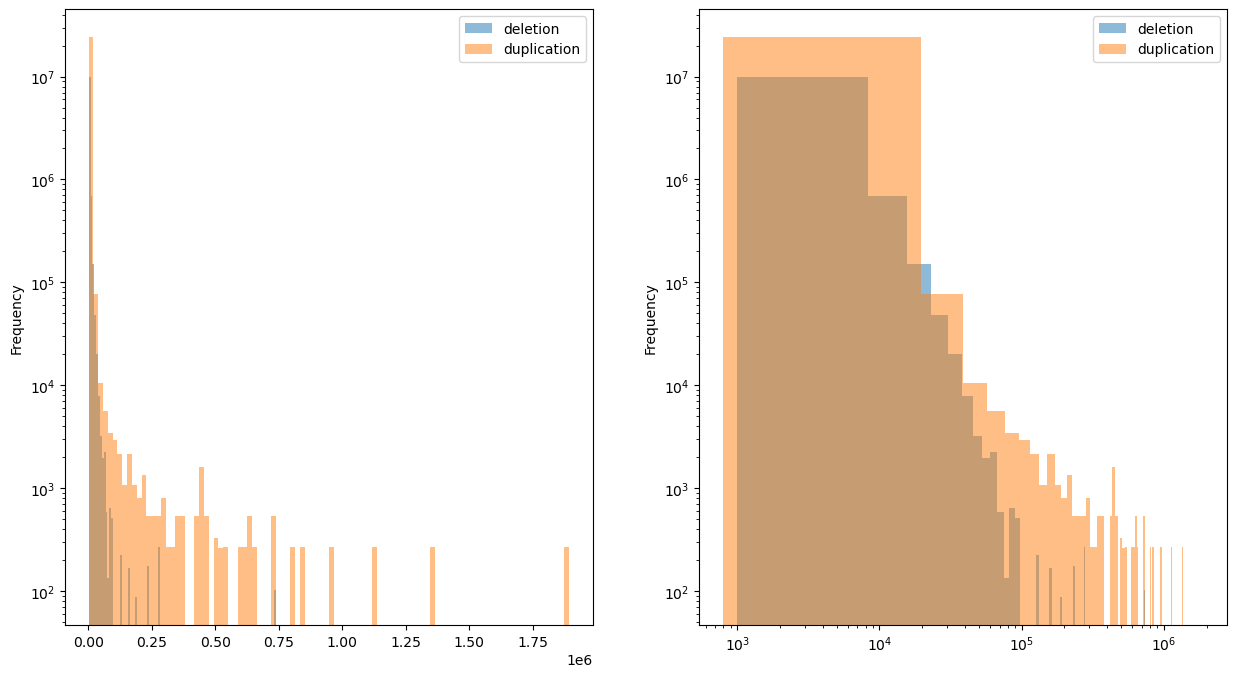

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

df_plot= chm13.groupby(['Type'])['Lenght']

df_plot.plot(kind='hist',stacked=True, bins=100, legend=True, ax=axs[0], log=True, alpha=0.5) # alpha for transparency

plt.xscale('log')
#plt.show()

df_plot = chm13.groupby(['Type'])['Lenght']

df_plot.plot(kind='hist',stacked=True, bins=100, legend=True, ax=axs[1], log=True, alpha=0.5) # alpha for transparency

plt.show()

In [13]:
chm13['Lenght'].describe()

count    3.525298e+07
mean     3.125766e+03
std      1.204405e+04
min      7.910000e+02
25%      1.172000e+03
50%      1.746000e+03
75%      3.106000e+03
max      1.893777e+06
Name: Lenght, dtype: float64

In [14]:
## Replacing chromosome names 
dict_chr = dict(zip(report['GenBank-Accn'], report['Assigned-Molecule']))
dict_chr#[final_cnv['Chromosome']== 'CP068254.1']

{'CP068277.2': '1',
 'CP068276.2': '2',
 'CP068275.2': '3',
 'CP068274.2': '4',
 'CP068273.2': '5',
 'CP068272.2': '6',
 'CP068271.2': '7',
 'CP068270.2': '8',
 'CP068269.2': '9',
 'CP068268.2': '10',
 'CP068267.2': '11',
 'CP068266.2': '12',
 'CP068265.2': '13',
 'CP068264.2': '14',
 'CP068263.2': '15',
 'CP068262.2': '16',
 'CP068261.2': '17',
 'CP068260.2': '18',
 'CP068259.2': '19',
 'CP068258.2': '20',
 'CP068257.2': '21',
 'CP068256.2': '22',
 'CP068255.2': 'X',
 'CP086569.2': 'Y',
 'CP068254.1': 'MT'}

In [15]:
#subsetting deletions and duplications
#deletions = chm13[chm13['Type'] =='deletion']
#duplications = chm13[chm13['Type'] == 'duplication']
#deletions

In [16]:
#change to df when using telomeres and centromeres filtration
final_cnv = chm13.pivot_table(index=["Chromosome", "Start", "End","Type"], 
                    columns='Sample', 
                    values='Score',
                        fill_value=2).reset_index()


final_cnv

Sample   Chromosome     Start       End         Type  LP6005441-DNA_A01  \
0        CP068254.1         0      1000  duplication                755   
1        CP068254.1      1000      2228  duplication                778   
2        CP068254.1      2228      3378  duplication                703   
3        CP068254.1      3378      4522  duplication                724   
4        CP068254.1      4522      5522  duplication                795   
...             ...       ...       ...          ...                ...   
1223900  CP086569.2  62447554  62448825  duplication                 18   
1223901  CP086569.2  62448825  62449825  duplication                 19   
1223902  CP086569.2  62449825  62450825  duplication                 21   
1223903  CP086569.2  62450825  62451825  duplication                 20   
1223904  CP086569.2  62451825  62460029  duplication                 20   

Sample   LP6005441-DNA_A03  LP6005441-DNA_A04  LP6005441-DNA_A05  \
0                      729                817                921   
1                      741                836                946   
2                      704                780                885   
3                      706                799                898   
4                      762                868                972   
...                    ...                ...                ...   
1223900                 24                 22                 22   
1223901                 25                 22                 24   
1223902                 27                 24                 26   
1223903                 26                 23                 25   
1223904                 27                 24                 24   

Sample   LP6005441-DNA_A06  LP6005441-DNA_A08  ...  LP6005677-DNA_D03  \
0                      947                792  ...                 91   
1                      989                814  ...                 93   
2                      936                765  ...                 82   
3                      945                784  ...                 85   
4                     1025                838  ...                 90   
...                    ...                ...  ...                ...   
1223900                 19                 23  ...                 25   
1223901                 21                 25  ...                 25   
1223902                 21                 25  ...                 27   
1223903                 21                 24  ...                 26   
1223904                 23                 27  ...                 28   

Sample   LP6005677-DNA_E01  LP6005677-DNA_F01  LP6005677-DNA_G01  \
0                      728                847                217   
1                      759                879                226   
2                      696                829                205   
3                      735                845                214   
4                      766                901                219   
...                    ...                ...                ...   
1223900                 17                 21                 24   
1223901                 19                 22                 25   
1223902                 20                 24                 26   
1223903                 19                 22                 25   
1223904                 21                 24                 28   

Sample   LP6007068-DNA_A01  LP6007069-DNA_A01  SS6004471  SS6004477  \
0                      171                217        725        731   
1                      179                223        773        754   
2                      155                197        708        684   
3                      168                211        735        709   
4                      177                225        791        766   
...                    ...                ...        ...        ...   
1223900                 24                 23         19         21   
1223901             

In [17]:
final_cnv['Chromosome'] =  final_cnv['Chromosome'].replace(dict_chr)
final_cnv = final_cnv[~final_cnv['Chromosome'].isin(['MT', 'X', 'Y'])]


final_cnv

Sample  Chromosome      Start        End         Type  LP6005441-DNA_A01  \
54787           22          0      20541  duplication                 28   
54788           22      20541      22327  duplication                 28   
54789           22      22327      23327  duplication                 26   
54790           22      23327      25569  duplication                 20   
54791           22      25569      26687  duplication                 13   
...            ...        ...        ...          ...                ...   
1211702          1  248364795  248366351  duplication                 23   
1211703          1  248366351  248367622  duplication                 27   
1211704          1  248367622  248368745  duplication                 23   
1211705          1  248368745  248370339  duplication                 35   
1211706          1  248370339  248387328  duplication                 37   

Sample   LP6005441-DNA_A03  LP6005441-DNA_A04  LP6005441-DNA_A05  \
54787                   30                 32                 35   
54788                   31                 32                 35   
54789                   29                 31                 32   
54790                   21                 23                 25   
54791                   13                 15                 17   
...                    ...                ...                ...   
1211702                 26                 27                 29   
1211703                 31                 29                 29   
1211704                 27                 27                 29   
1211705                 41                 39                 43   
1211706                 41                 38                 43   

Sample   LP6005441-DNA_A06  LP6005441-DNA_A08  ...  LP6005677-DNA_D03  \
54787                   32                 29  ...                 30   
54788                   32                 28  ...                 30   
54789                   29                 26  ...                 27   
54790                   23                 20  ...                 21   
54791                   14                 13  ...                 14   
...                    ...                ...  ...                ...   
1211702                 26                 23  ...                 25   
1211703                 29                 27  ...                 28   
1211704                 26                 24  ...                 25   
1211705                 41                 37  ...                 39   
1211706                 39                 38  ...                 36   

Sample   LP6005677-DNA_E01  LP6005677-DNA_F01  LP6005677-DNA_G01  \
54787                   33                 33                 37   
54788                   33                 34                 35   
54789                   29                 30                 31   
54790                   22                 23                 24   
54791                   14                 14                 14   
...                    ...                ...                ...   
1211702                 25                 26                 28   
1211703                 28                 26                 33   
1211704                 25                 27                 29   
1211705                 42                 41                 48   
1211706                 39                 39                 42   

Sample   LP6007068-DNA_A01  LP6007069-DNA_A01  SS6004471  SS6004477  \
54787                   34                 38         30         32   
54788                   34                 38         31         32   
54789                   30                 32         24         28   
54790                   22                 24         18         21   
54791                   14                 15         10         13   
...                    ...                ...        ...        ...   
1211702                 28                 32         25         26   
1211703 

In [29]:
final_cnv

Sample  Chromosome     Start       End         Type  LP6005441-DNA_A01  \
0                1    260453    261566  duplication                  4   
1                1    261566    263205  duplication                  4   
2                1    263205    264505  duplication                  3   
3                1    264505    269912  duplication                  4   
4                1    269912    271404  duplication                  3   
...            ...       ...       ...          ...                ...   
1116019         22  51289688  51291273  duplication                  4   
1116020         22  51291273  51292827  duplication                  4   
1116021         22  51292827  51295018  duplication                  4   
1116022         22  51295018  51296018     deletion                  2   
1116023         22  51295018  51296018  duplication                  4   

Sample   LP6005441-DNA_A03  LP6005441-DNA_A04  LP6005441-DNA_A05  \
0                        4                  3                  4   
1                        4                  3                  4   
2                        4                  3                  4   
3                        4                  4                  4   
4                        4                  4                  4   
...                    ...                ...                ...   
1116019                  4                  4                  4   
1116020                  4                  4                  4   
1116021                  4                  4                  4   
1116022                  2                  2                  2   
1116023                  4                  4                  4   

Sample   LP6005441-DNA_A06  LP6005441-DNA_A08  ...  LP6005677-DNA_D03  \
0                        4                  4  ...                  4   
1                        4                  4  ...                  4   
2                        4                  4  ...                  4   
3                        4                  4  ...                  4   
4                        3                  3  ...                  4   
...                    ...                ...  ...                ...   
1116019                  4                  4  ...                  4   
1116020                  4                  4  ...                  4   
1116021                  4                  4  ...                  4   
1116022                  2                  2  ...                  2   
1116023                  4                  4  ...                  4   

Sample   LP6005677-DNA_E01  LP6005677-DNA_F01  LP6005677-DNA_G01  \
0                        4                  4                  4   
1                        4                  4                  4   
2                        4                  3                  3   
3                        4                  4                  4   
4                        4                  4                  4   
...                    ...                ...                ...   
1116019                  4                  4                  4   
1116020                  4                  4                  4   
1116021                  4                  3                  4   
1116022                  2                  2                  2   
1116023                  4                  4                  4   

Sample   LP6007068-DNA_A01  LP6007069-DNA_A01  SS6004471  SS6004477  \
0                        4                  4          3          2   
1                        3                  4          4          3   
2                        3                  3          3          4   
3                        4                  4          4          4   
4                        4                  4          3          4   
...                    ...                ...        ...        ...   
1116019                  4                  4          4          4   
1116020                  4      

In [33]:
## input for CNVRanger - no funciono\n",
cnvrangerchm13 = chm13[['Sample','Chromosome', 'Start', 'End','Score']]
cnvrangerchm13['Chromosome'] =  cnvrangerchm13['Chromosome'].replace(dict_chr)
cnvrangerchm13.columns=['Sample_ID','Chr', 'Start', 'End','CNV_Value']

cnvrangerchm13['CNV_Value'] = cnvrangerchm13['CNV_Value'].astype(int)
cnvrangerchm13.to_csv('../data/chm13_cnvranger_input.csv',  index=False)

/var/folders/05/4pfxtbrs5459ytz3j1jhcgt00000gn/T/ipykernel_19201/2165391304.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnvrangerchm13['Chromosome'] =  cnvrangerchm13['Chromosome'].replace(dict_chr)
/var/folders/05/4pfxtbrs5459ytz3j1jhcgt00000gn/T/ipykernel_19201/2165391304.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnvrangerchm13['CNV_Value'] = cnvrangerchm13['CNV_Value'].astype(int)


In [34]:
cnvrangerchm13

Sample_ID Chr     Start       End  CNV_Value
17        LP6005442-DNA_A11   X     79662     98643          1
18        LP6005442-DNA_A11   X    105118    116978          1
20        LP6005442-DNA_A11   X    158982    162403          1
24        LP6005442-DNA_A11   X    169811    172183          1
25        LP6005442-DNA_A11   X    176466    178147          1
...                     ...  ..       ...       ...        ...
35659700  LP6005441-DNA_B09   Y  62447554  62448825         25
35659701  LP6005441-DNA_B09   Y  62448825  62449825         27
35659702  LP6005441-DNA_B09   Y  62449825  62450825         29
35659703  LP6005441-DNA_B09   Y  62450825  62451825         27
35659704  LP6005441-DNA_B09   Y  62451825  62460029         29

[35252982 rows x 5 columns]

In [20]:
LP6005441 = final_cnv[['Chromosome','Start','End','Type', 'LP6005441-DNA_B10']]
LP6005441.sort_values(by='LP6005441-DNA_B10', ascending=False).head(50)

Sample Chromosome      Start        End         Type  LP6005441-DNA_B10
287744         14    2426571    2428101  duplication                971
287730         14    2382373    2384735  duplication                957
326017         13    9214912    9216311  duplication                949
287716         14    2338314    2341130  duplication                932
287758         14    2465520    2472299  duplication                903
55575          22    5542871    5550196  duplication                902
287702         14    2294116    2297579  duplication                899
55617          22    5676832    5683595  duplication                885
78409          21    5529177    5532607  duplication                878
55603          22    5637086    5640553  duplication                877
287688         14    2249916    2253379  duplication                869
287772         14    2509718    2516497  duplication                860
287861         14    2781161    2784636  duplication                849
287674         14    2205718    2209181  duplication                838
287787         14    2553916    2560695  duplication                808
326045         13    9303403    9310235  duplication                798
853985          5  135453382  135454382  duplication                782
77707          21    3281416    3282416  duplication                771
326051         13    9331881    9332881  duplication                770
78090          21    4502399    4508773  duplication                770
55370          22    4918049    4919049  duplication                769
287852         14    2757682    2758682  duplication                768
77924          21    3969799    3978155  duplication                768
77818          21    3639698    3640698  duplication                768
254327         15    2968151    2969151  duplication                767
325132         13    6187236    6188236  duplication                767
254397         15    3180786    3181786  duplication                767
254690         15    4106199    4107199  duplication                767
325761         13    8347853    8348853  duplication                767
325529         13    7549362    7550362  duplication                767
254257         15    2755516    2756516  duplication                767
254187         15    2542881    2543881  duplication                767
78276          21    5106458    5107458  duplication                767
287817         14    2642312    2648700  duplication                766
78109          21    4573858    4574858  duplication                765
287651         14    2138004    2139004  duplication                765
55426          22    5091585    5092585  duplication                765
287866         14    2801835    2802835  duplication                765
78040          21    4351858    4352858  duplication                764
287802         14    2598114    2604893  duplication                764
77943          21    4041258    4042258  duplication                764
287665         14    2182202    2183202  duplication                764
325365         13    6985690    6986690  duplication                763
55482          22    5265121    5266121  duplication                763
287838         14    2713576    2714576  duplication                763
326023         13    9236766    9237766  duplication                763
254843         15    4600462    4601462  duplication                762
77860          21    3774178    3775178  duplication                762
325925         13    8911525    8912525  duplication                762
325296         13    6750908    6751908  duplication                762

<h1> Removing cnvs from exclusion regions 

In [21]:
black_header = ['Chromosome','Start', 'End', 'Type', 'Extra1', 'Extra2']
blacklist = pd.read_table('/Users/luciabazan/Downloads/T2T.excluderanges.bed', names=black_header)
blacklist['Chromosome'] = blacklist['Chromosome'].str.replace('chr', '')
blacklist = blacklist.drop(columns=['Extra1', 'Extra2'])
blacklist_ranges = PyRanges(blacklist)

In [22]:
final_cnv_ranges = PyRanges(final_cnv)
final_cnv = final_cnv_ranges.overlap(blacklist_ranges, invert=True)
final_cnv = final_cnv.as_df()
#final_cnv.to_csv('../data/T2TCHM13_cnvs.csv.zip', compression="zip")
final_cnv

Sample  Chromosome     Start       End         Type  LP6005441-DNA_A01  \
0                1    260453    261566  duplication                  4   
1                1    261566    263205  duplication                  4   
2                1    263205    264505  duplication                  3   
3                1    264505    269912  duplication                  4   
4                1    269912    271404  duplication                  3   
...            ...       ...       ...          ...                ...   
1116019         22  51289688  51291273  duplication                  4   
1116020         22  51291273  51292827  duplication                  4   
1116021         22  51292827  51295018  duplication                  4   
1116022         22  51295018  51296018     deletion                  2   
1116023         22  51295018  51296018  duplication                  4   

Sample   LP6005441-DNA_A03  LP6005441-DNA_A04  LP6005441-DNA_A05  \
0                        4                  3                  4   
1                        4                  3                  4   
2                        4                  3                  4   
3                        4                  4                  4   
4                        4                  4                  4   
...                    ...                ...                ...   
1116019                  4                  4                  4   
1116020                  4                  4                  4   
1116021                  4                  4                  4   
1116022                  2                  2                  2   
1116023                  4                  4                  4   

Sample   LP6005441-DNA_A06  LP6005441-DNA_A08  ...  LP6005677-DNA_D03  \
0                        4                  4  ...                  4   
1                        4                  4  ...                  4   
2                        4                  4  ...                  4   
3                        4                  4  ...                  4   
4                        3                  3  ...                  4   
...                    ...                ...  ...                ...   
1116019                  4                  4  ...                  4   
1116020                  4                  4  ...                  4   
1116021                  4                  4  ...                  4   
1116022                  2                  2  ...                  2   
1116023                  4                  4  ...                  4   

Sample   LP6005677-DNA_E01  LP6005677-DNA_F01  LP6005677-DNA_G01  \
0                        4                  4                  4   
1                        4                  4                  4   
2                        4                  3                  3   
3                        4                  4                  4   
4                        4                  4                  4   
...                    ...                ...                ...   
1116019                  4                  4                  4   
1116020                  4                  4                  4   
1116021                  4                  3                  4   
1116022                  2                  2                  2   
1116023                  4                  4                  4   

Sample   LP6007068-DNA_A01  LP6007069-DNA_A01  SS6004471  SS6004477  \
0                        4                  4          3          2   
1                        3                  4          4          3   
2                        3                  3          3          4   
3                        4                  4          4          4   
4                        4                  4          3          4   
...                    ...                ...        ...        ...   
1116019                  4                  4          4          4   
1116020                  4      

In [23]:
d = final_cnv.fillna(2)
#d.to_csv('../data/t2tchm13_all_pivot.bed', sep='\t', header=False, index=False )
d

Sample  Chromosome     Start       End         Type  LP6005441-DNA_A01  \
0                1    260453    261566  duplication                  4   
1                1    261566    263205  duplication                  4   
2                1    263205    264505  duplication                  3   
3                1    264505    269912  duplication                  4   
4                1    269912    271404  duplication                  3   
...            ...       ...       ...          ...                ...   
1116019         22  51289688  51291273  duplication                  4   
1116020         22  51291273  51292827  duplication                  4   
1116021         22  51292827  51295018  duplication                  4   
1116022         22  51295018  51296018     deletion                  2   
1116023         22  51295018  51296018  duplication                  4   

Sample   LP6005441-DNA_A03  LP6005441-DNA_A04  LP6005441-DNA_A05  \
0                        4                  3                  4   
1                        4                  3                  4   
2                        4                  3                  4   
3                        4                  4                  4   
4                        4                  4                  4   
...                    ...                ...                ...   
1116019                  4                  4                  4   
1116020                  4                  4                  4   
1116021                  4                  4                  4   
1116022                  2                  2                  2   
1116023                  4                  4                  4   

Sample   LP6005441-DNA_A06  LP6005441-DNA_A08  ...  LP6005677-DNA_D03  \
0                        4                  4  ...                  4   
1                        4                  4  ...                  4   
2                        4                  4  ...                  4   
3                        4                  4  ...                  4   
4                        3                  3  ...                  4   
...                    ...                ...  ...                ...   
1116019                  4                  4  ...                  4   
1116020                  4                  4  ...                  4   
1116021                  4                  4  ...                  4   
1116022                  2                  2  ...                  2   
1116023                  4                  4  ...                  4   

Sample   LP6005677-DNA_E01  LP6005677-DNA_F01  LP6005677-DNA_G01  \
0                        4                  4                  4   
1                        4                  4                  4   
2                        4                  3                  3   
3                        4                  4                  4   
4                        4                  4                  4   
...                    ...                ...                ...   
1116019                  4                  4                  4   
1116020                  4                  4                  4   
1116021                  4                  3                  4   
1116022                  2                  2                  2   
1116023                  4                  4                  4   

Sample   LP6007068-DNA_A01  LP6007069-DNA_A01  SS6004471  SS6004477  \
0                        4                  4          3          2   
1                        3                  4          4          3   
2                        3                  3          3          4   
3                        4                  4          4          4   
4                        4                  4          3          4   
...                    ...                ...        ...        ...   
1116019                  4                  4          4          4   
1116020                  4      

Sample  Chromosome     Start       End         Type  LP6005441-DNA_A01  \
0             chr1    260453    261566  duplication                  4   
1             chr1    261566    263205  duplication                  4   
2             chr1    263205    264505  duplication                  3   
3             chr1    264505    269912  duplication                  4   
4             chr1    269912    271404  duplication                  3   
...            ...       ...       ...          ...                ...   
1116019      chr22  51289688  51291273  duplication                  4   
1116020      chr22  51291273  51292827  duplication                  4   
1116021      chr22  51292827  51295018  duplication                  4   
1116022      chr22  51295018  51296018     deletion                  2   
1116023      chr22  51295018  51296018  duplication                  4   

Sample   LP6005441-DNA_A03  LP6005441-DNA_A04  LP6005441-DNA_A05  \
0                        4                  3                  4   
1                        4                  3                  4   
2                        4                  3                  4   
3                        4                  4                  4   
4                        4                  4                  4   
...                    ...                ...                ...   
1116019                  4                  4                  4   
1116020                  4                  4                  4   
1116021                  4                  4                  4   
1116022                  2                  2                  2   
1116023                  4                  4                  4   

Sample   LP6005441-DNA_A06  LP6005441-DNA_A08  ...  LP6005677-DNA_D03  \
0                        4                  4  ...                  4   
1                        4                  4  ...                  4   
2                        4                  4  ...                  4   
3                        4                  4  ...                  4   
4                        3                  3  ...                  4   
...                    ...                ...  ...                ...   
1116019                  4                  4  ...                  4   
1116020                  4                  4  ...                  4   
1116021                  4                  4  ...                  4   
1116022                  2                  2  ...                  2   
1116023                  4                  4  ...                  4   

Sample   LP6005677-DNA_E01  LP6005677-DNA_F01  LP6005677-DNA_G01  \
0                        4                  4                  4   
1                        4                  4                  4   
2                        4                  3                  3   
3                        4                  4                  4   
4                        4                  4                  4   
...                    ...                ...                ...   
1116019                  4                  4                  4   
1116020                  4                  4                  4   
1116021                  4                  3                  4   
1116022                  2                  2                  2   
1116023                  4                  4                  4   

Sample   LP6007068-DNA_A01  LP6007069-DNA_A01  SS6004471  SS6004477  \
0                        4                  4          3          2   
1                        3                  4          4          3   
2                        3                  3          3          4   
3                        4                  4          4          4   
4                        4                  4          3          4   
...                    ...                ...        ...        ...   
1116019                  4                  4          4          4   
1116020                  4      

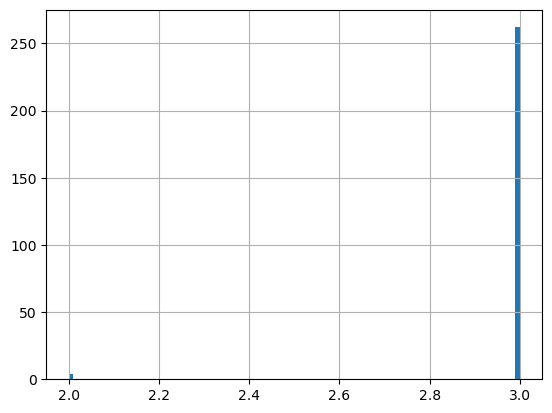

In [24]:
d.iloc[81275,4:280].hist(bins=100)
d['Chromosome'] = 'chr' + d['Chromosome'].astype(str)
d

In [25]:
## Saving CNVs coordinates as bed file to liftover
d.iloc[:,0:4].to_csv('cnvs_coordinates_chm13t2t.bed', header=False, index=False,sep='\t')

In [26]:
columns = d.columns
np.savetxt("../data/t2tchm13_all_pivot_names.bed", columns,
           delimiter ="/t", 
           fmt ='% s')

<h1> PCA 

In [27]:
#final_cnv = final_cnv.iloc[new]
final = final_cnv.iloc[:,4:287]
counts = final
counts = counts.fillna(2)
counts
#sns.displot(penguins, 


Sample   LP6005441-DNA_A01  LP6005441-DNA_A03  LP6005441-DNA_A04  \
0                        4                  4                  3   
1                        4                  4                  3   
2                        3                  4                  3   
3                        4                  4                  4   
4                        3                  4                  4   
...                    ...                ...                ...   
1116019                  4                  4                  4   
1116020                  4                  4                  4   
1116021                  4                  4                  4   
1116022                  2                  2                  2   
1116023                  4                  4                  4   

Sample   LP6005441-DNA_A05  LP6005441-DNA_A06  LP6005441-DNA_A08  \
0                        4                  4                  4   
1                        4                  4                  4   
2                        4                  4                  4   
3                        4                  4                  4   
4                        4                  3                  3   
...                    ...                ...                ...   
1116019                  4                  4                  4   
1116020                  4                  4                  4   
1116021                  4                  4                  4   
1116022                  2                  2                  2   
1116023                  4                  4                  4   

Sample   LP6005441-DNA_A09  LP6005441-DNA_A10  LP6005441-DNA_A11  \
0                        4                  2                  4   
1                        4                  3                  4   
2                        4                  3                  4   
3                        4                  4                  4   
4                        4                  4                  4   
...                    ...                ...                ...   
1116019                  5                  4                  4   
1116020                  5                  4                  4   
1116021                  5                  4                  4   
1116022                  2                  2                  2   
1116023                  5                  4                  4   

Sample   LP6005441-DNA_A12  ...  LP6005677-DNA_D03  LP6005677-DNA_E01  \
0                        4  ...                  4                  4   
1                        4  ...                  4                  4   
2                        3  ...                  4                  4   
3                        4  ...                  4                  4   
4                        4  ...                  4                  4   
...                    ...  ...                ...                ...   
1116019                  4  ...                  4                  4   
1116020                  4  ...                  4                  4   
1116021                  4  ...                  4                  4   
1116022                  2  ...                  2                  2   
1116023                  4  ...                  4                  4   

Sample   LP6005677-DNA_F01  LP6005677-DNA_G01  LP6007068-DNA_A01  \
0                        4                  4                  4   
1                        4                  4                  3   
2                        3                  3                  3   
3                        4                  4                  4   
4                        4                  4                  4   
...                    ...                ...                ...   
1116019                  4                  4                  4   
1116020                  4                  4                  4   
1116021                  3                  4               

In [28]:
counts = counts.T
counts = counts.sort_index()
counts

0        1        2        3        4        5        \
Sample                                                                    
LP6005441-DNA_A01        4        4        3        4        3        3   
LP6005441-DNA_A03        4        4        4        4        4        4   
LP6005441-DNA_A04        3        3        3        4        4        4   
LP6005441-DNA_A05        4        4        4        4        4        4   
LP6005441-DNA_A06        4        4        4        4        3        3   
...                    ...      ...      ...      ...      ...      ...   
LP6007069-DNA_A01        4        4        3        4        4        4   
SS6004471                3        4        3        4        3        4   
SS6004477                2        3        4        4        4        4   
SS6004478                3        3        3        4        4        4   
SS6004480                4        4        3        4        4        4   

                   6        7        8        9        ...  1116014  1116015  \
Sample                                                 ...                     
LP6005441-DNA_A01        4        4        4        4  ...        2        3   
LP6005441-DNA_A03        4        4        4        4  ...        2        4   
LP6005441-DNA_A04        4        4        4        4  ...        2        4   
LP6005441-DNA_A05        4        4        4        4  ...        2        4   
LP6005441-DNA_A06        4        4        4        4  ...        2        4   
...                    ...      ...      ...      ...  ...      ...      ...   
LP6007069-DNA_A01        4        3        4        4  ...        2        4   
SS6004471                3        4        4        4  ...        2        4   
SS6004477                4        3        4        4  ...        2        4   
SS6004478                4        3        4        4  ...        2        4   
SS6004480                3        4        4        4  ...        2        4   

                   1116016  1116017  1116018  1116019  1116020  1116021  \
Sample                                                                    
LP6005441-DNA_A01        4        3        4        4        4        4   
LP6005441-DNA_A03        4        4        4        4        4        4   
LP6005441-DNA_A04        4        4        4        4        4        4   
LP6005441-DNA_A05        4        3        4        4        4        4   
LP6005441-DNA_A06        4        4        4        4        4        4   
...                    ...      ...      ...      ...      ...      ...   
LP6007069-DNA_A01        4        4        5        4        5        4   
SS6004471                4        4        4        4        4        4   
SS6004477                4        4        5        4        4        4   
SS6004478                4        4        4        4        4        4   
SS6004480                4        4        5        4        5        4   

                   1116022  1116023  
Sample                               
LP6005441-DNA_A01        2        4  
LP6005441-DNA_A03        2        4  
LP6005441-DNA_A04        2        4  
LP6005441-DNA_A05        2        4  
LP6005441-DNA_A06        2        4  
...                    ...      ...  
LP6007069-DNA_A01        2        5  
SS6004471                2        5  
SS6004477                2        5  
SS6004478                2        4  
SS6004480                2        5  

[266 rows x 1116024 columns]

In [32]:
features = ids_hg19.set_index('Sample').merge(counts, left_index=True, right_index=True)
features = features.loc[:,['Region']]
features = features.sort_index()
features 

Region
Sample                        
LP6005441-DNA_A01  WestEurasia
LP6005441-DNA_A03      Oceania
LP6005441-DNA_A04      America
LP6005441-DNA_A05  WestEurasia
LP6005441-DNA_A06  WestEurasia
...                        ...
LP6007069-DNA_A01  WestEurasia
SS6004471               Africa
SS6004477              Oceania
SS6004478              Oceania
SS6004480               Africa

[266 rows x 1 columns]

In [33]:
#PCA

pca = PCA(n_components=10)
pca_results = pca.fit_transform(counts)

df_pca= pd.DataFrame(pca_results,
                          columns=['component_1','component_2', 'component_3', 'component_4',
                                  'component_5',
                                  'component_6',
                                  'component_7',
                                  'component_8',
                                  'component_9',
                                   'component_10'
                                  ],
                          index=features.index)




df_pca = features.merge(df_pca, left_index=True, right_index=True)
df_pca

Region  component_1  component_2  component_3  \
Sample                                                                  
LP6005441-DNA_A01  WestEurasia   309.170076  -193.530740   629.168547   
LP6005441-DNA_A03      Oceania   -13.615750  -207.457984    93.001756   
LP6005441-DNA_A04      America  -420.972101  -663.763562   210.093302   
LP6005441-DNA_A05  WestEurasia  -167.413351  -477.629393  -314.416034   
LP6005441-DNA_A06  WestEurasia   687.946470   -28.184155   -43.737911   
...                        ...          ...          ...          ...   
LP6007069-DNA_A01  WestEurasia  -223.766166   427.698283   244.237796   
SS6004471               Africa  -474.057259  -680.609075  -202.242864   
SS6004477              Oceania  -501.430329  -518.003188  -291.294211   
SS6004478              Oceania   288.855001  -678.933329    12.736783   
SS6004480               Africa   -25.126536   679.829549  -200.774958   

                   component_4  component_5  component_6  component_7  \
Sample                                                                  
LP6005441-DNA_A01  -275.976482  -159.453082   122.579922   123.182375   
LP6005441-DNA_A03  -178.569755   -69.569641   -98.135886    81.016479   
LP6005441-DNA_A04  -288.330689   -32.762211   -78.794621   227.175594   
LP6005441-DNA_A05  -213.177666  -169.500152   203.875949   191.679957   
LP6005441-DNA_A06   -14.056913   215.722747   541.851492   -67.860079   
...                        ...          ...          ...          ...   
LP6007069-DNA_A01  -186.004246   124.262430   247.971862   -88.541585   
SS6004471           334.355598   252.721211    52.732874   -74.461099   
SS6004477          -113.452230   627.628779   -68.156404   102.216505   
SS6004478           -24.659343   148.940394   254.546511  -166.156938   
SS6004480            44.210021  -163.756696   160.223916   -30.597881   

                   component_8  component_9  component_10  
Sample                                                     
LP6005441-DNA_A01    66.169520    11.211084    -29.846039  
LP6005441-DNA_A03   -49.565413   -62.291947    -99.283888  
LP6005441-DNA_A04   -95.594677  -111.080004   -163.221567  
LP6005441-DNA_A05   -10.633997   -21.682970     28.086235  
LP6005441-DNA_A06    23.194539   114.801991     -8.538317  
...                        ...          ...           ...  
LP6007069-DNA_A01    85.271777   238.547730   -262.746732  
SS6004471           128.197305   352.845892   -203.491161  
SS6004477           -99.217660   232.568864   -292.123239  
SS6004478            38.919673   142.513706   -169.177685  
SS6004480            29.621900   208.029055   -128.688094  

[266 rows x 11 columns]

In [34]:
pca.explained_variance_ratio_

array([0.28303099, 0.2521258 , 0.14300747, 0.07450093, 0.04872312,
       0.04513816, 0.02273561, 0.01495336, 0.00829579, 0.0069146 ])

             component_1  component_2  component_3  component_4  component_5  \
Region                                                                         
WestEurasia   309.170076  -193.530740   629.168547  -275.976482  -159.453082   
Oceania       -13.615750  -207.457984    93.001756  -178.569755   -69.569641   
America      -420.972101  -663.763562   210.093302  -288.330689   -32.762211   
WestEurasia  -167.413351  -477.629393  -314.416034  -213.177666  -169.500152   
WestEurasia   687.946470   -28.184155   -43.737911   -14.056913   215.722747   
...                  ...          ...          ...          ...          ...   
WestEurasia  -223.766166   427.698283   244.237796  -186.004246   124.262430   
Africa       -474.057259  -680.609075  -202.242864   334.355598   252.721211   
Oceania      -501.430329  -518.003188  -291.294211  -113.452230   627.628779   
Oceania       288.855001  -678.933329    12.736783   -24.659343   148.940394   
Africa        -25.126536   679.829549  -

             component_1  component_2  component_3  component_4  component_5  \
Region                                                                         
WestEurasia   309.170076  -193.530740   629.168547  -275.976482  -159.453082   
Oceania       -13.615750  -207.457984    93.001756  -178.569755   -69.569641   
America      -420.972101  -663.763562   210.093302  -288.330689   -32.762211   
WestEurasia  -167.413351  -477.629393  -314.416034  -213.177666  -169.500152   
WestEurasia   687.946470   -28.184155   -43.737911   -14.056913   215.722747   
...                  ...          ...          ...          ...          ...   
WestEurasia  -223.766166   427.698283   244.237796  -186.004246   124.262430   
Africa       -474.057259  -680.609075  -202.242864   334.355598   252.721211   
Oceania      -501.430329  -518.003188  -291.294211  -113.452230   627.628779   
Oceania       288.855001  -678.933329    12.736783   -24.659343   148.940394   
Africa        -25.126536   679.829549  -

/Users/luciabazan/Documents/GitHub/cnv_sgdp/scripts/pca_plot.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure = matplotlib.pyplot.figure(


Count of groups by factor: 7
             component_1  component_2  component_3  component_4  component_5  \
Region                                                                         
WestEurasia   309.170076  -193.530740   629.168547  -275.976482  -159.453082   
Oceania       -13.615750  -207.457984    93.001756  -178.569755   -69.569641   
America      -420.972101  -663.763562   210.093302  -288.330689   -32.762211   
WestEurasia  -167.413351  -477.629393  -314.416034  -213.177666  -169.500152   
WestEurasia   687.946470   -28.184155   -43.737911   -14.056913   215.722747   
...                  ...          ...          ...          ...          ...   
WestEurasia  -223.766166   427.698283   244.237796  -186.004246   124.262430   
Africa       -474.057259  -680.609075  -202.242864   334.355598   252.721211   
Oceania      -501.430329  -518.003188  -291.294211  -113.452230   627.628779   
Oceania       288.855001  -678.933329    12.736783   -24.659343   148.940394   
Africa     

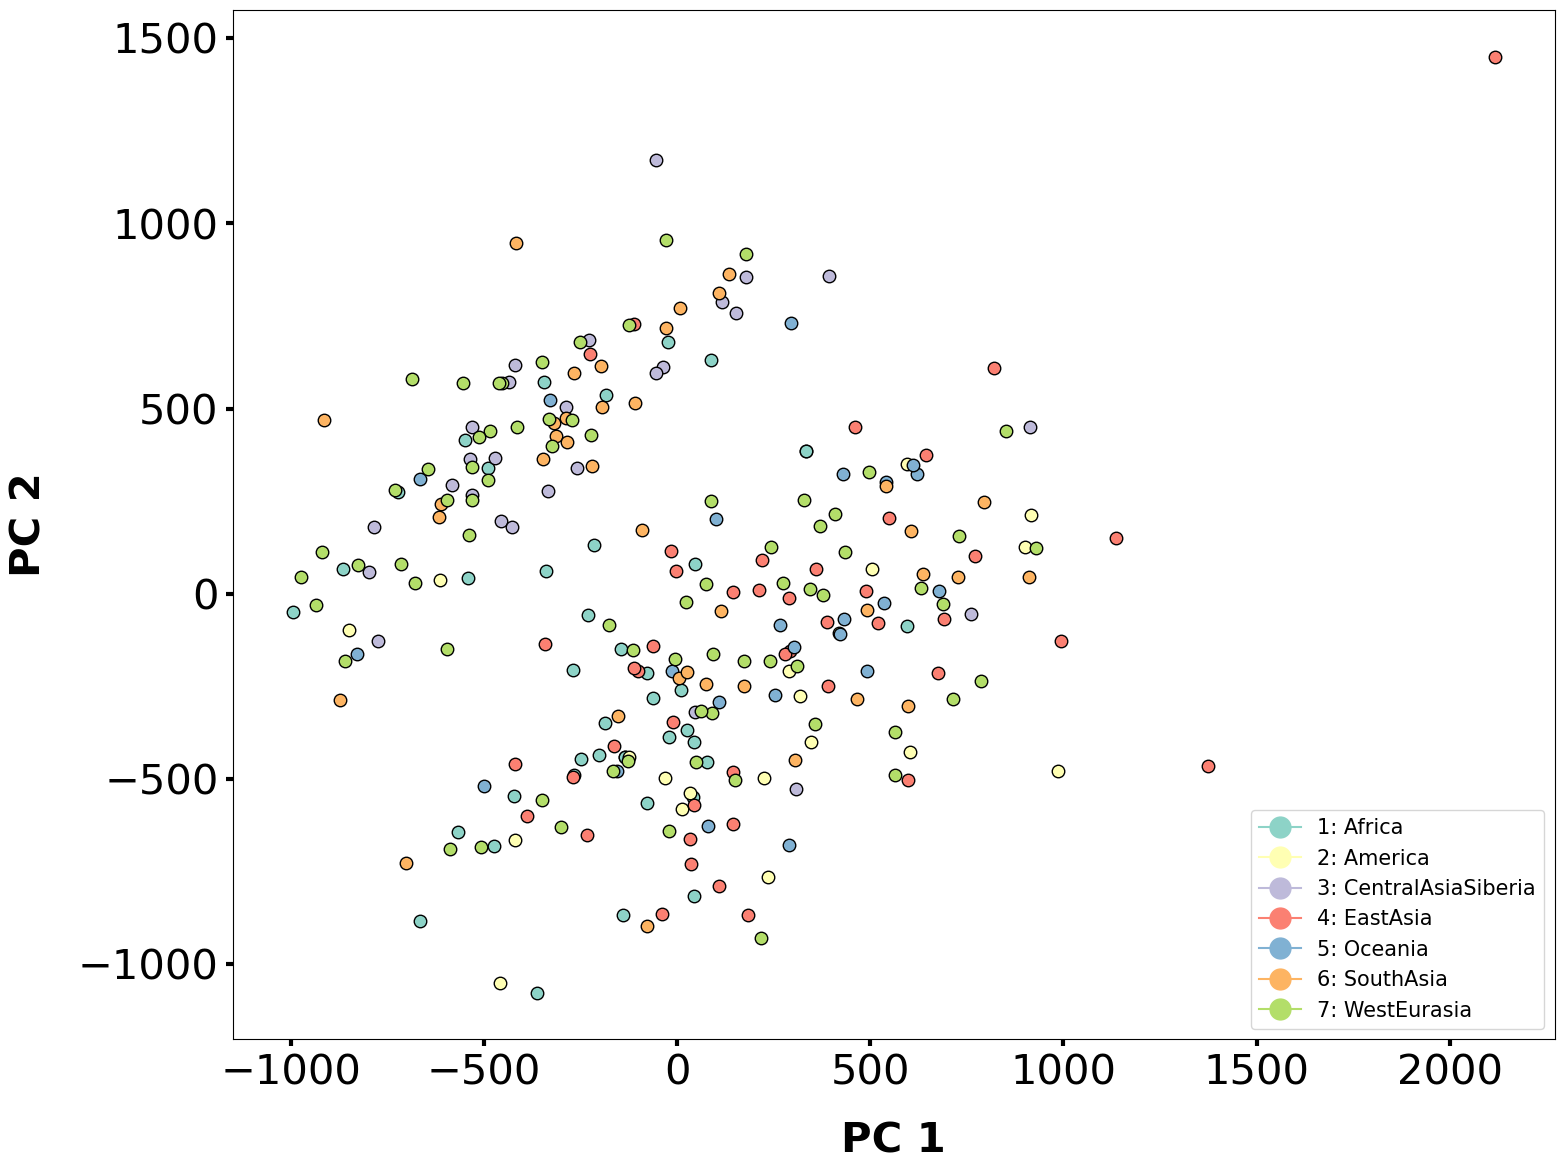

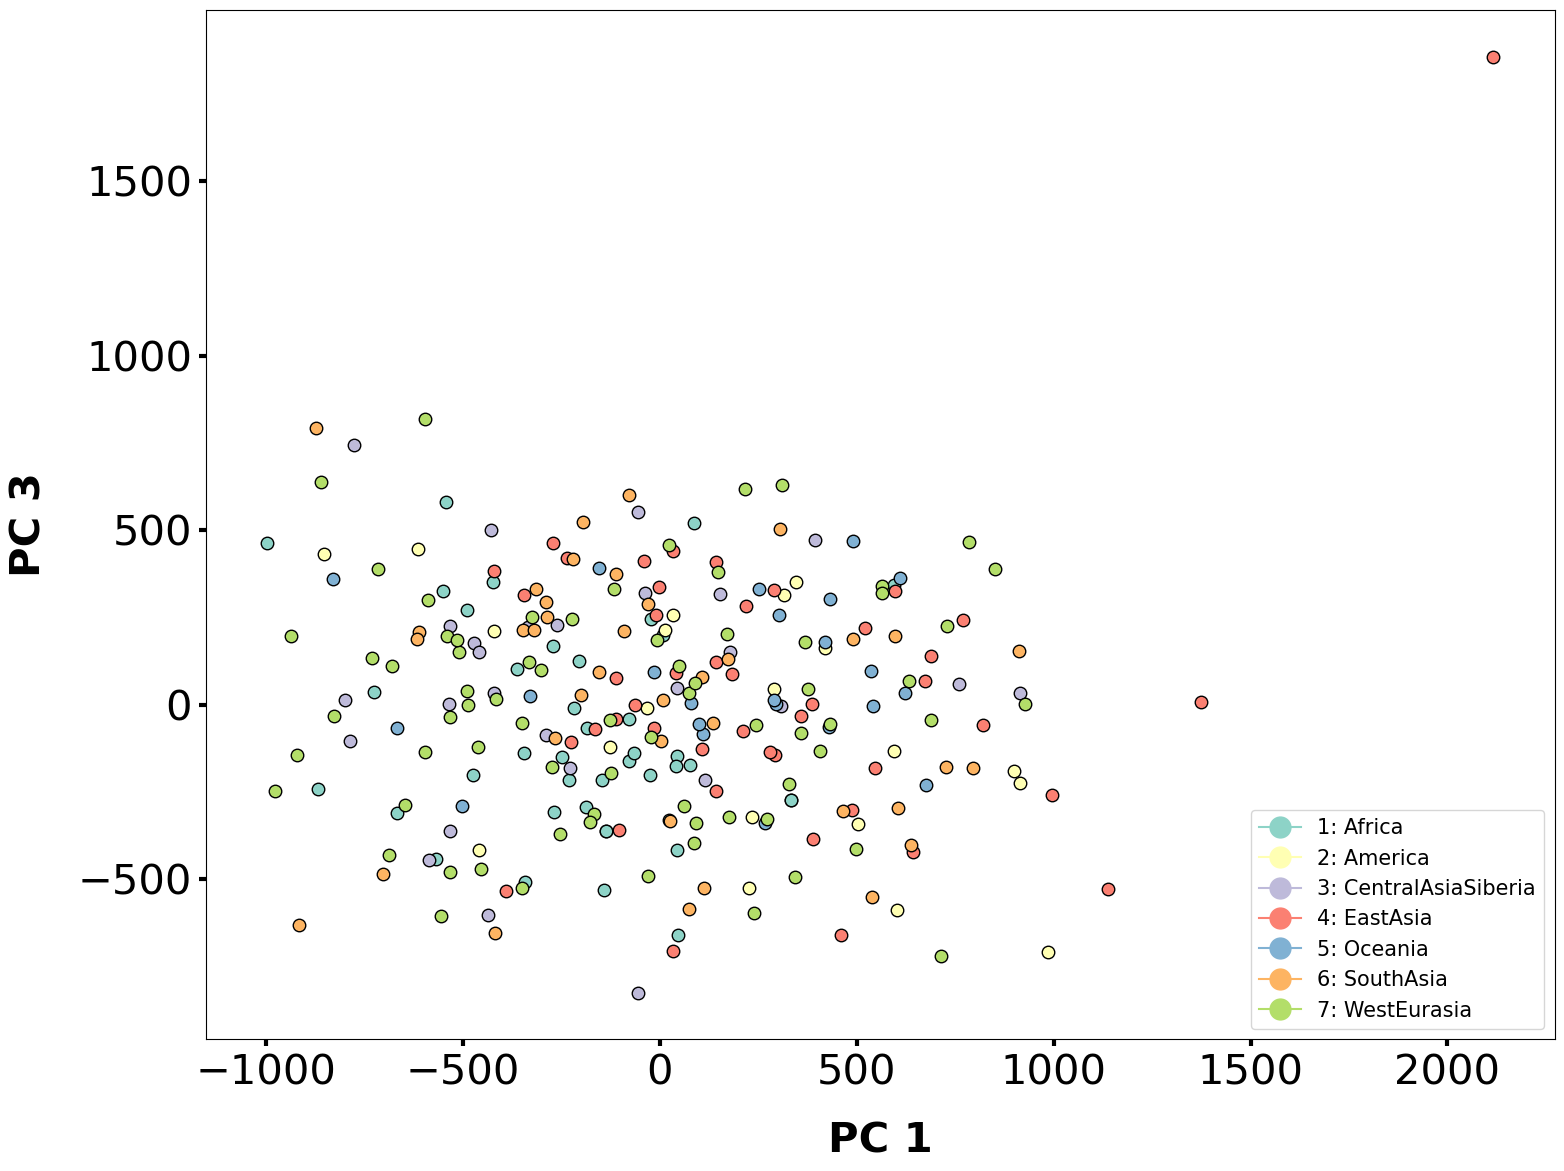

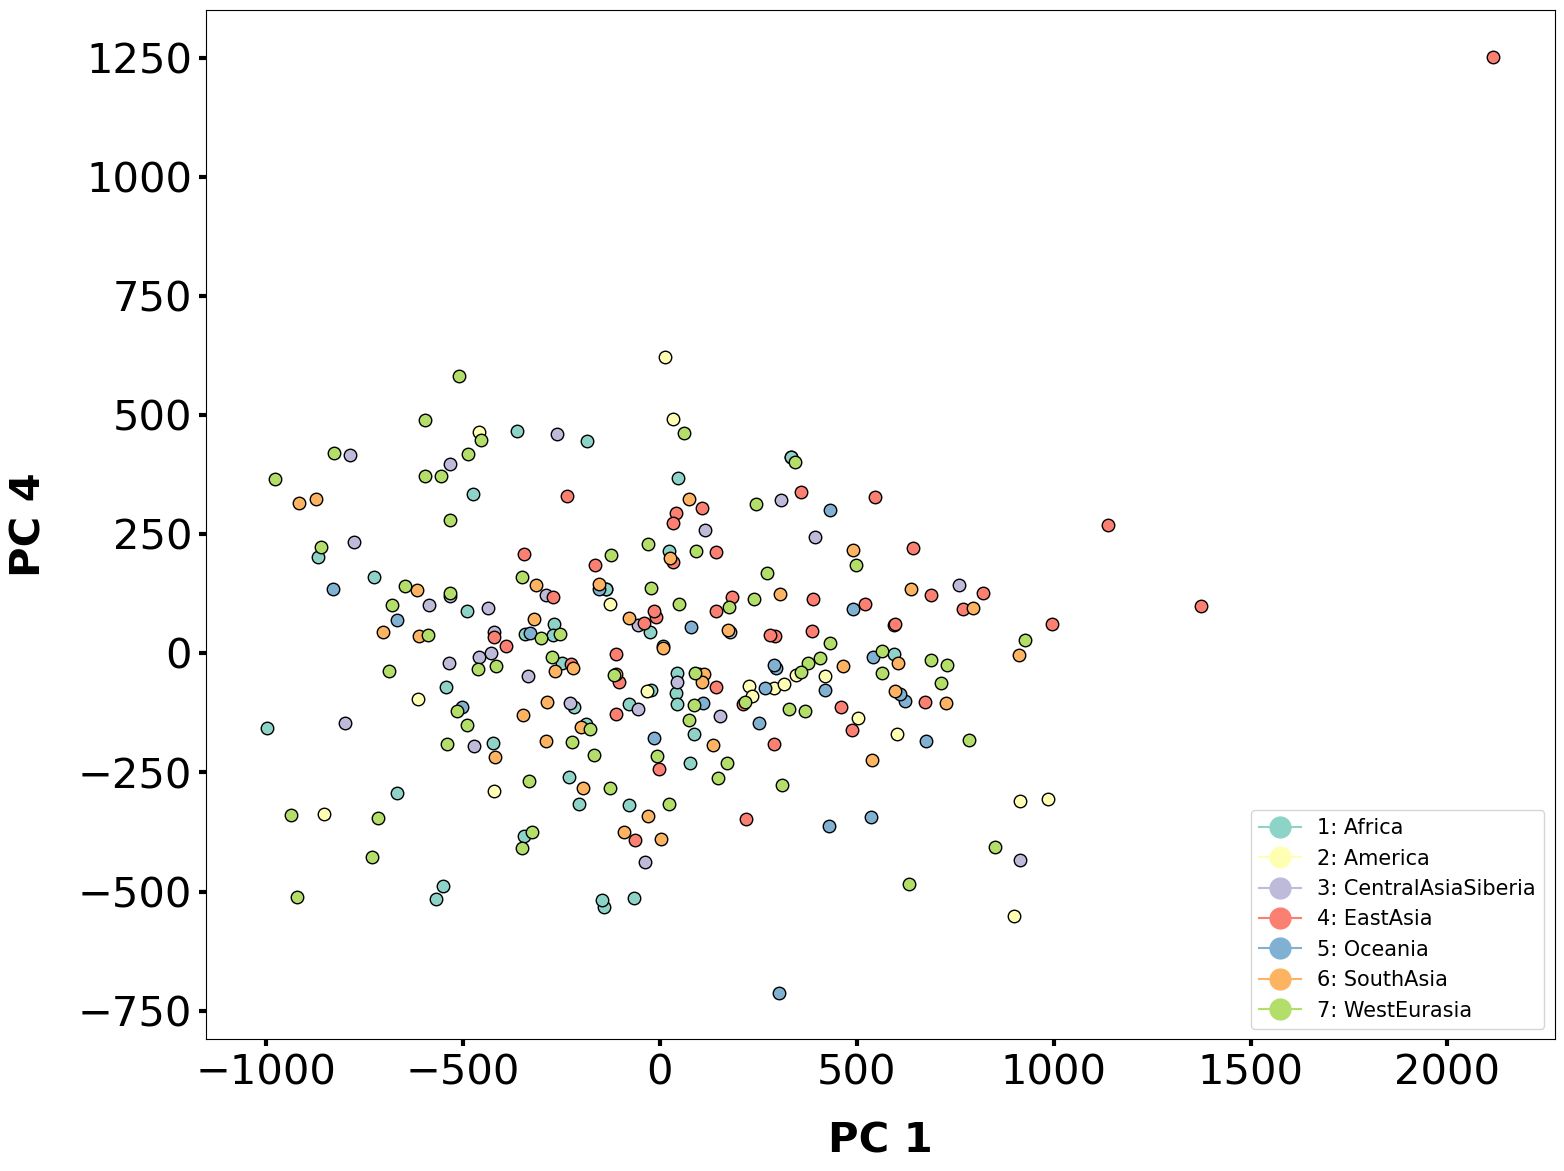

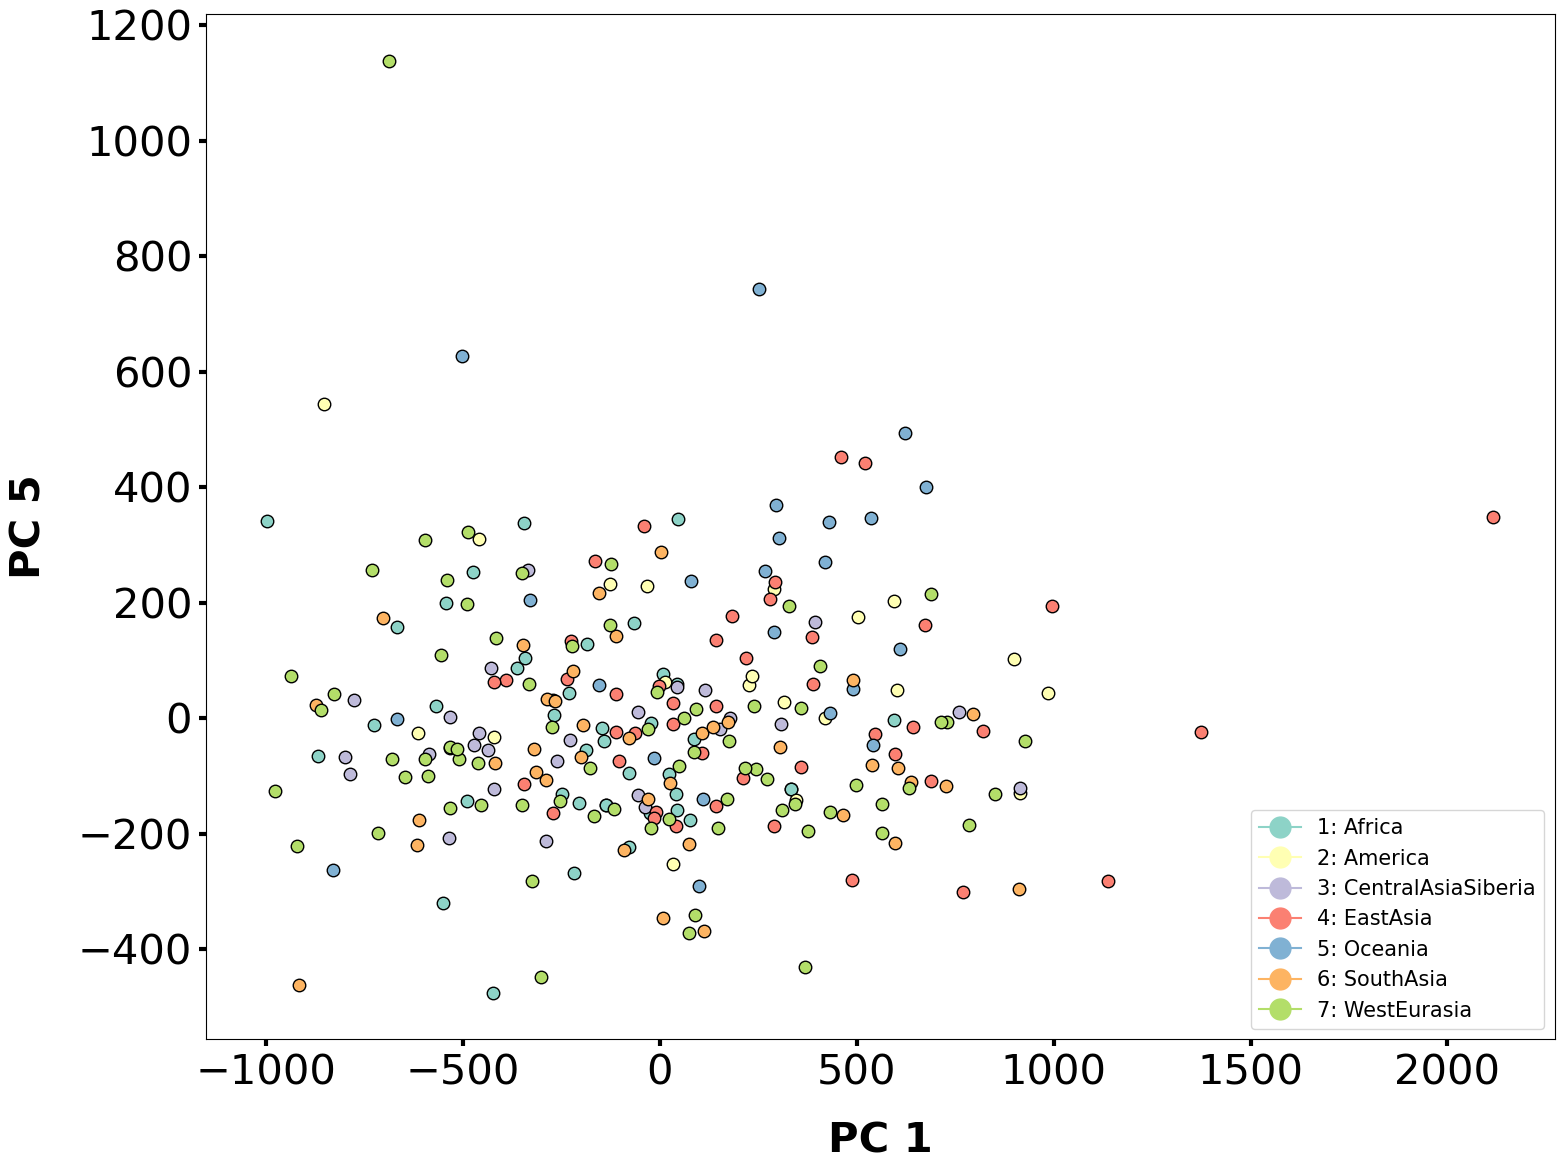

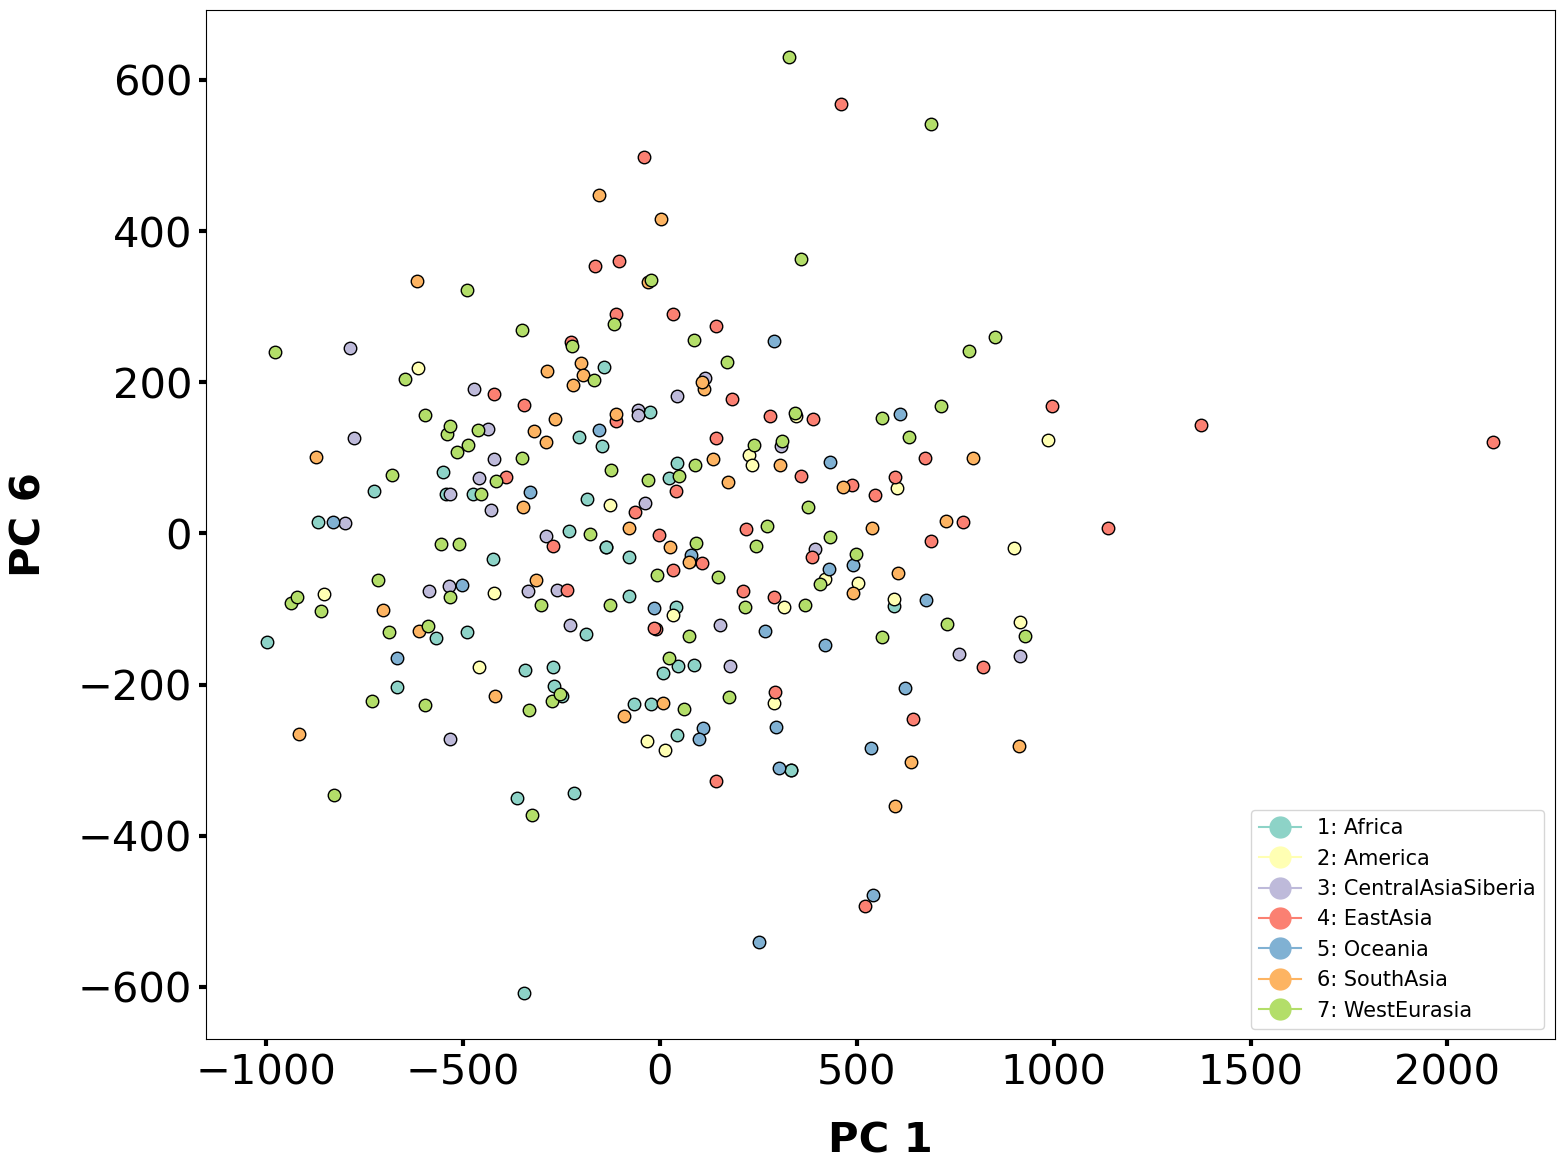

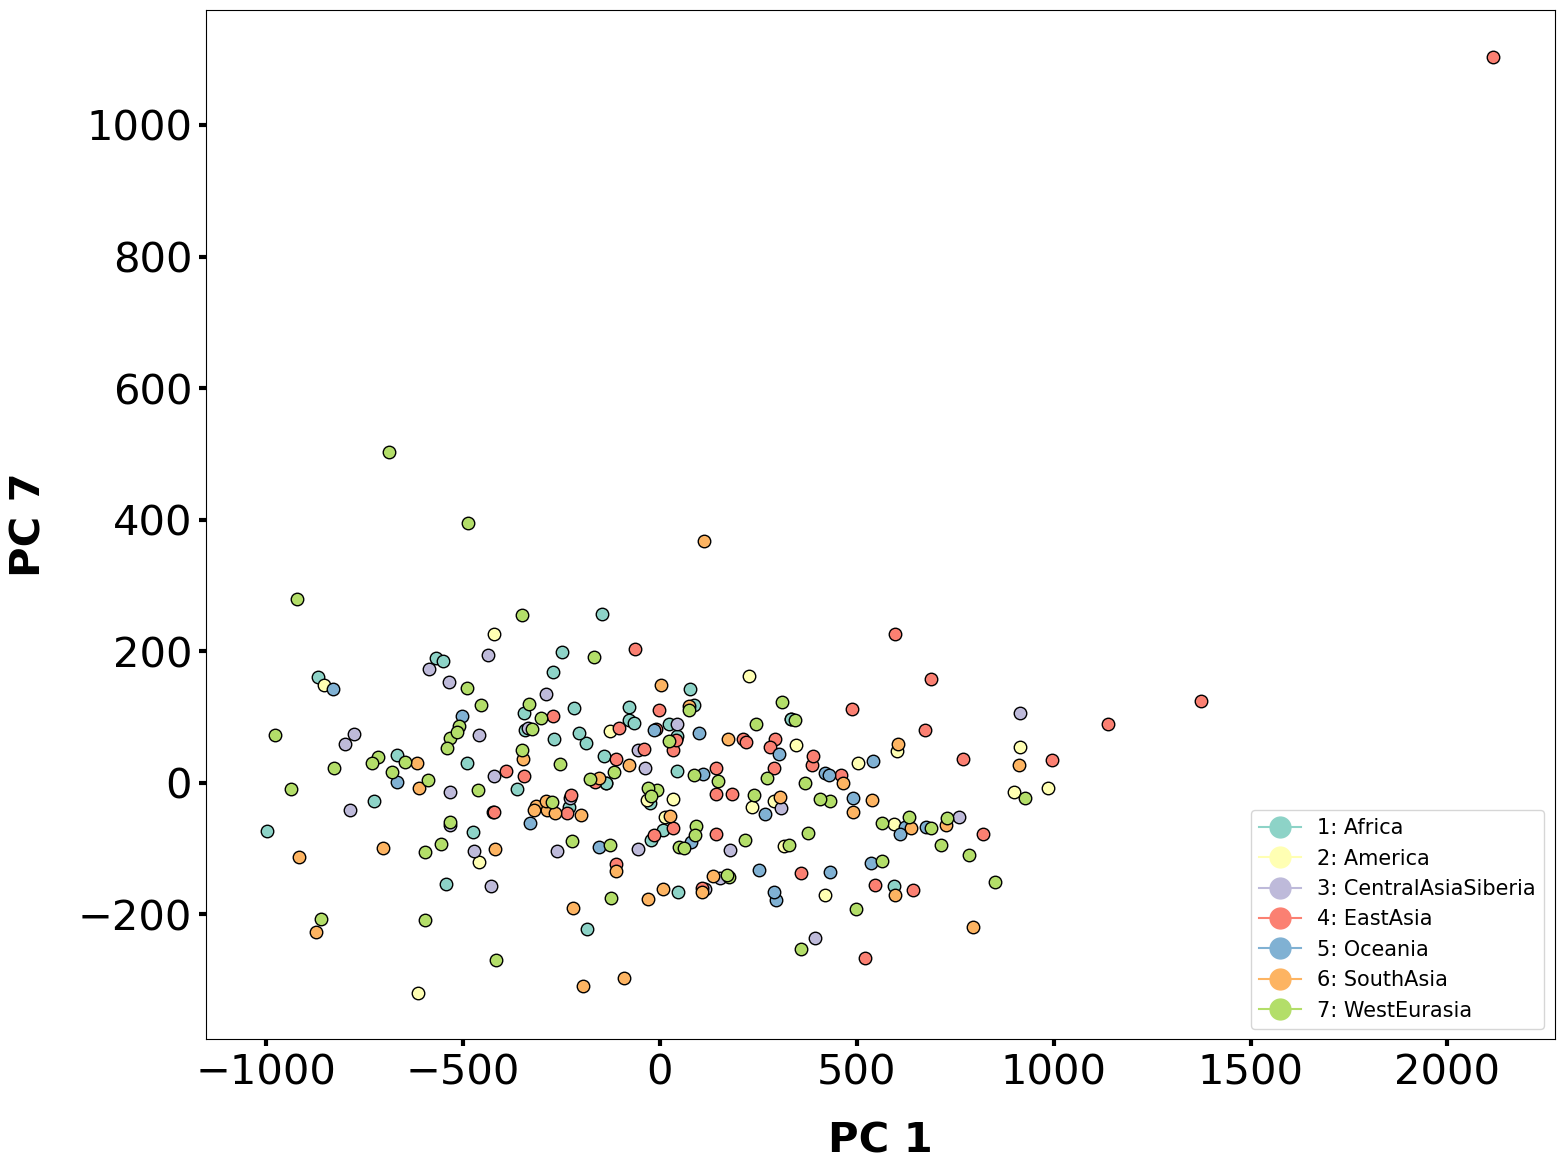

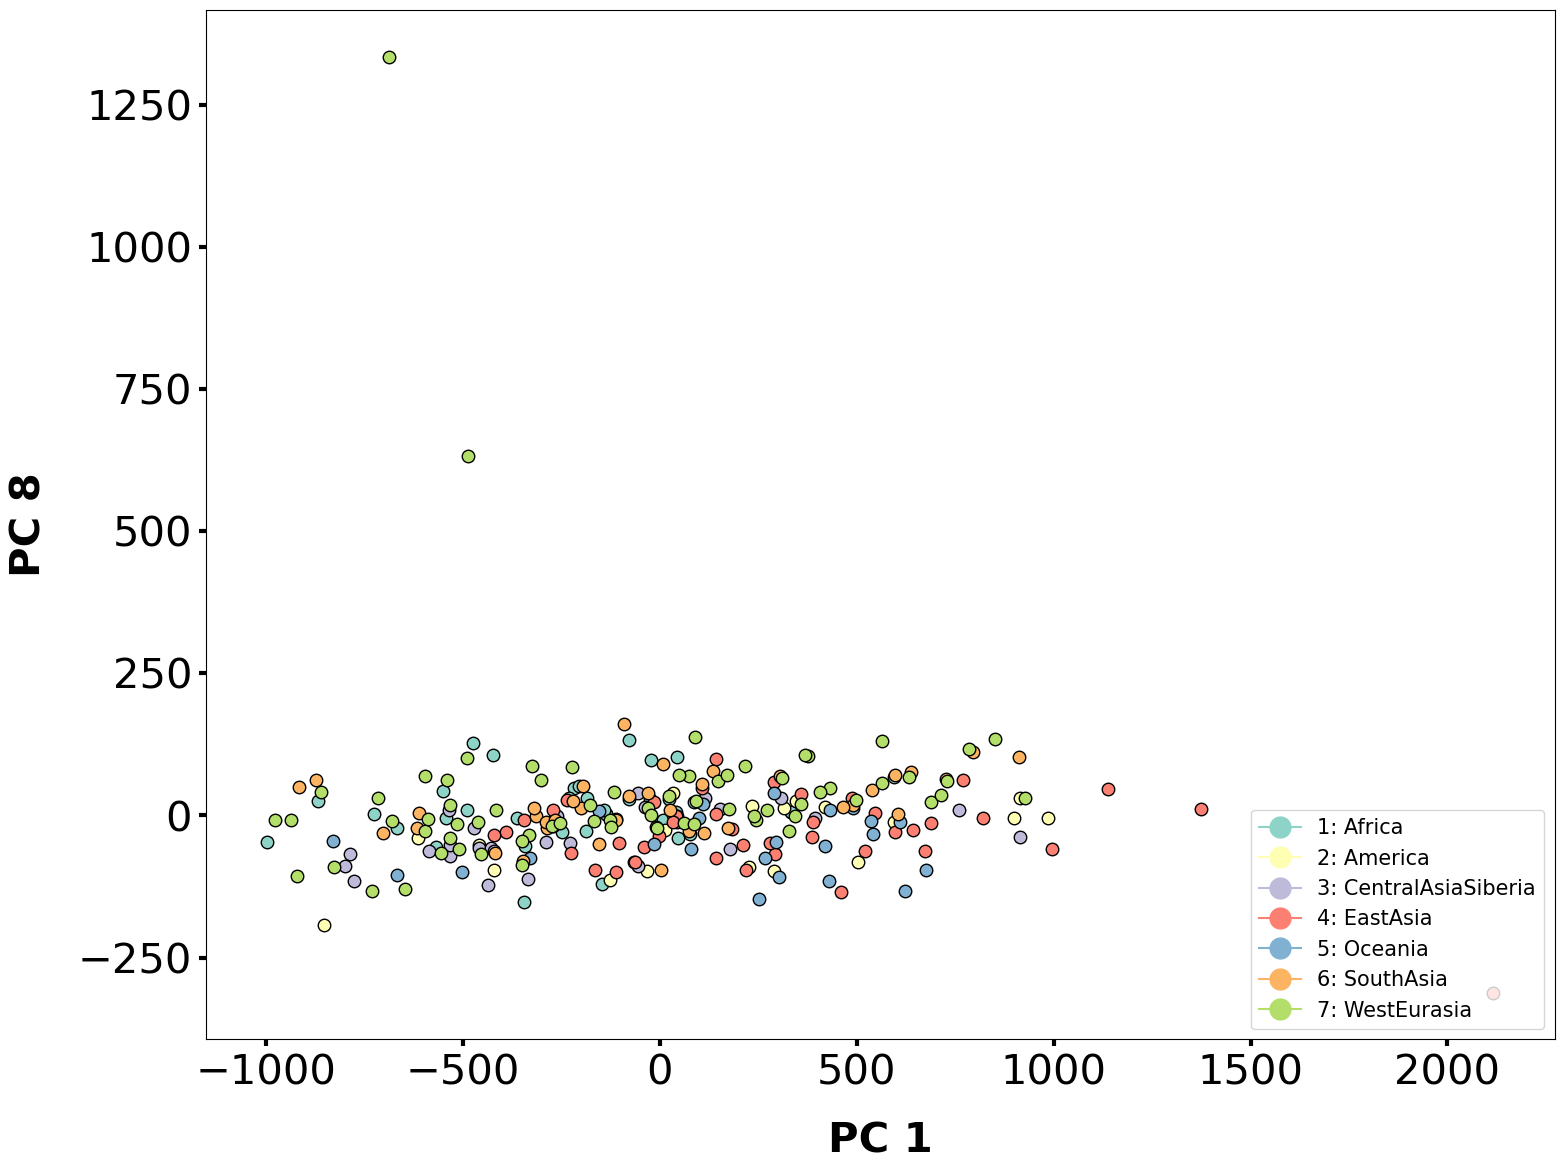

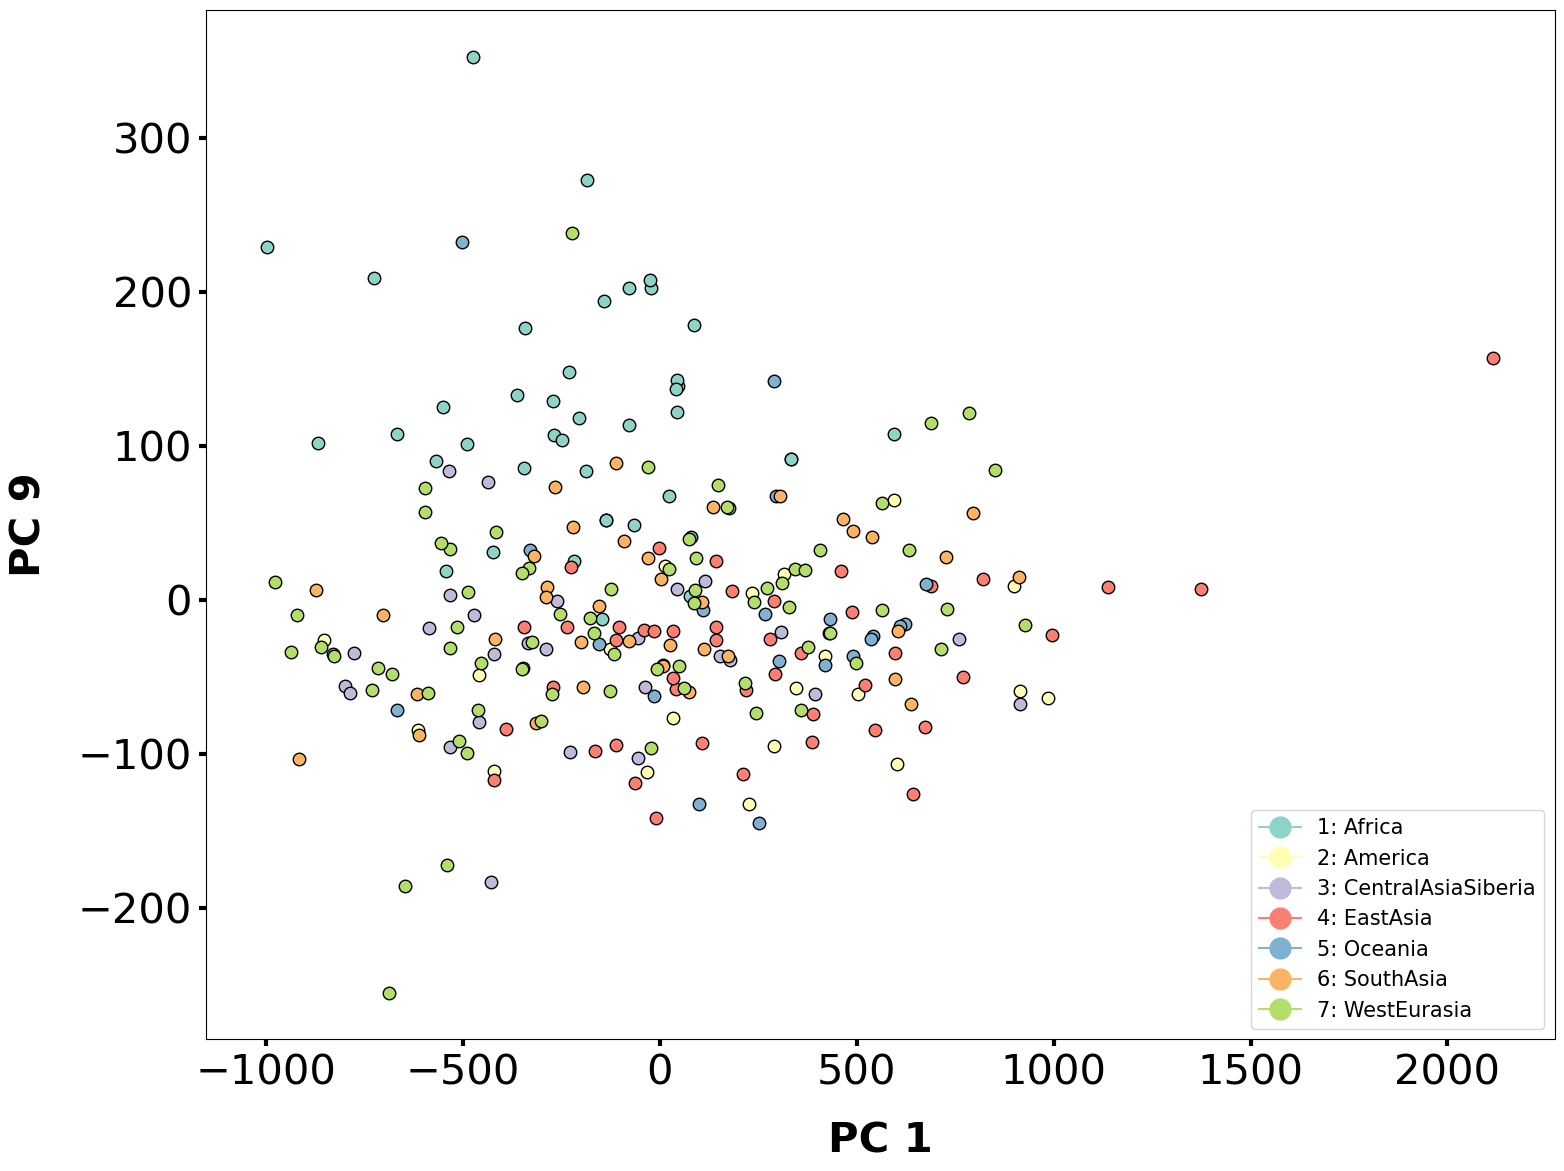

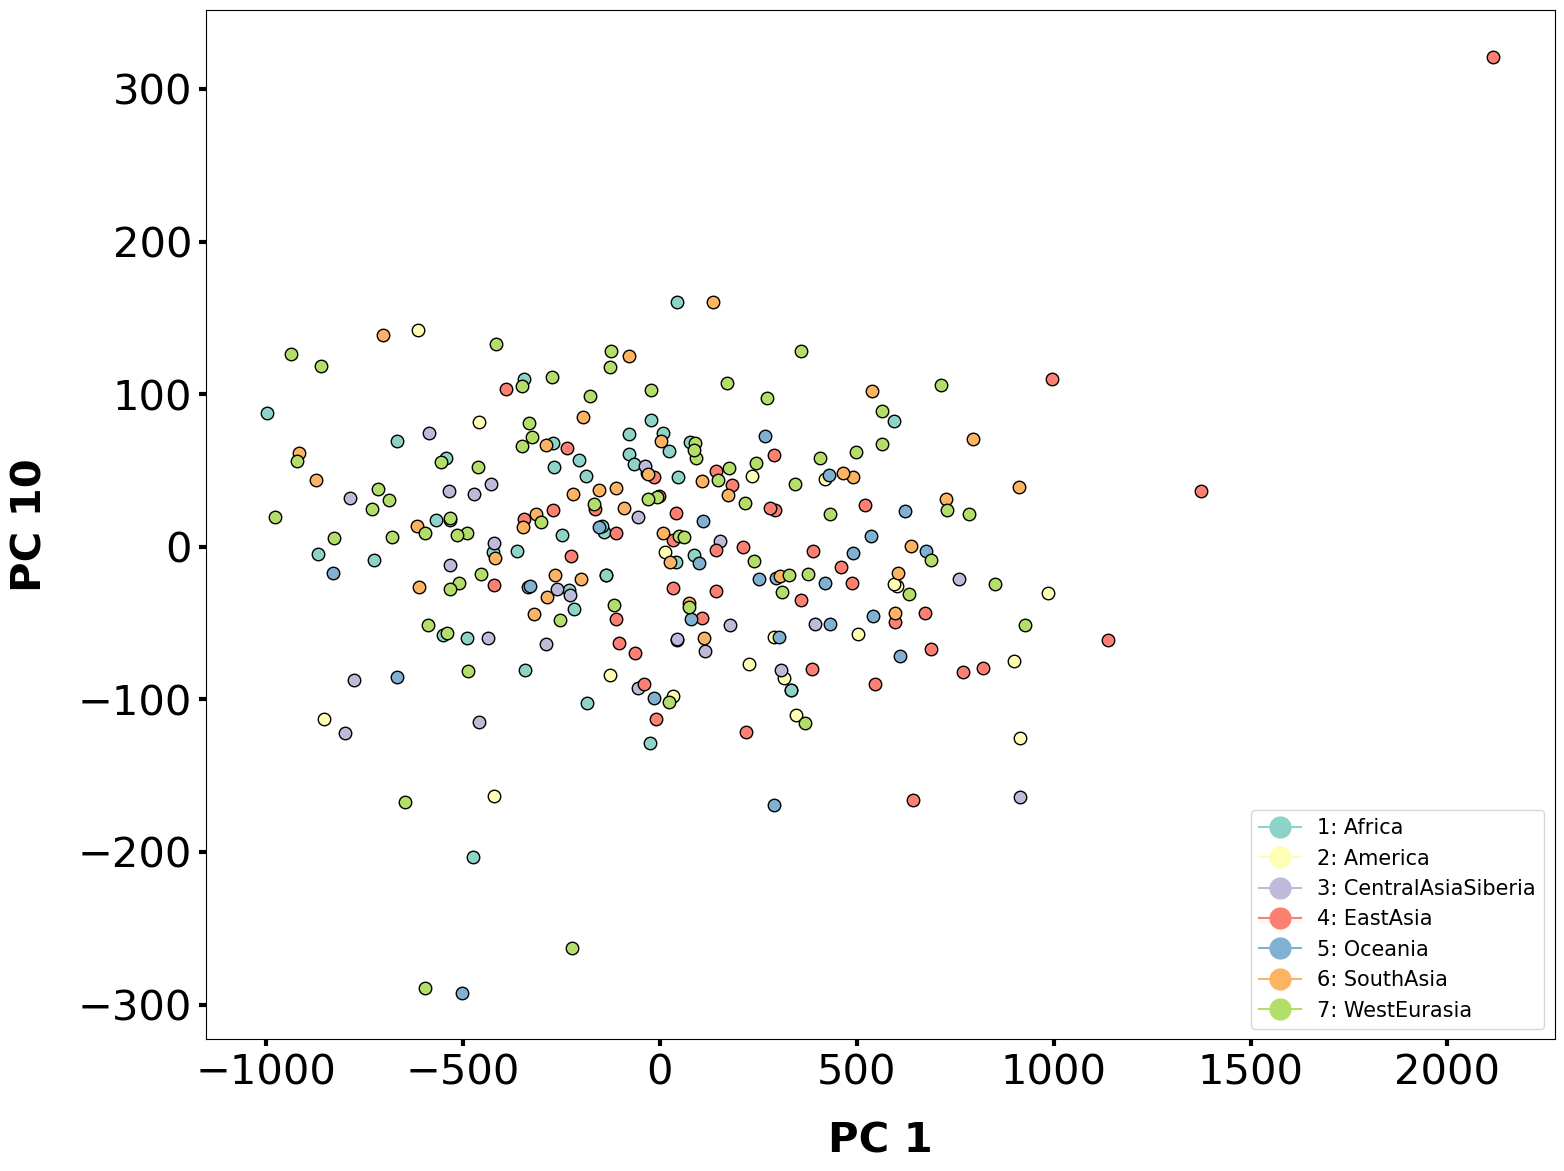

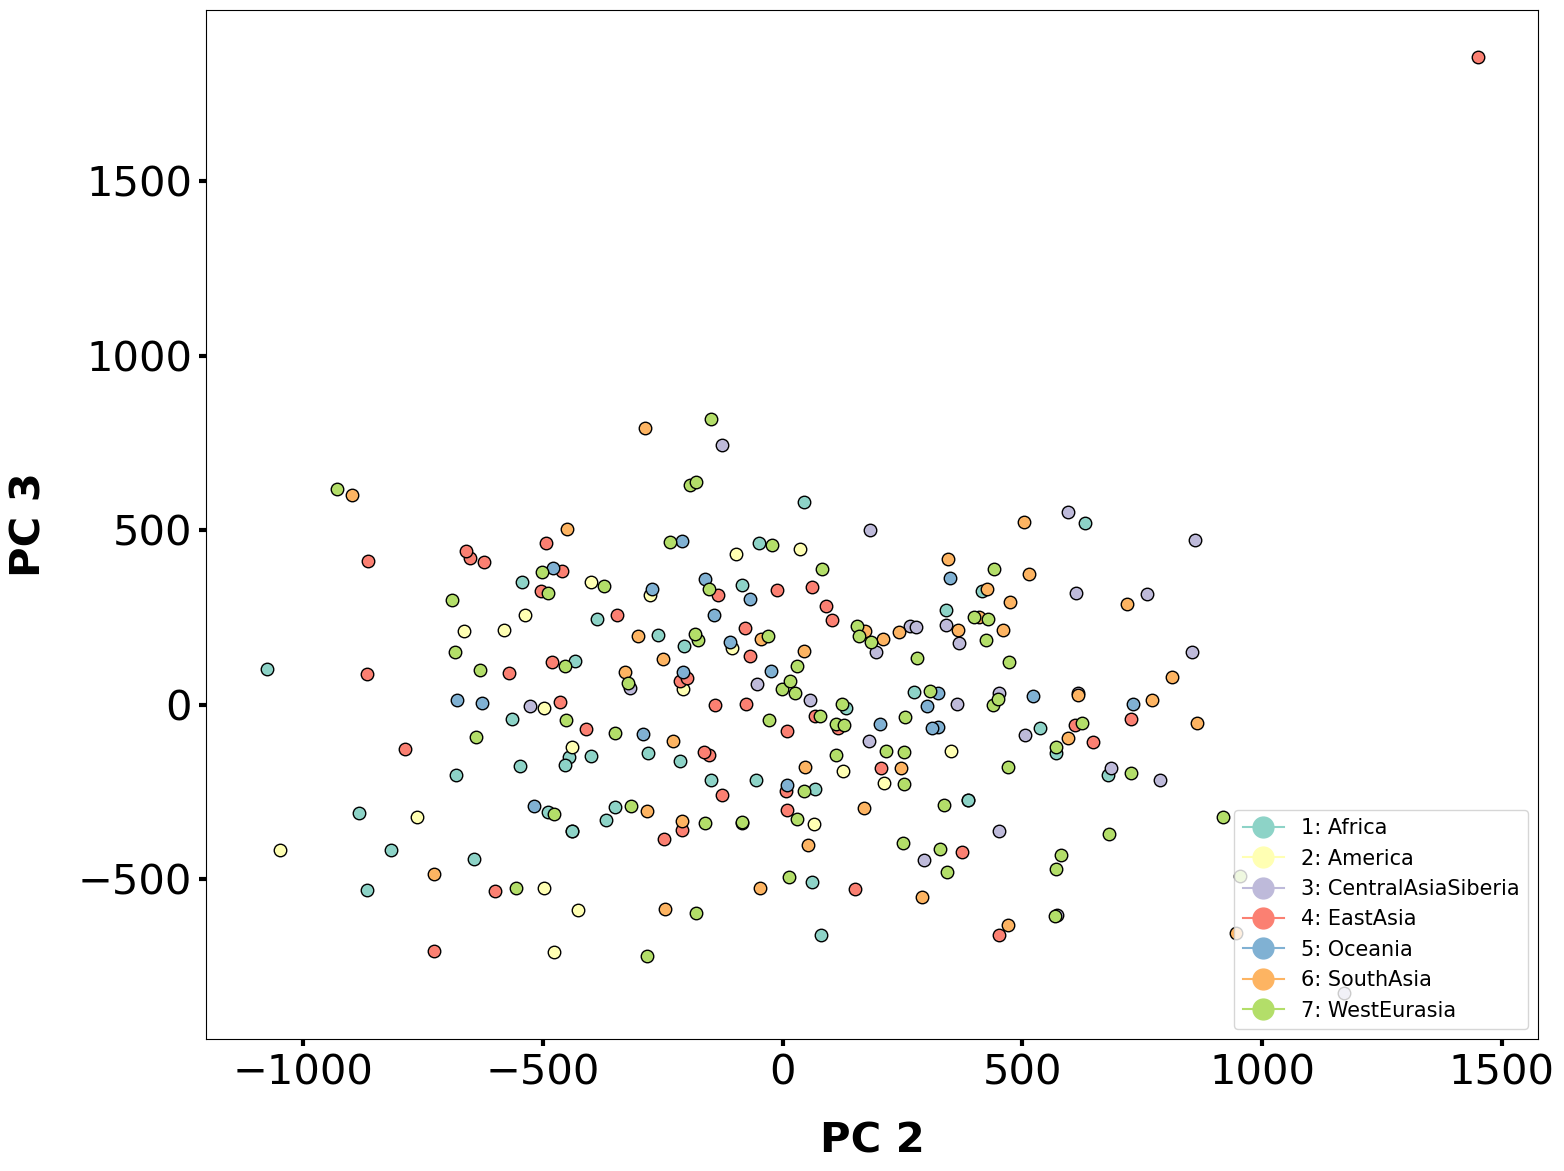

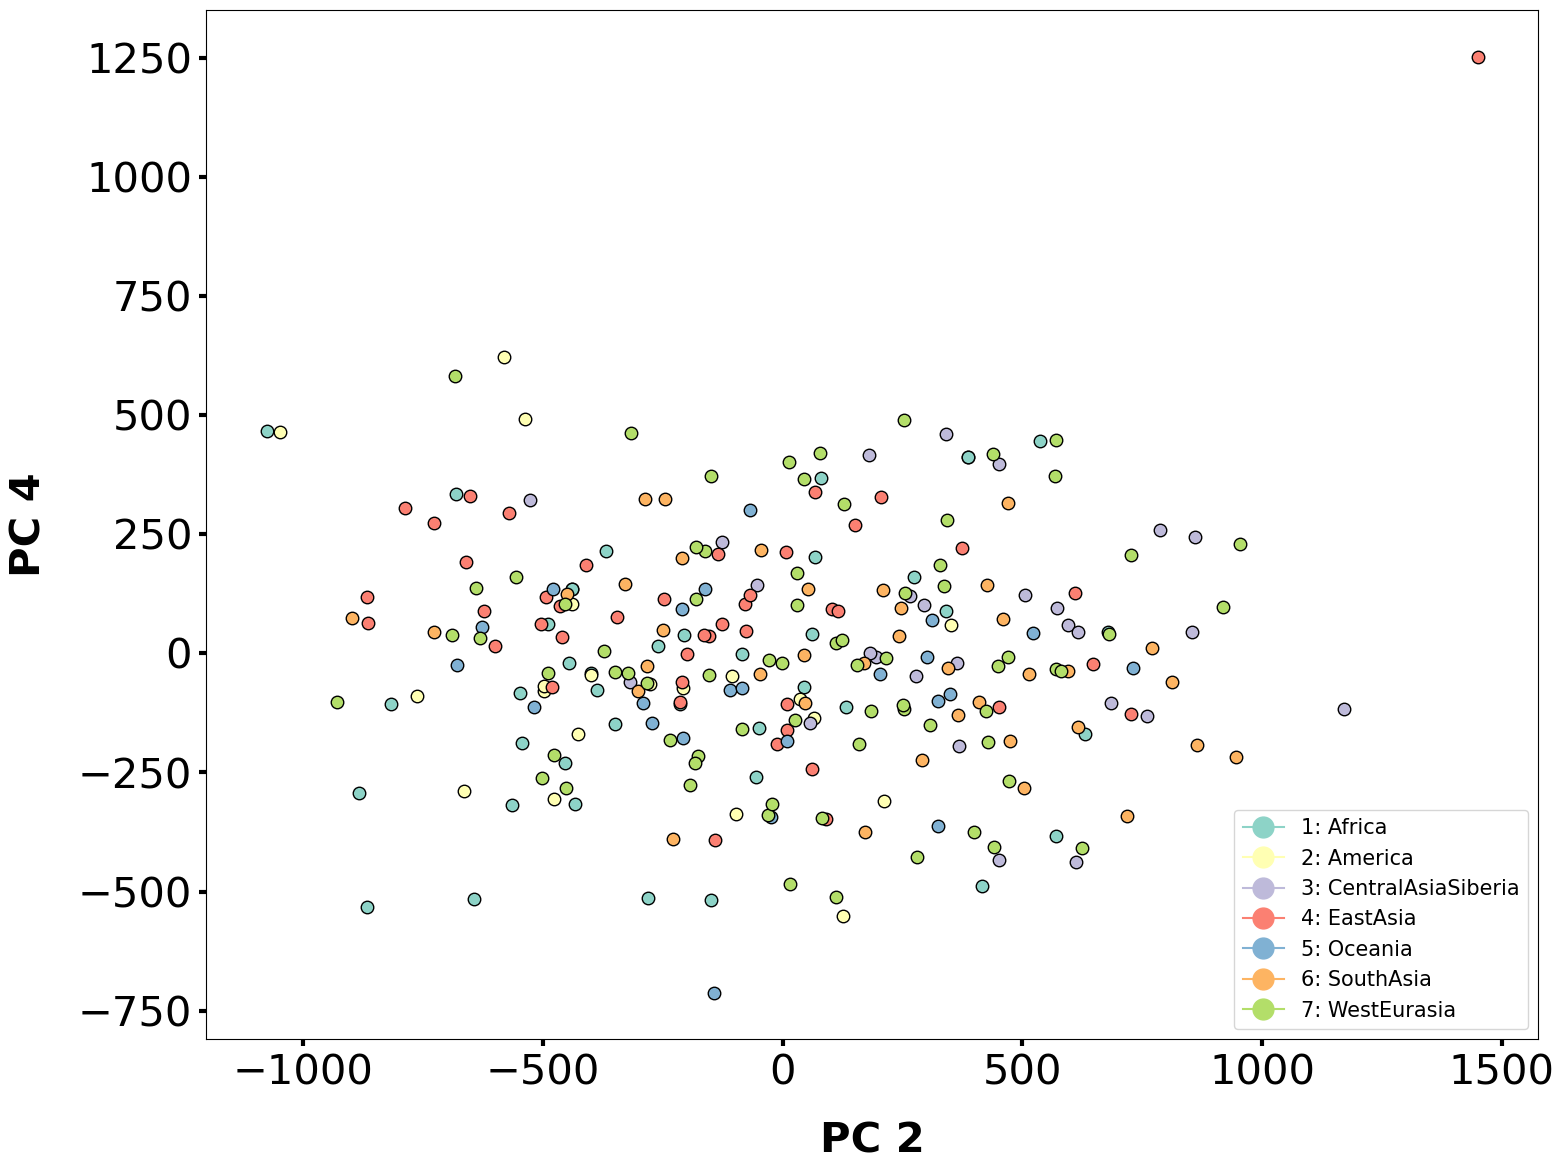

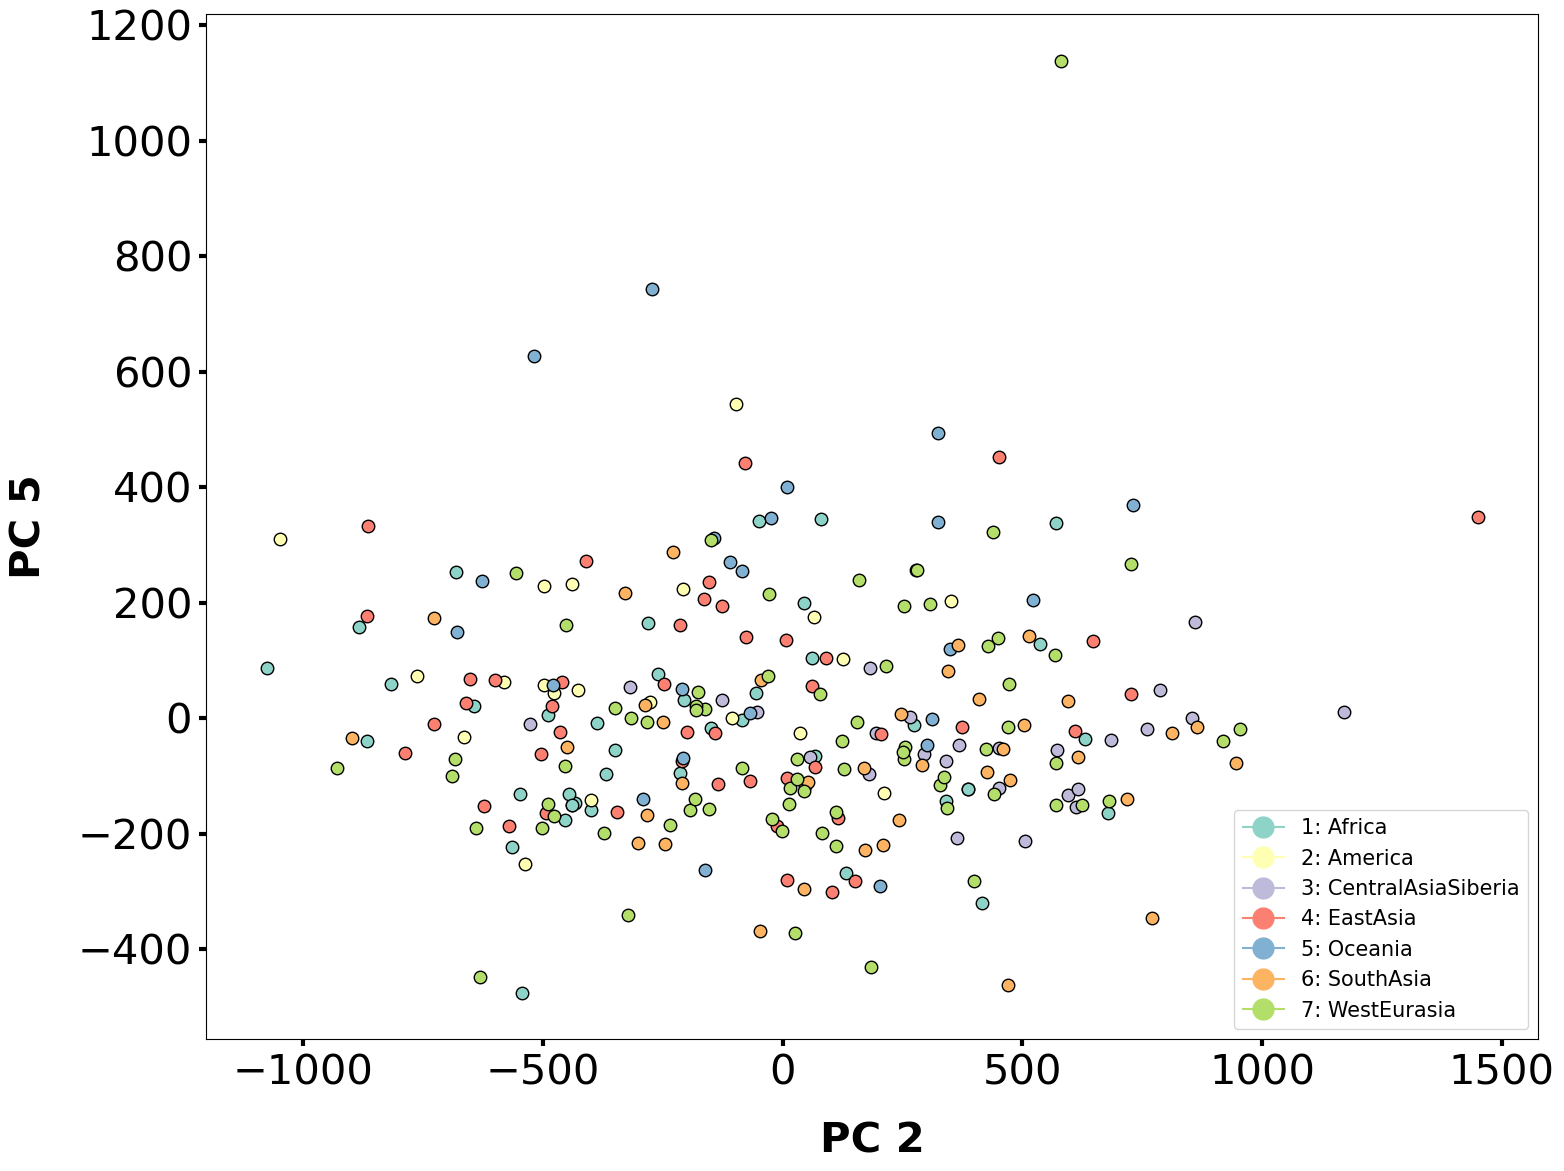

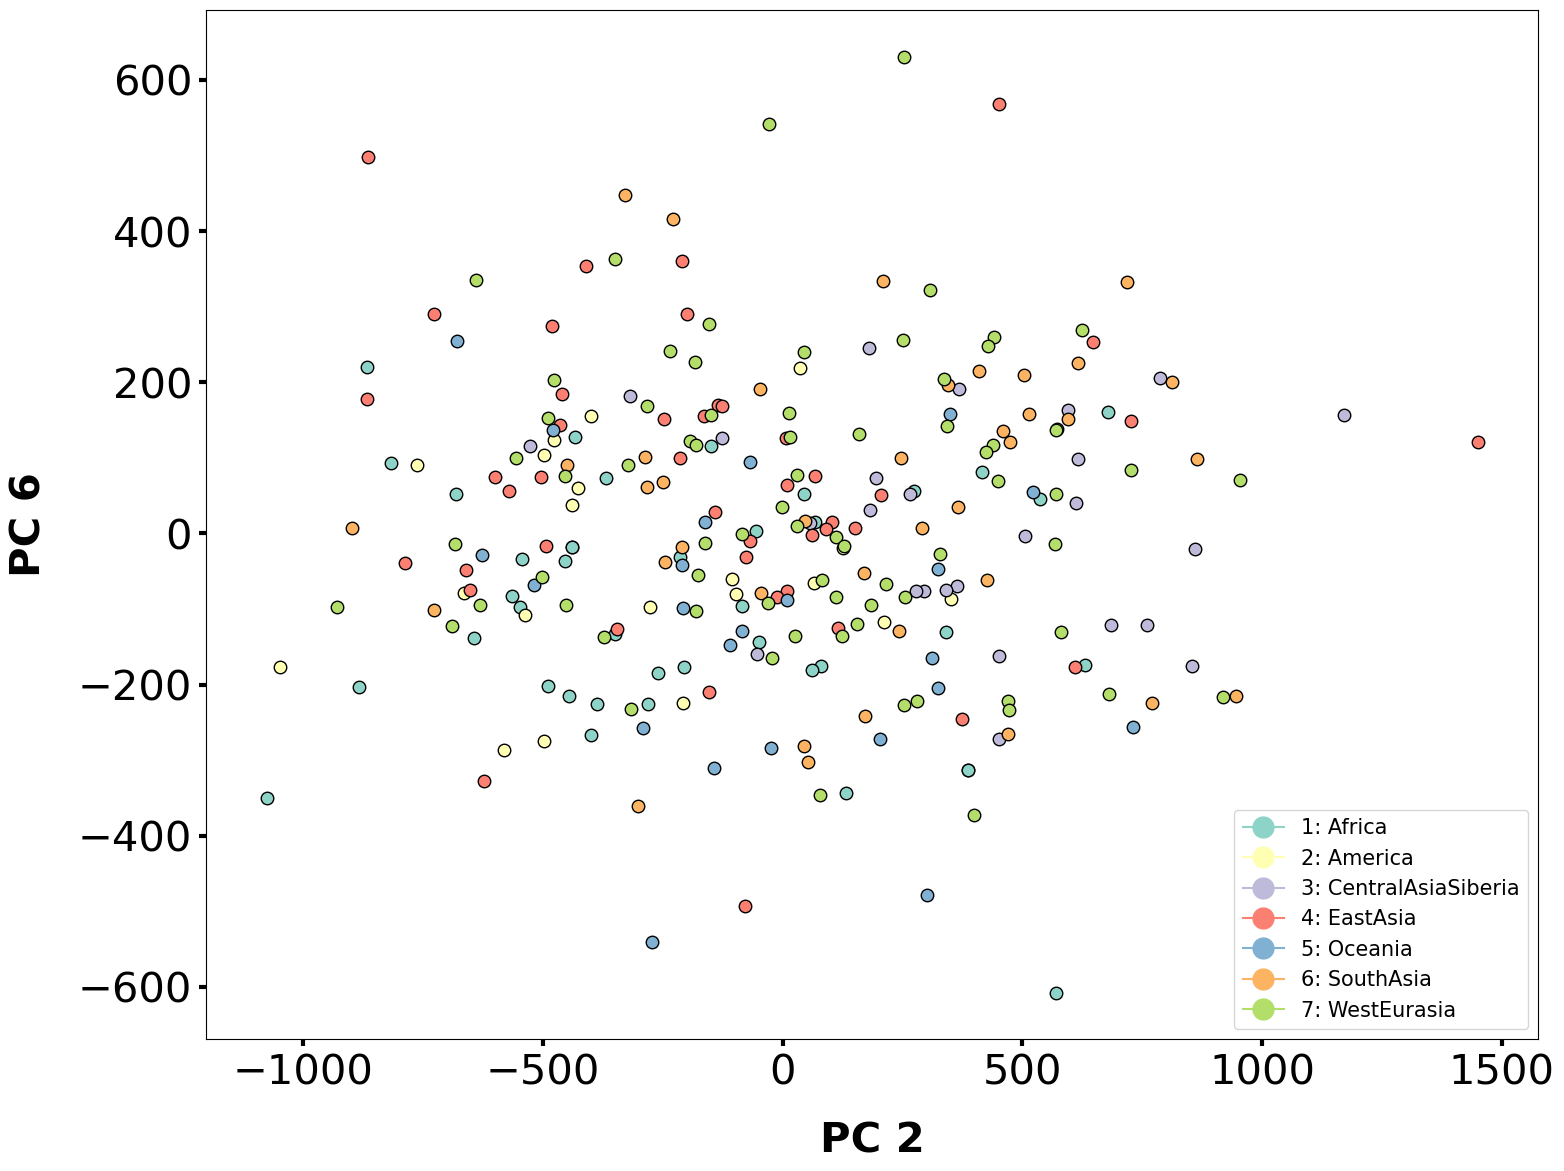

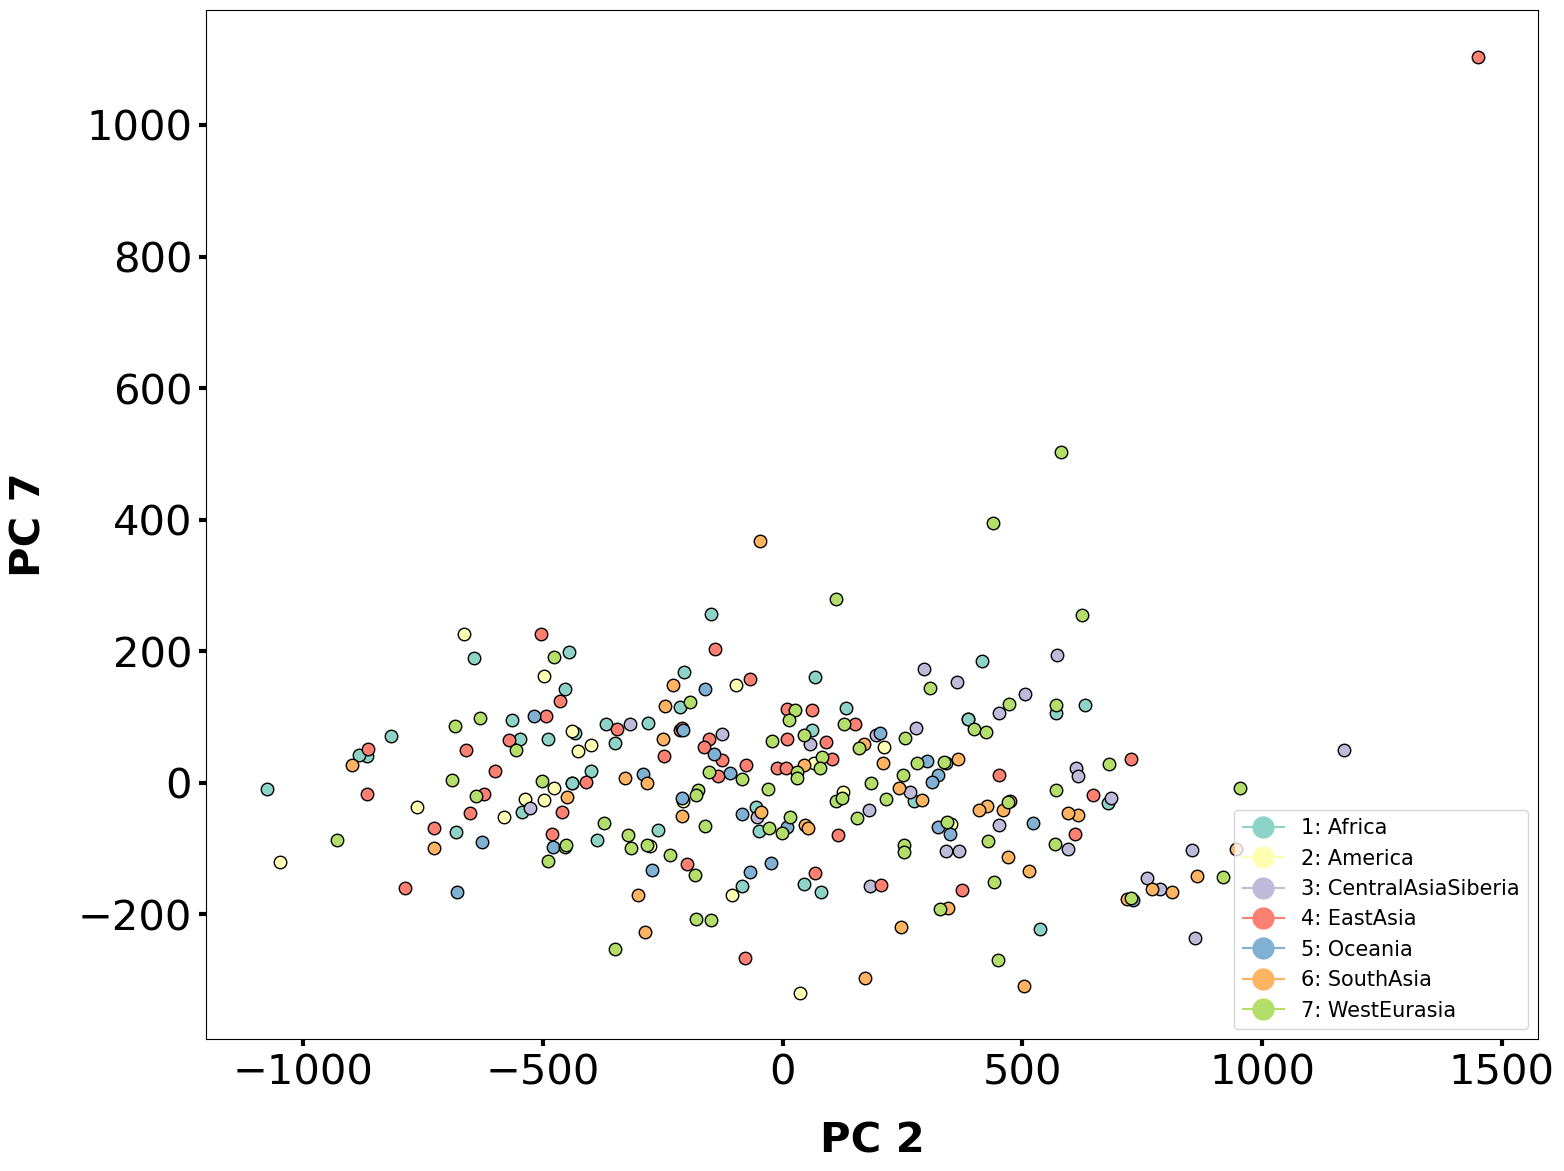

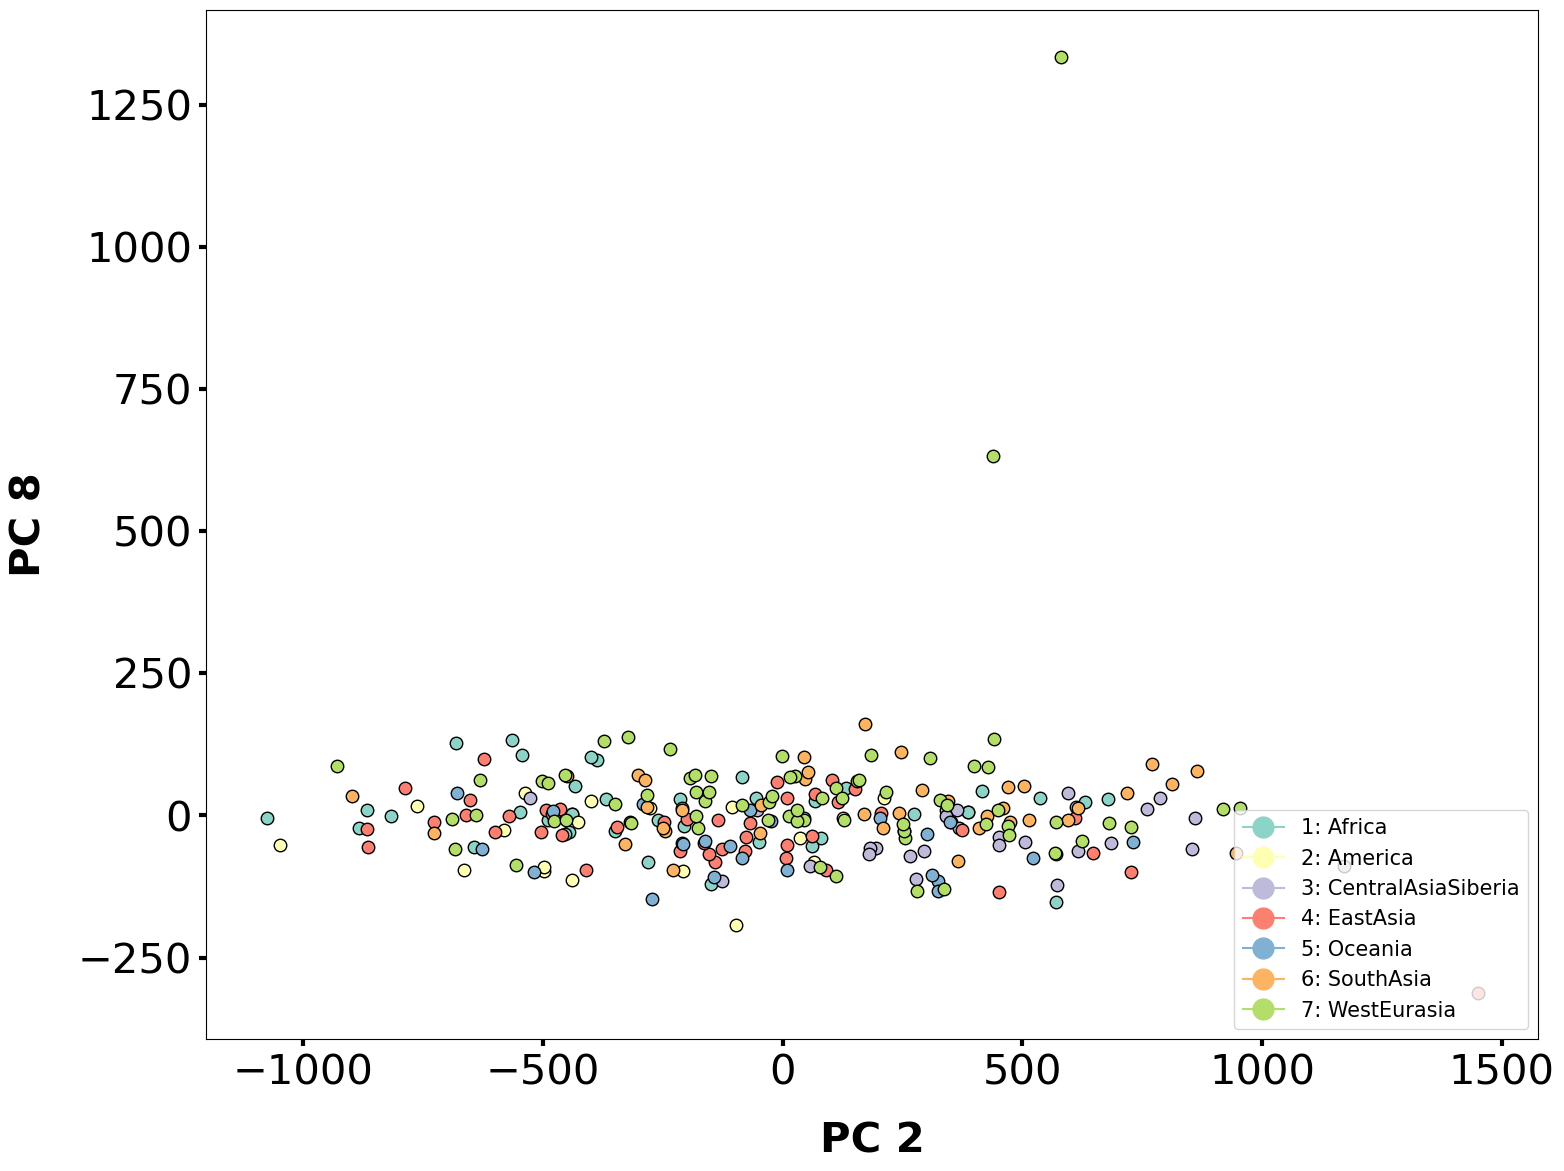

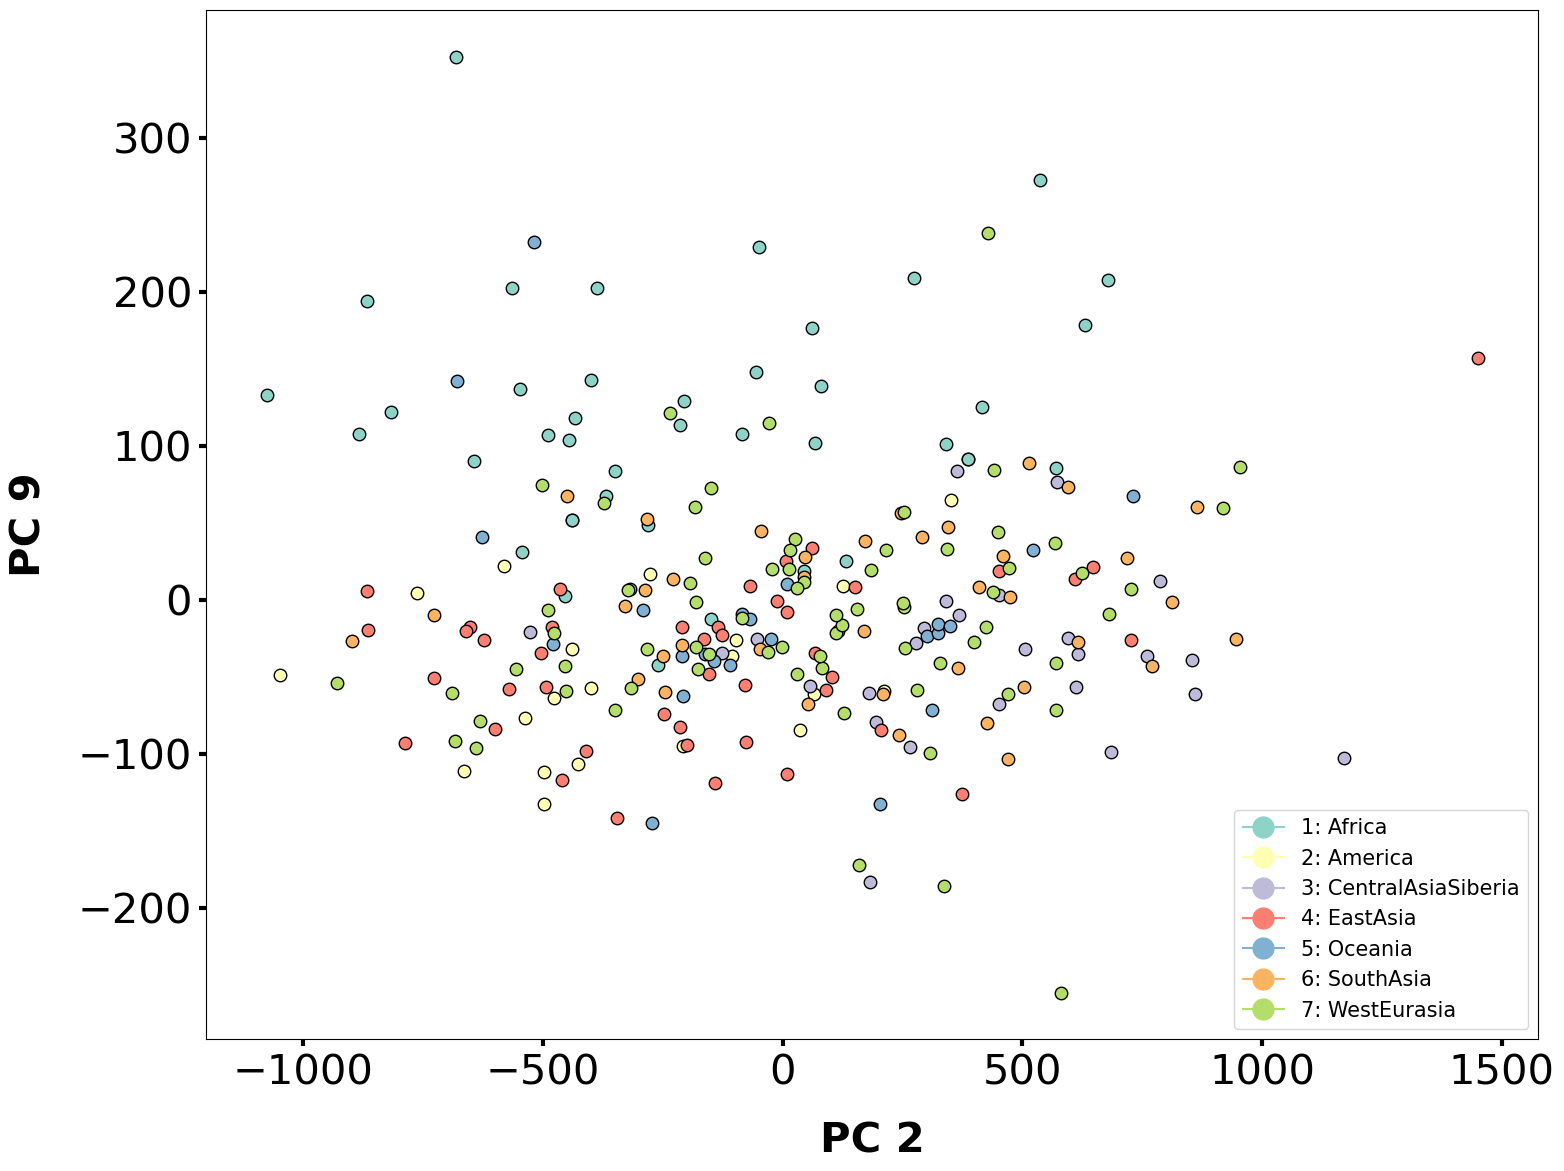

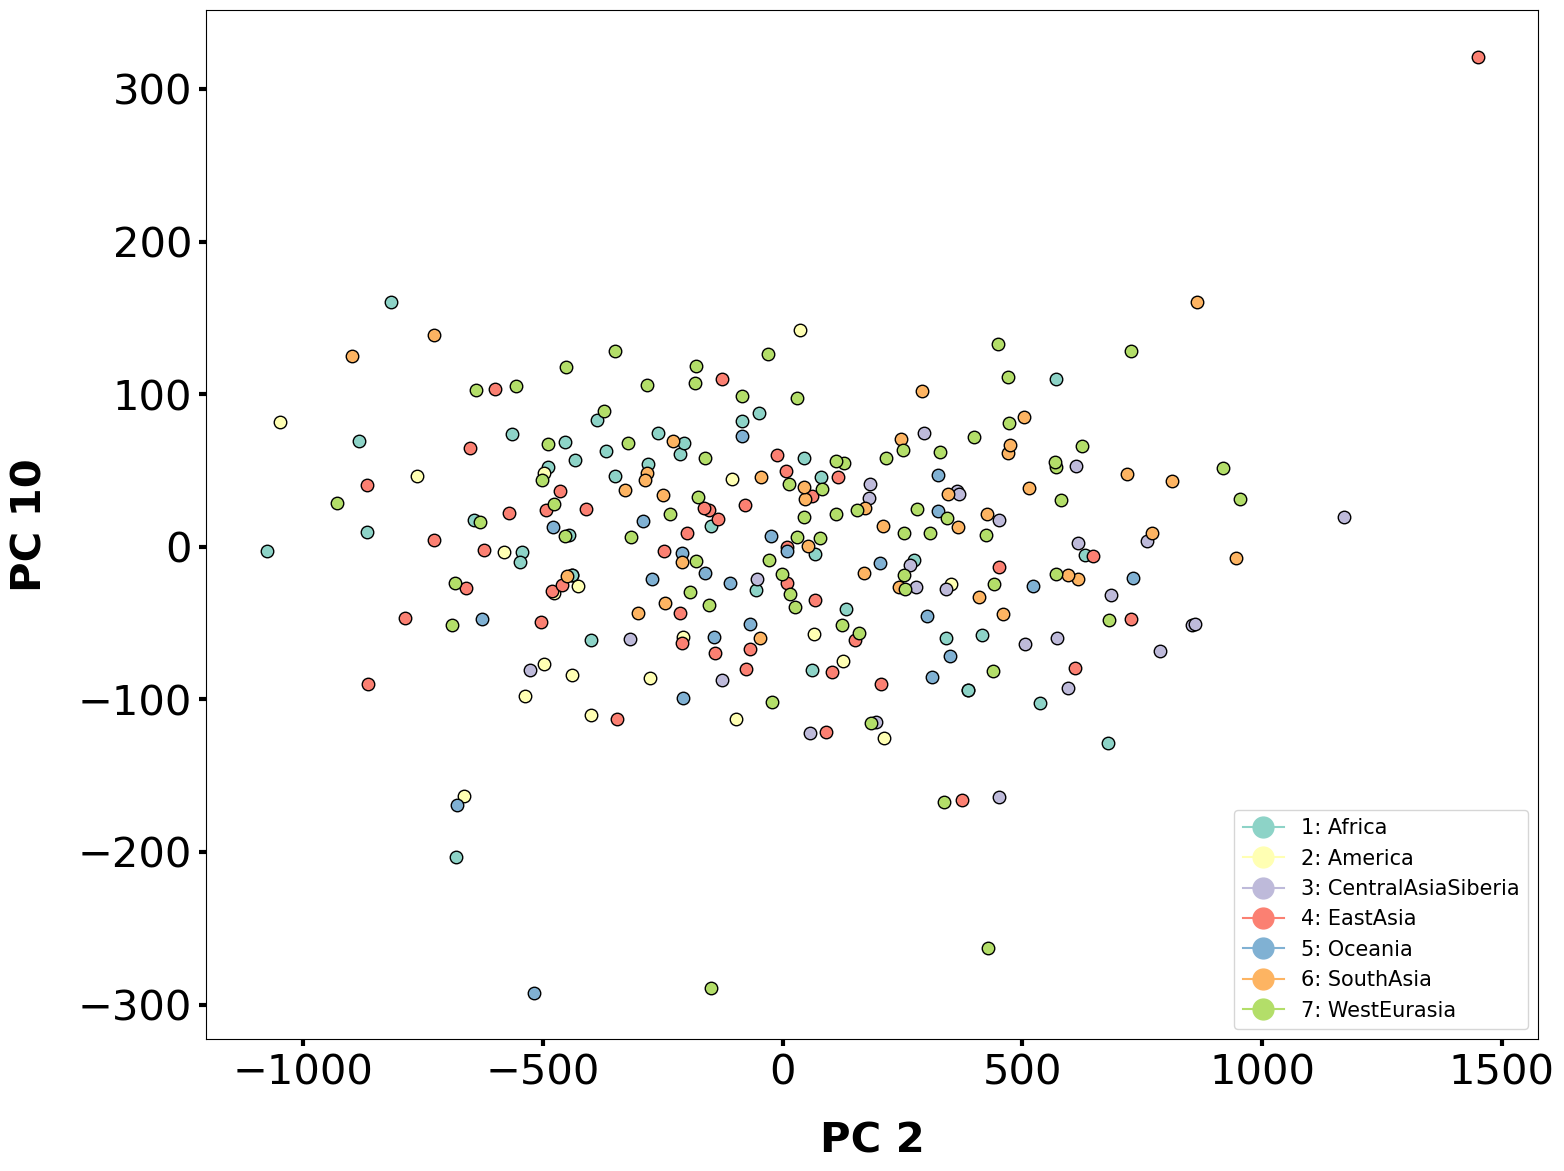

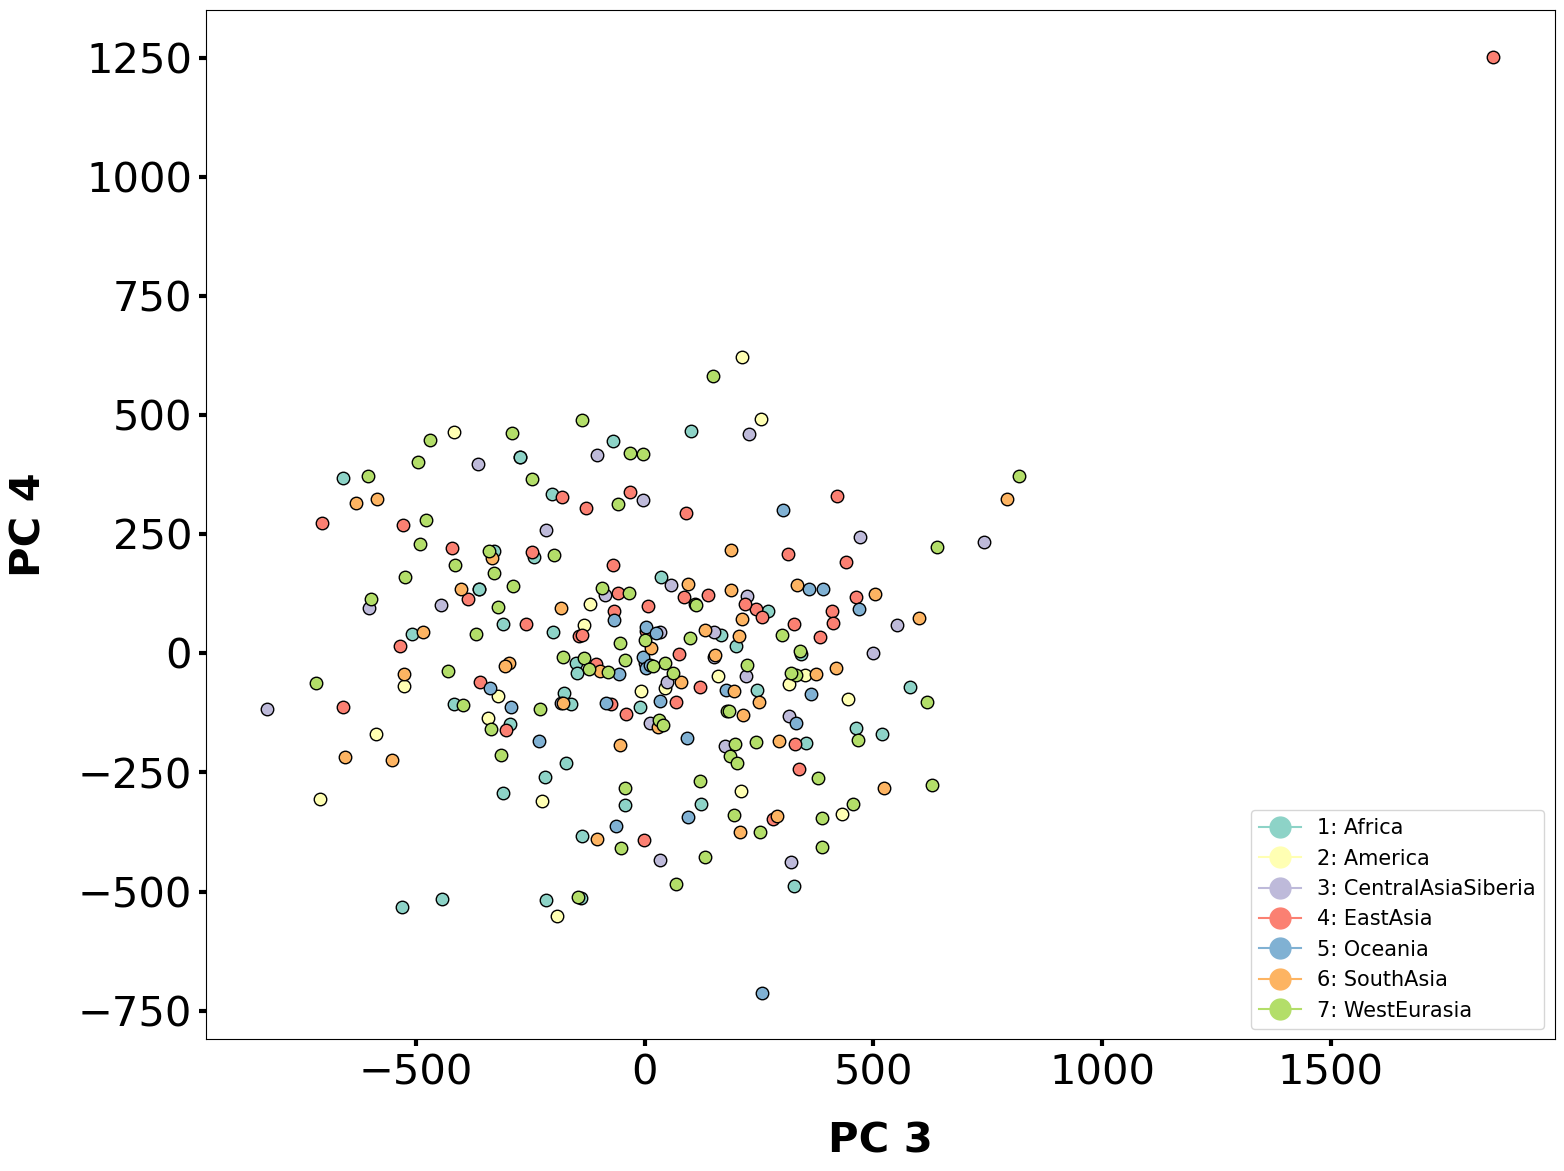

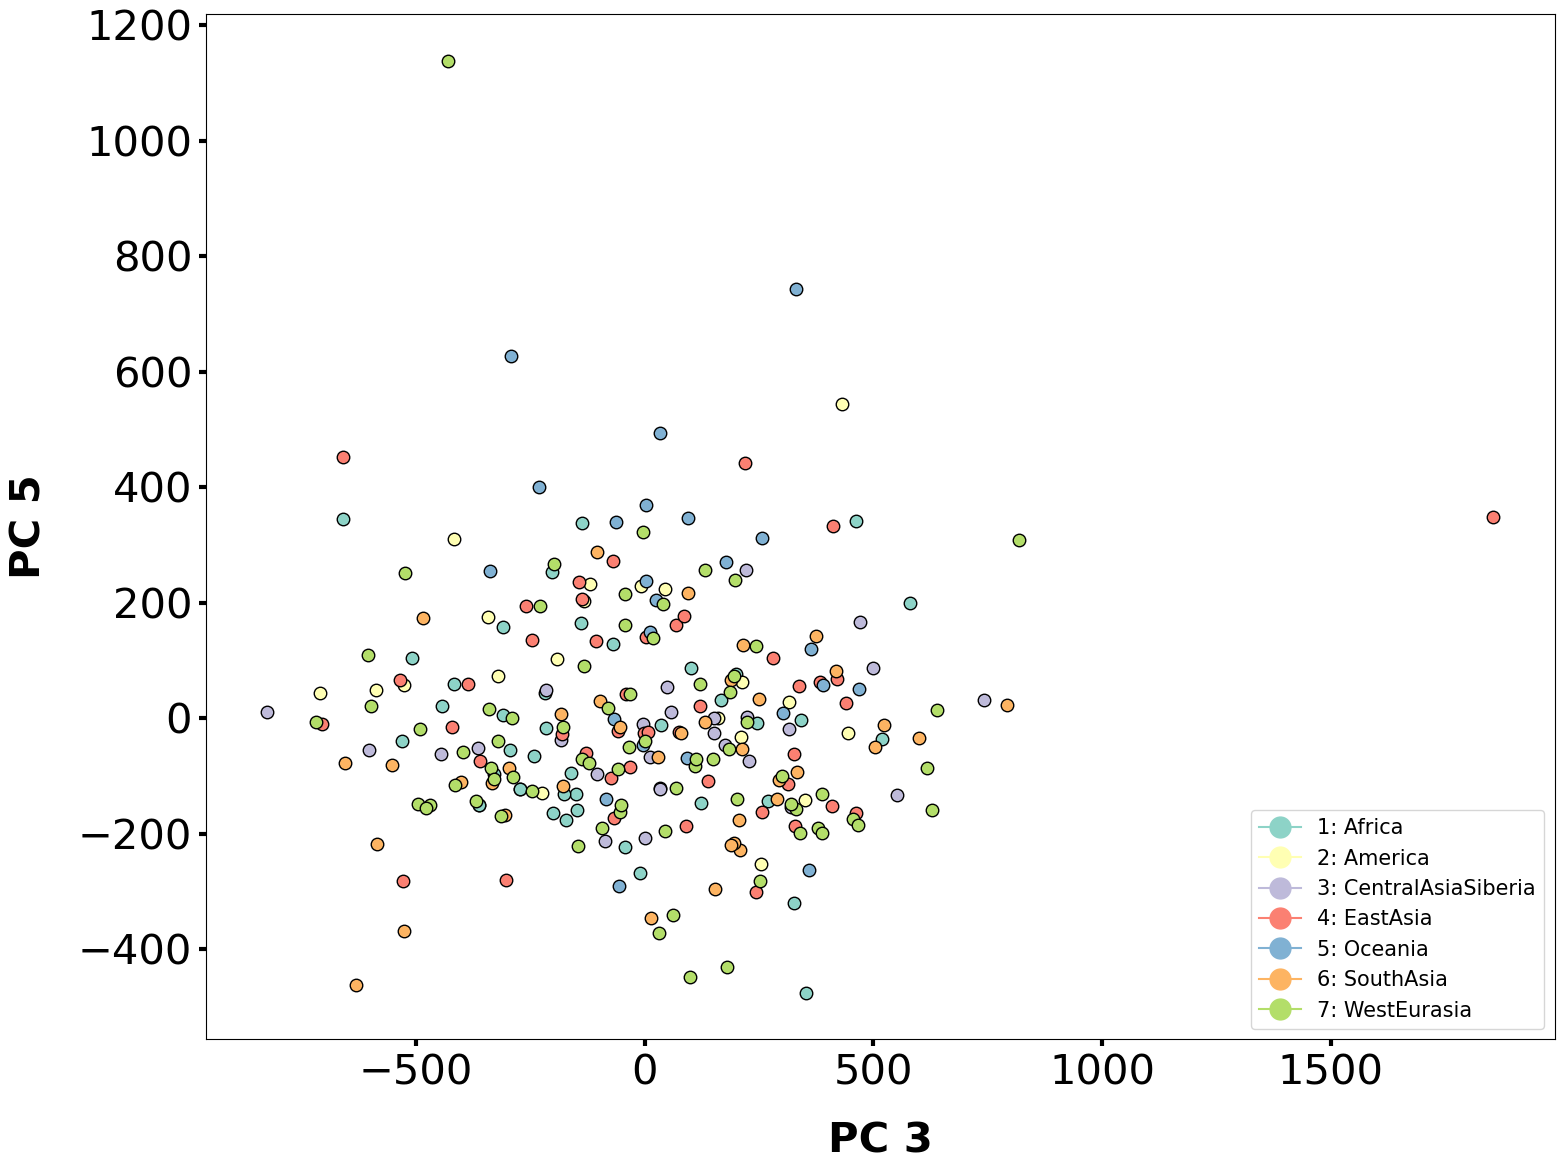

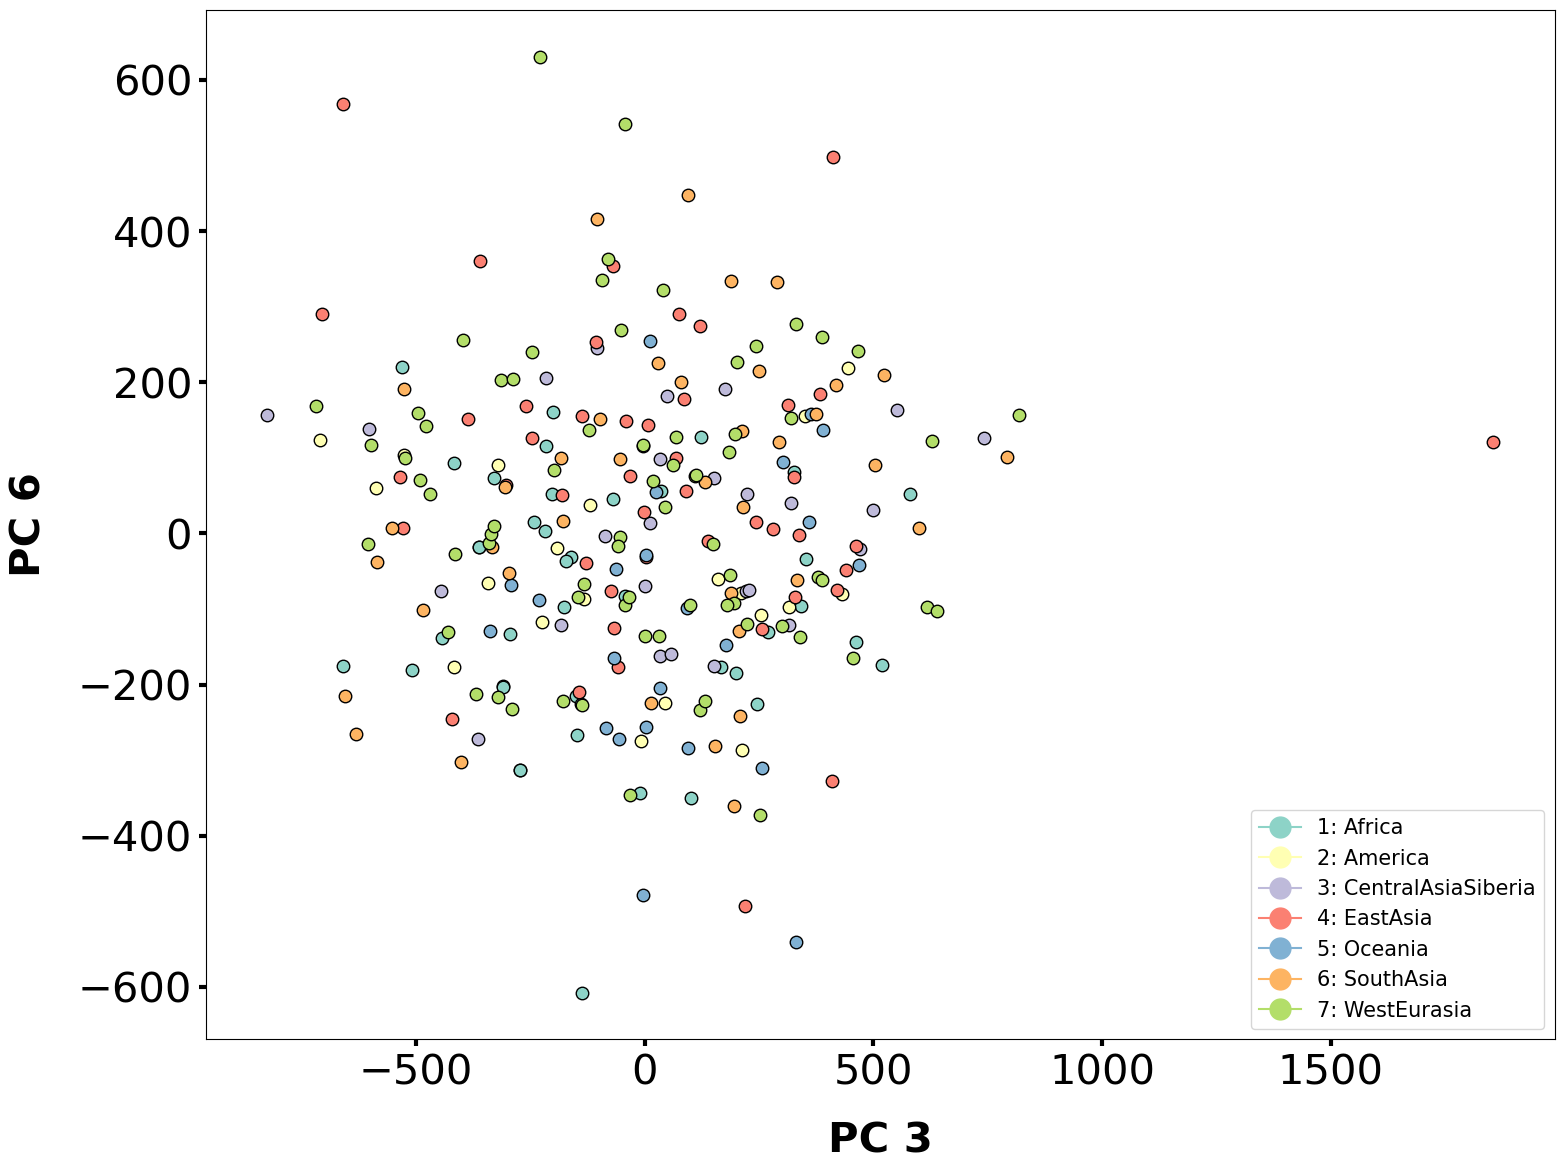

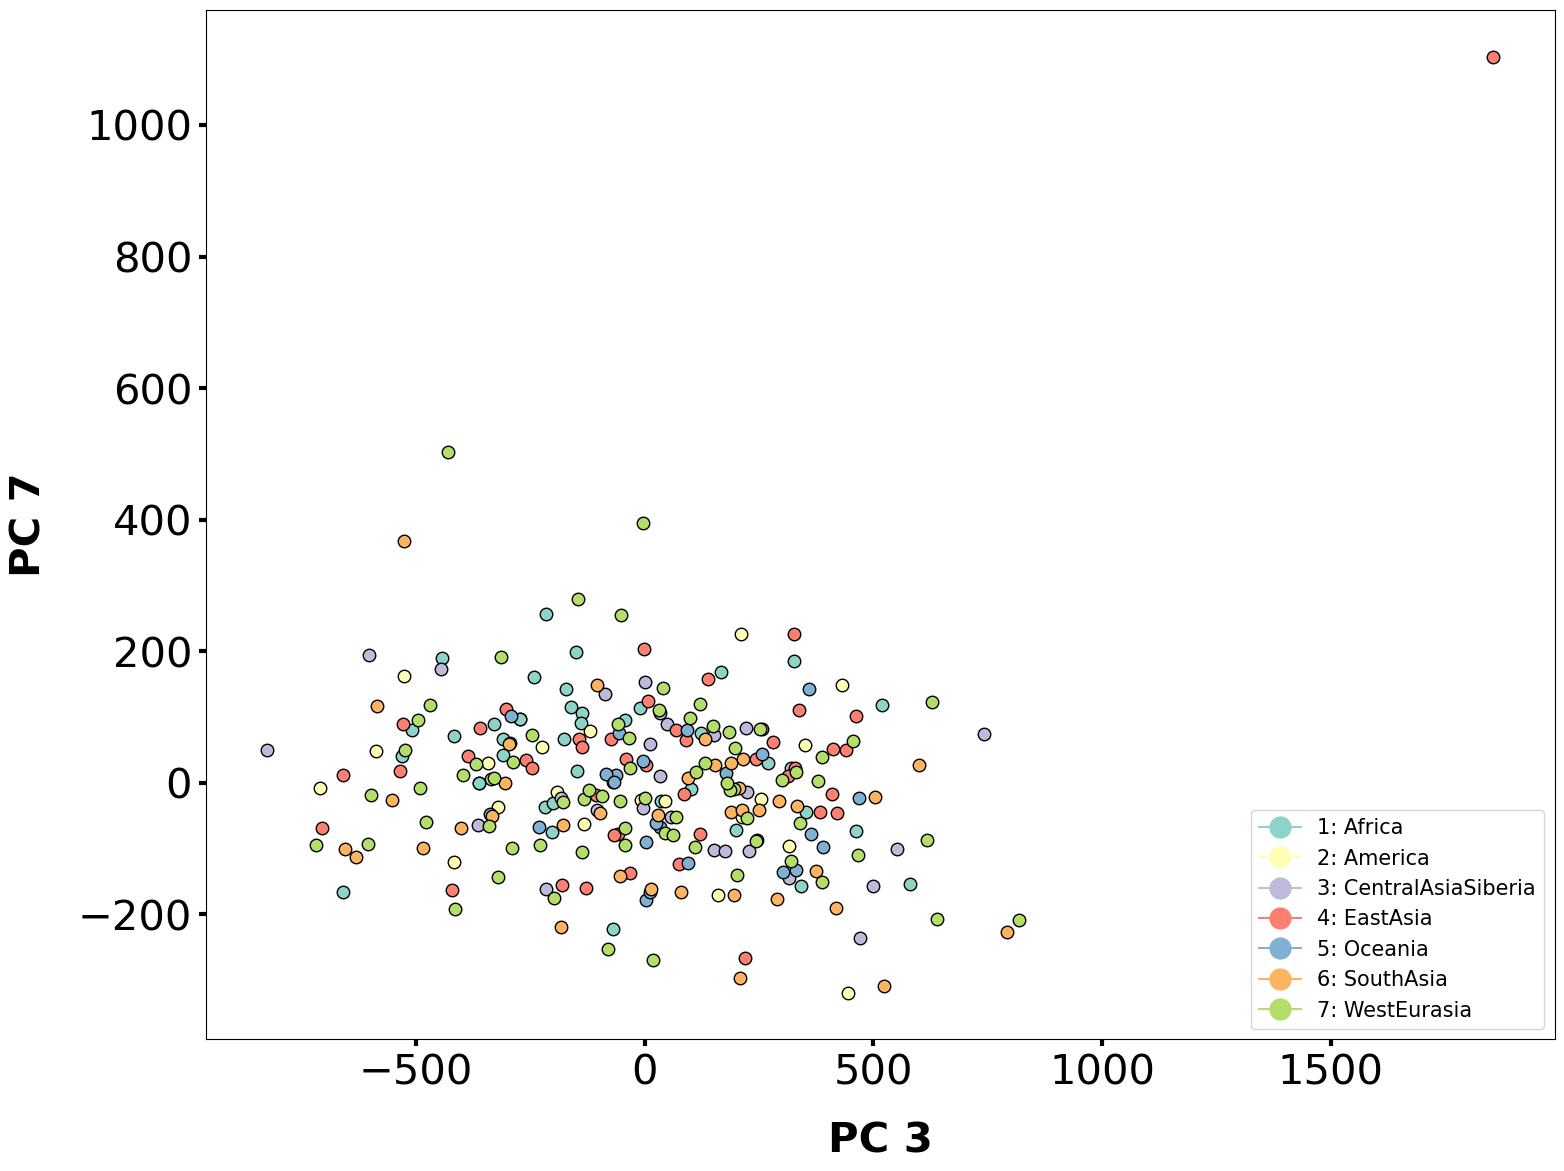

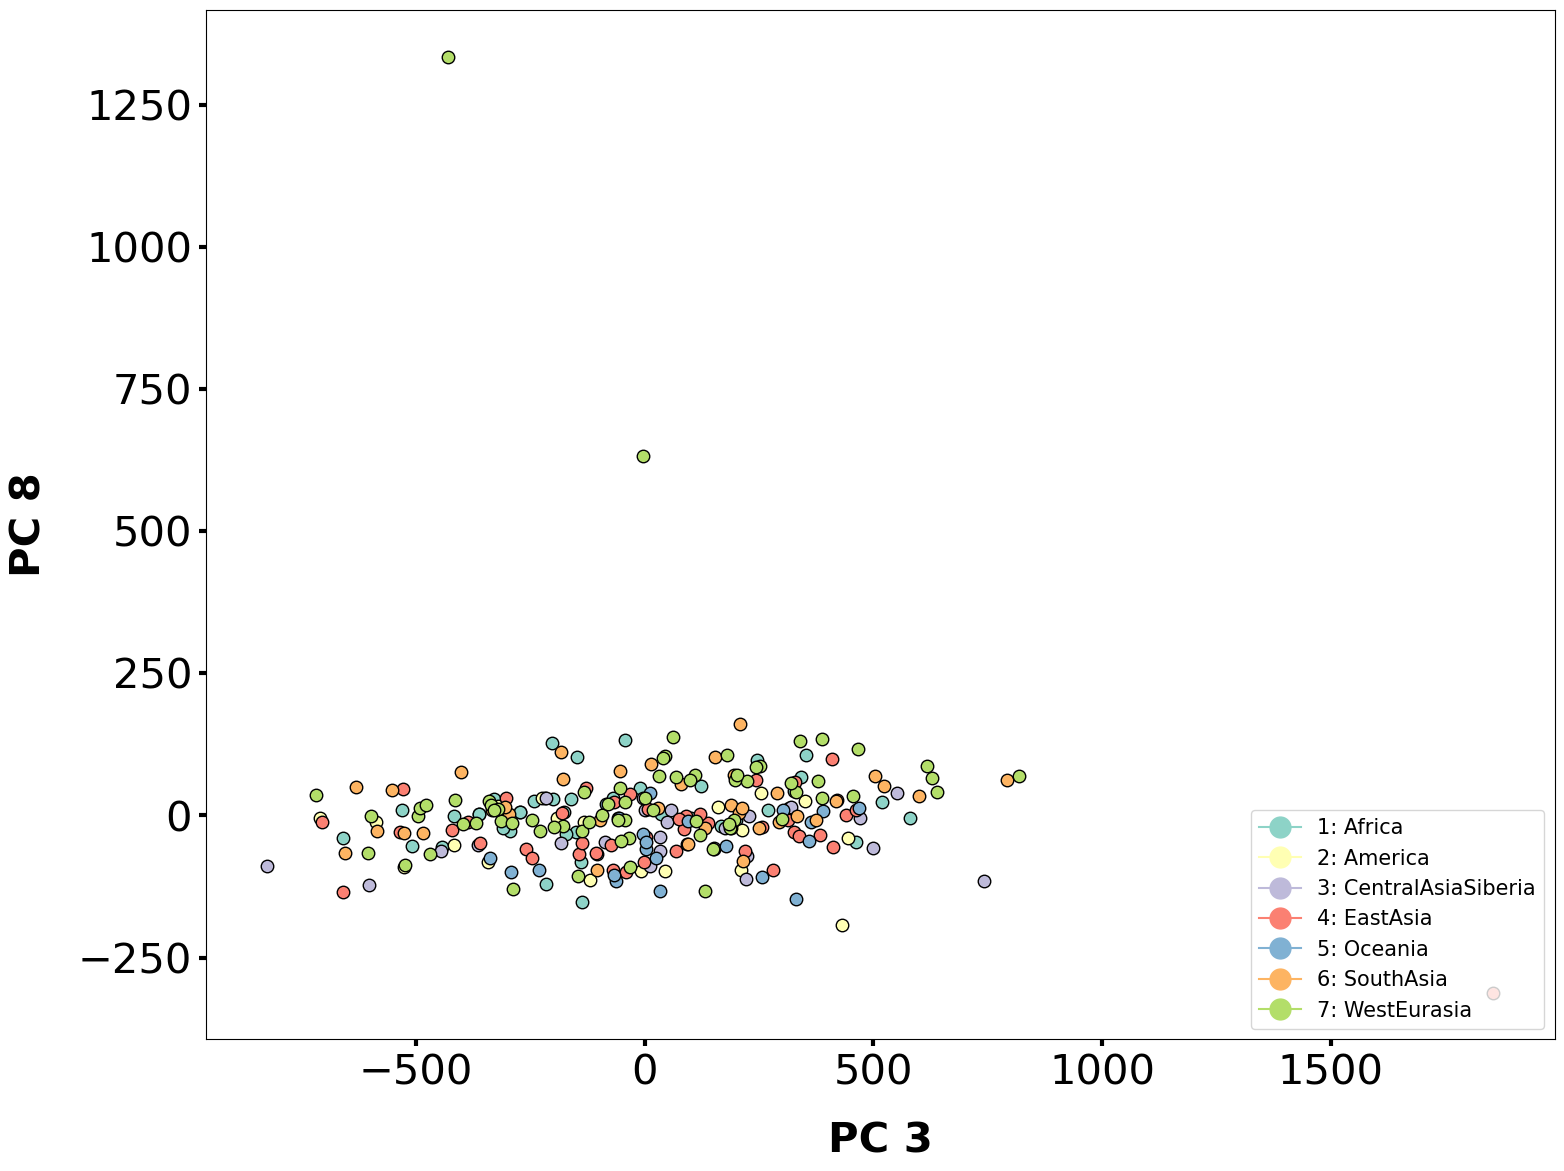

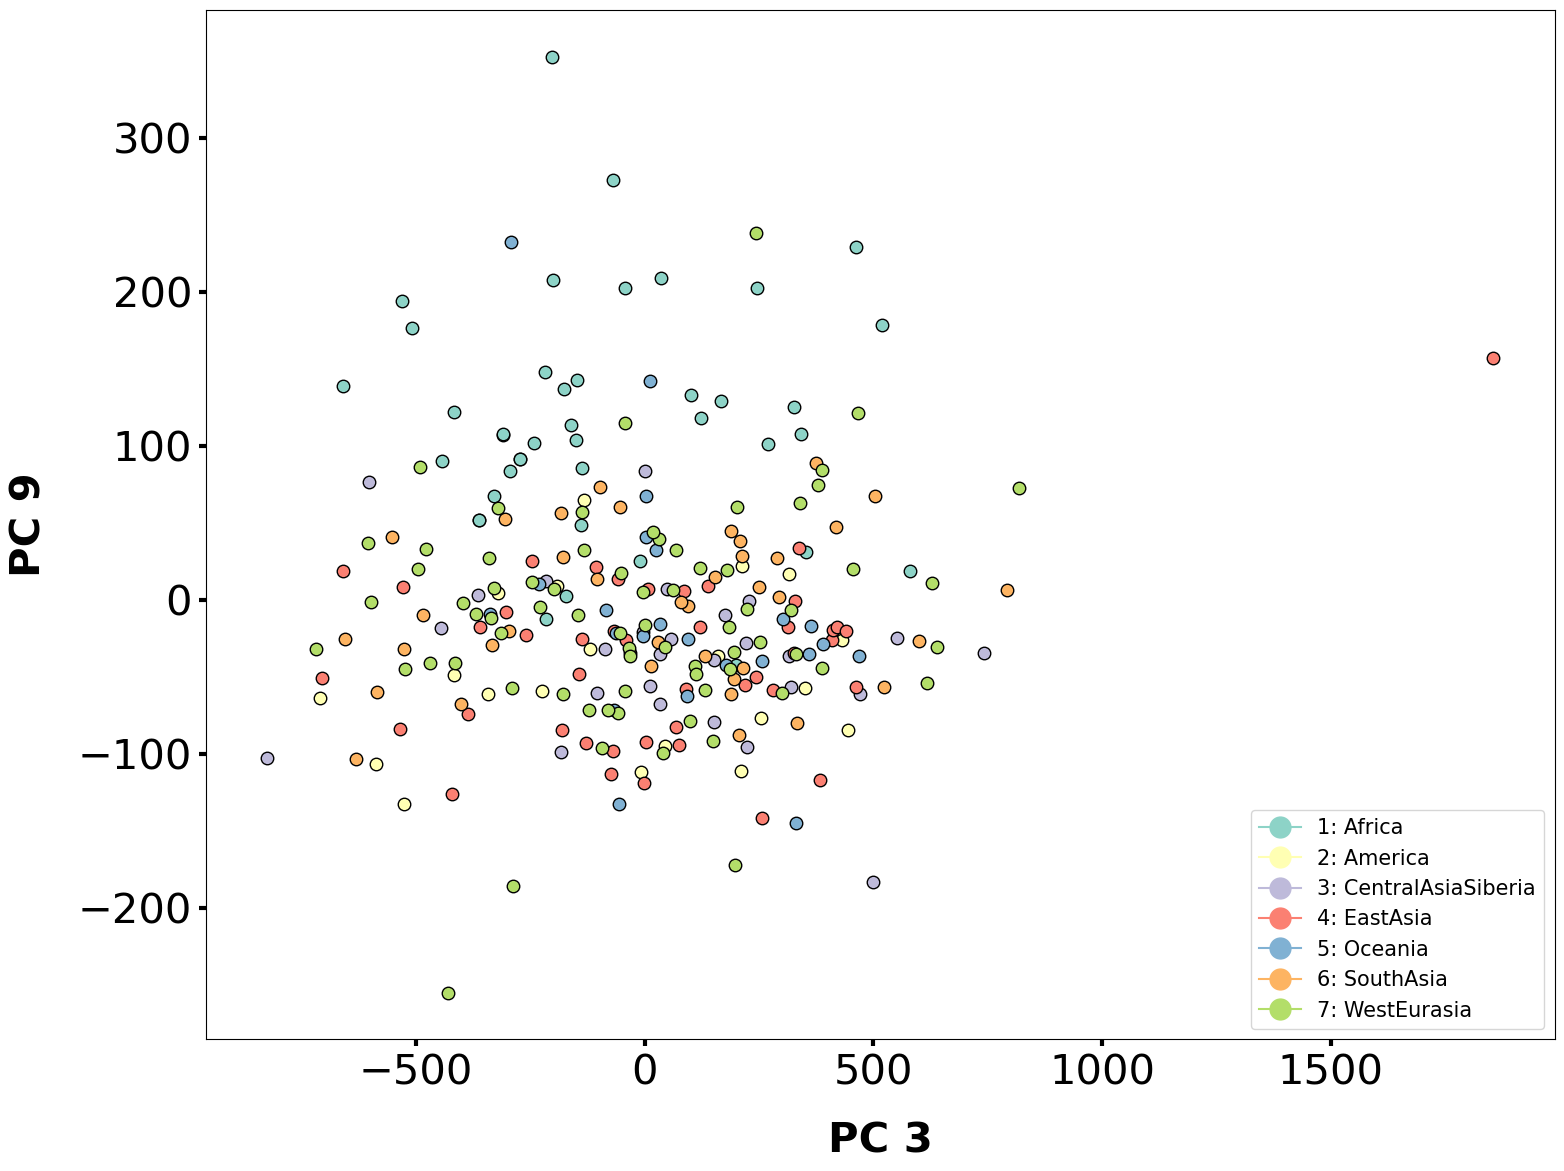

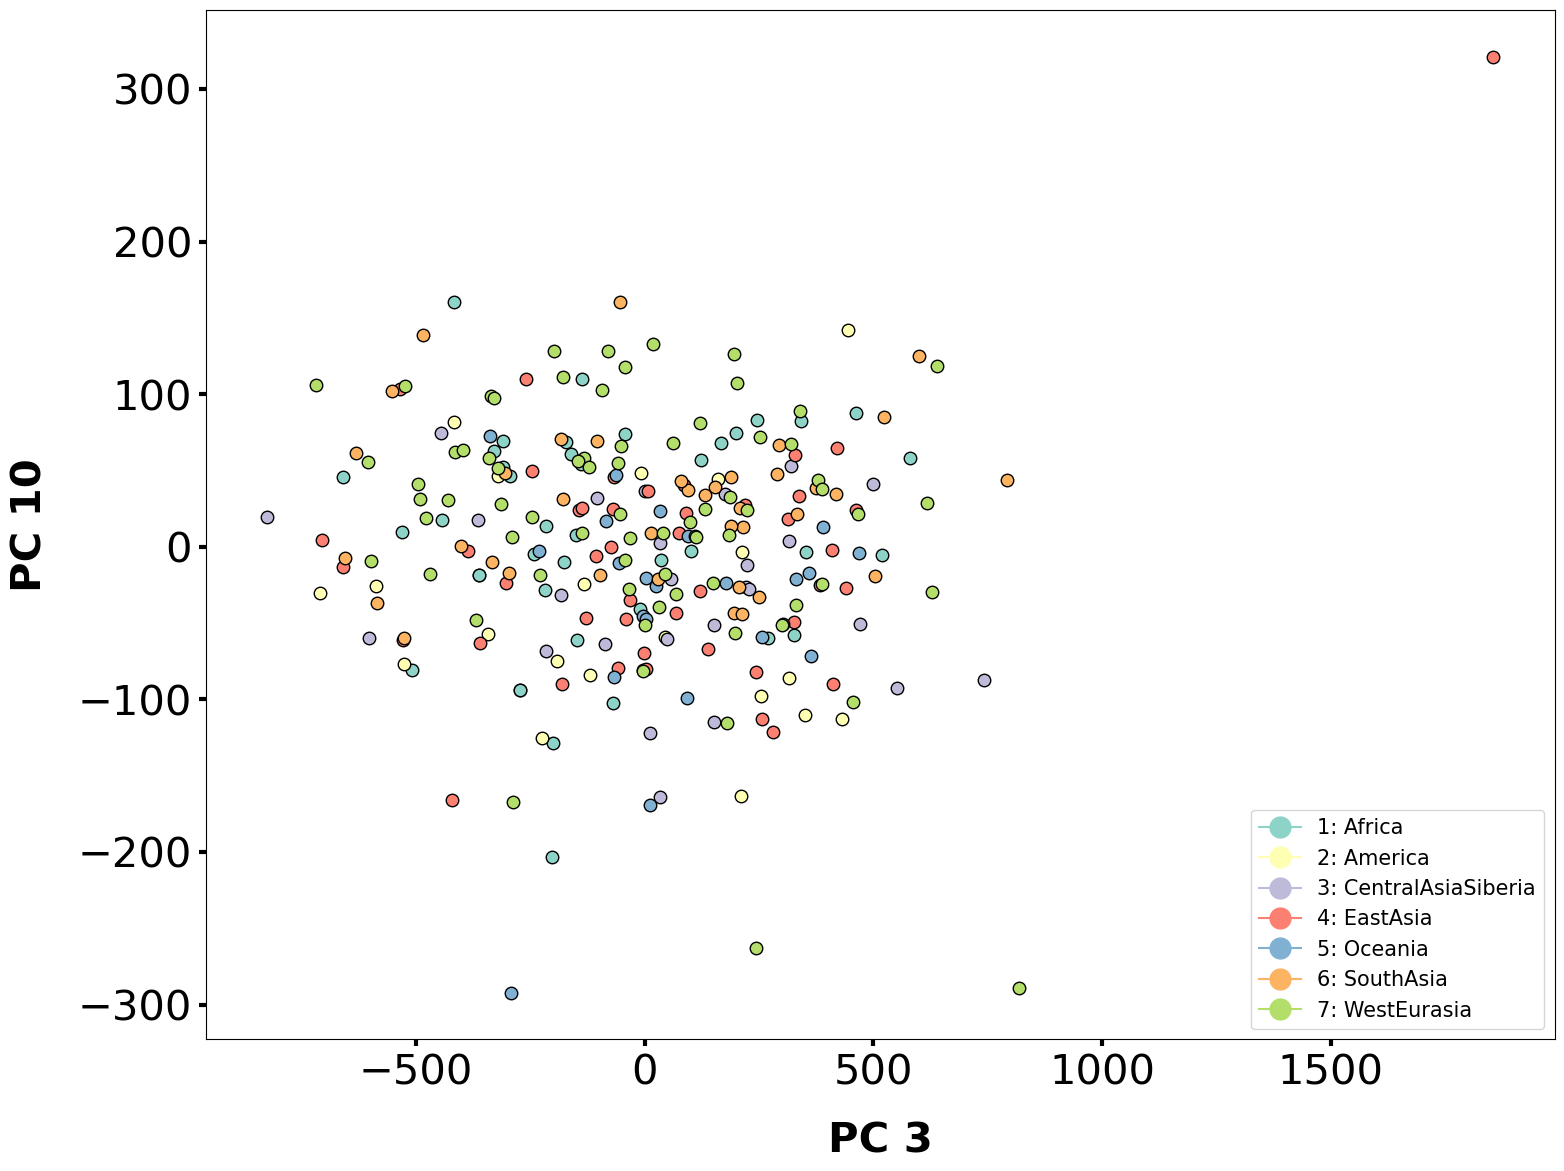

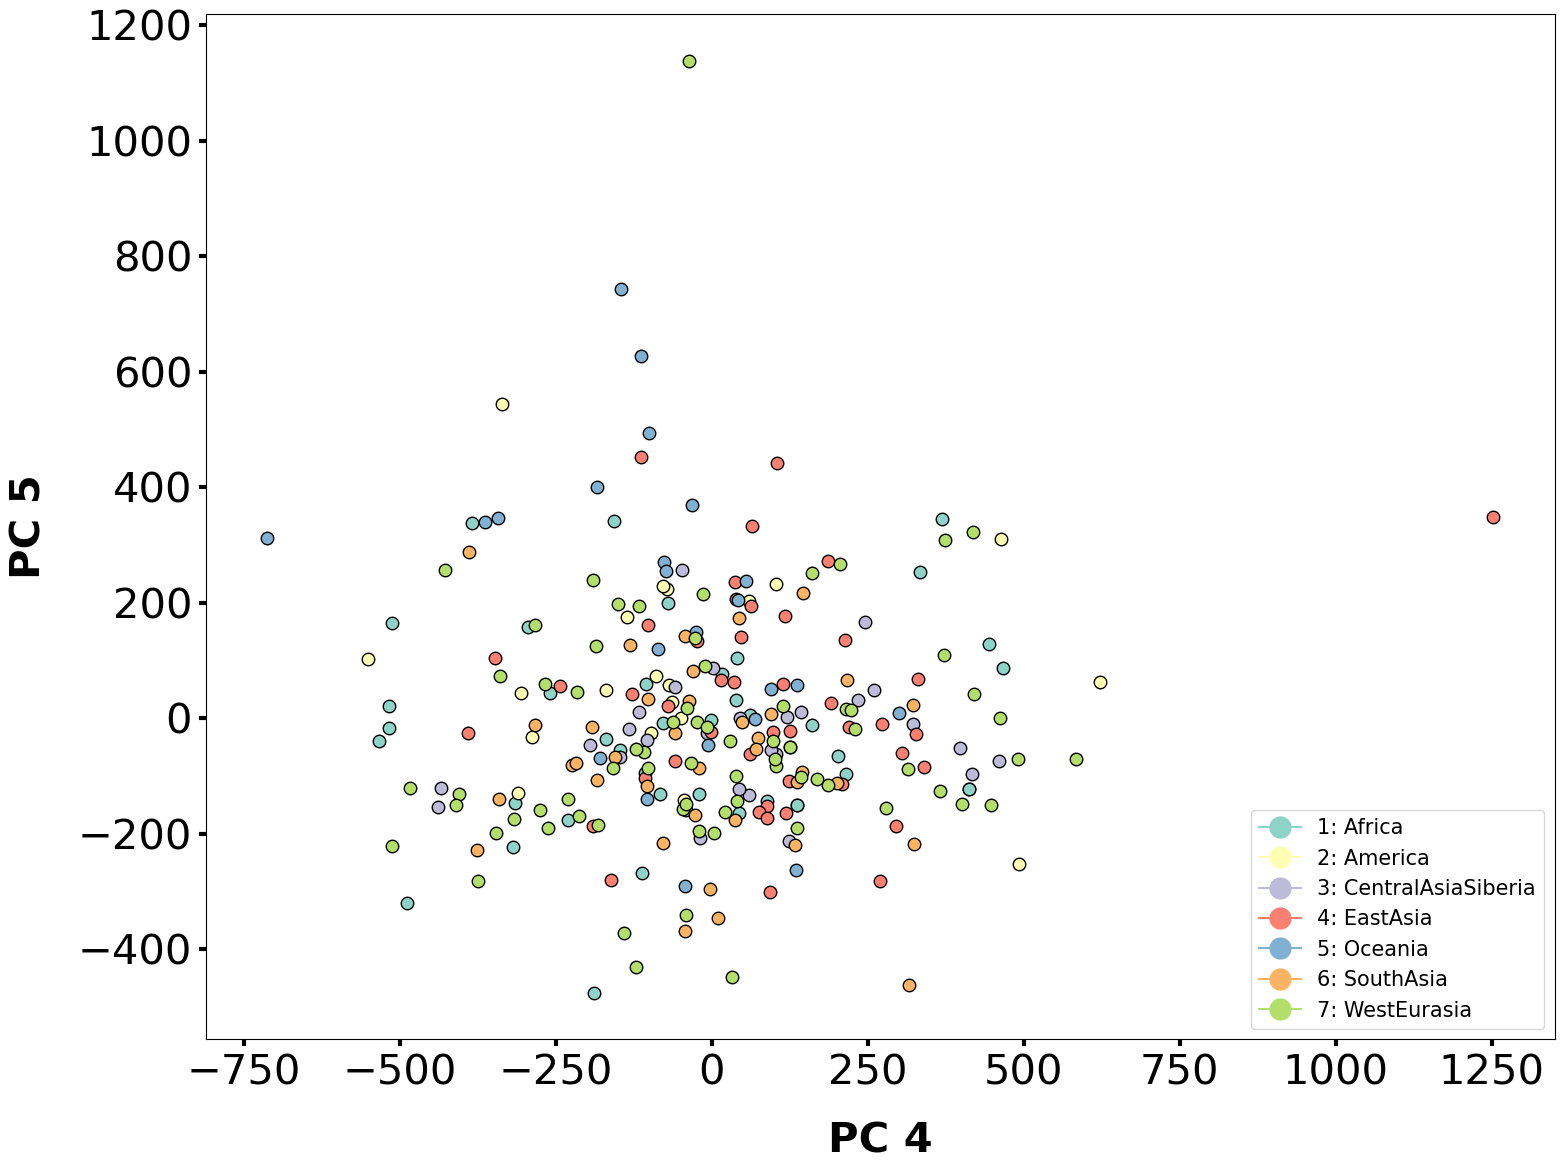

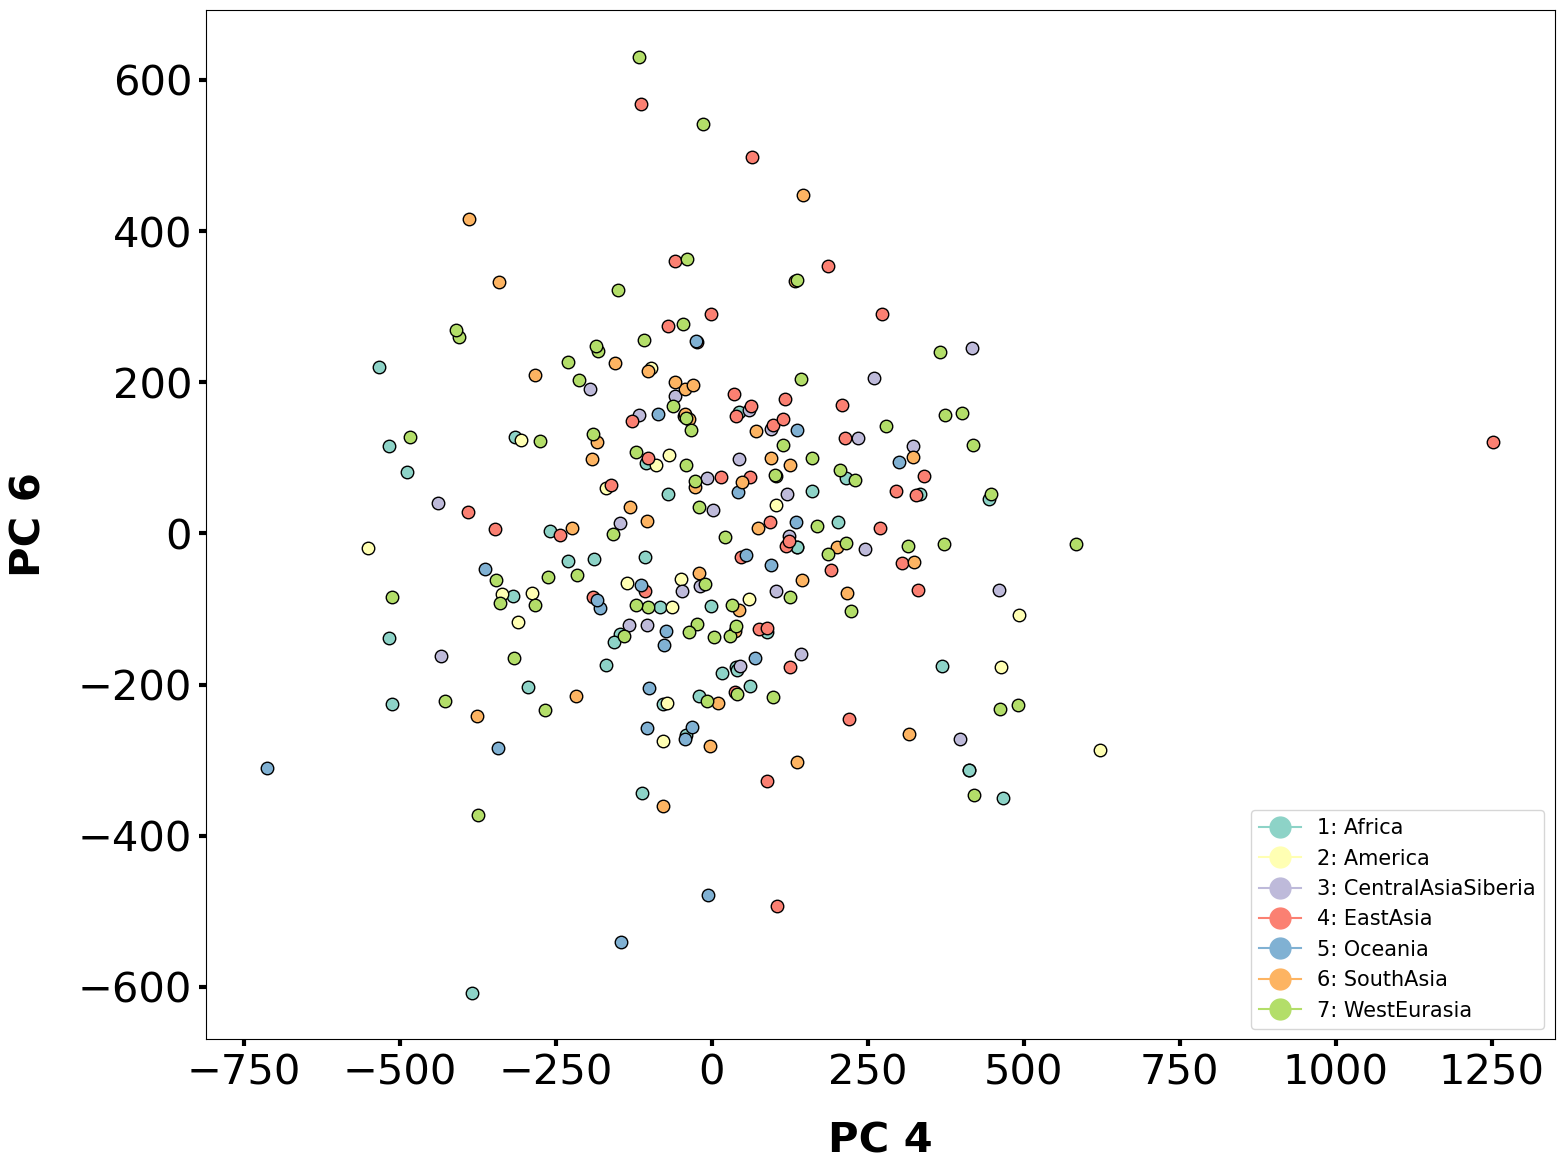

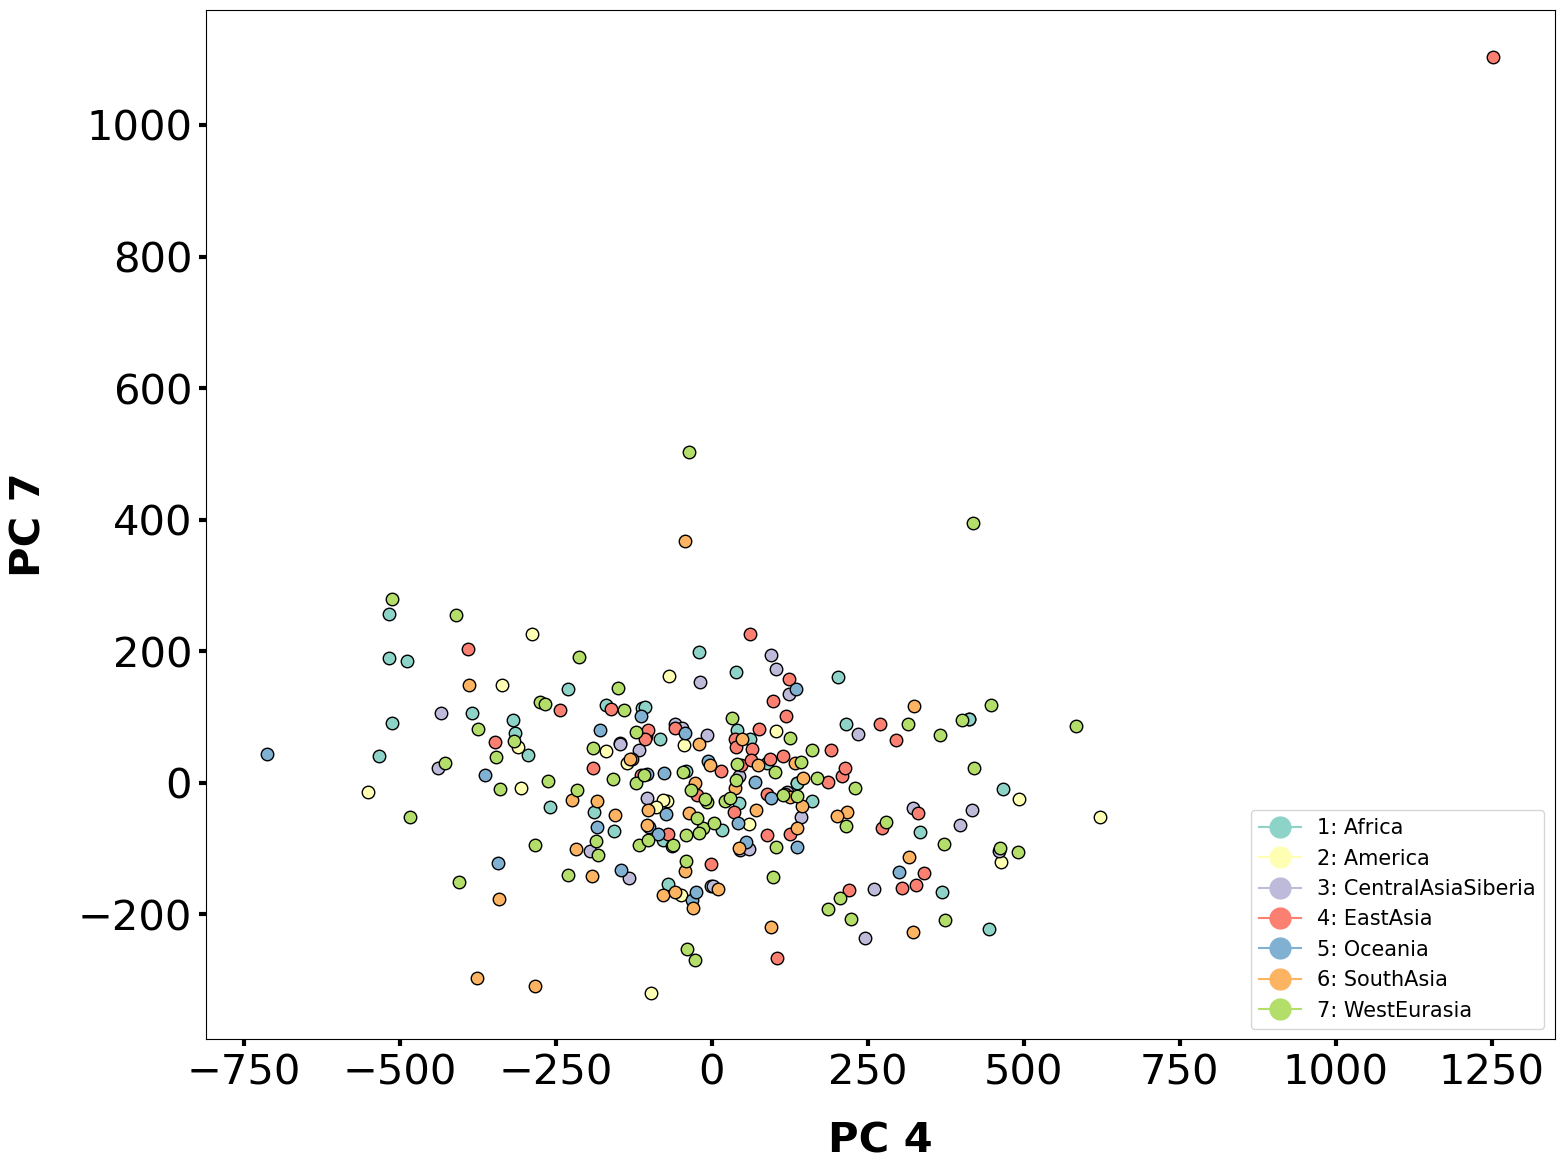

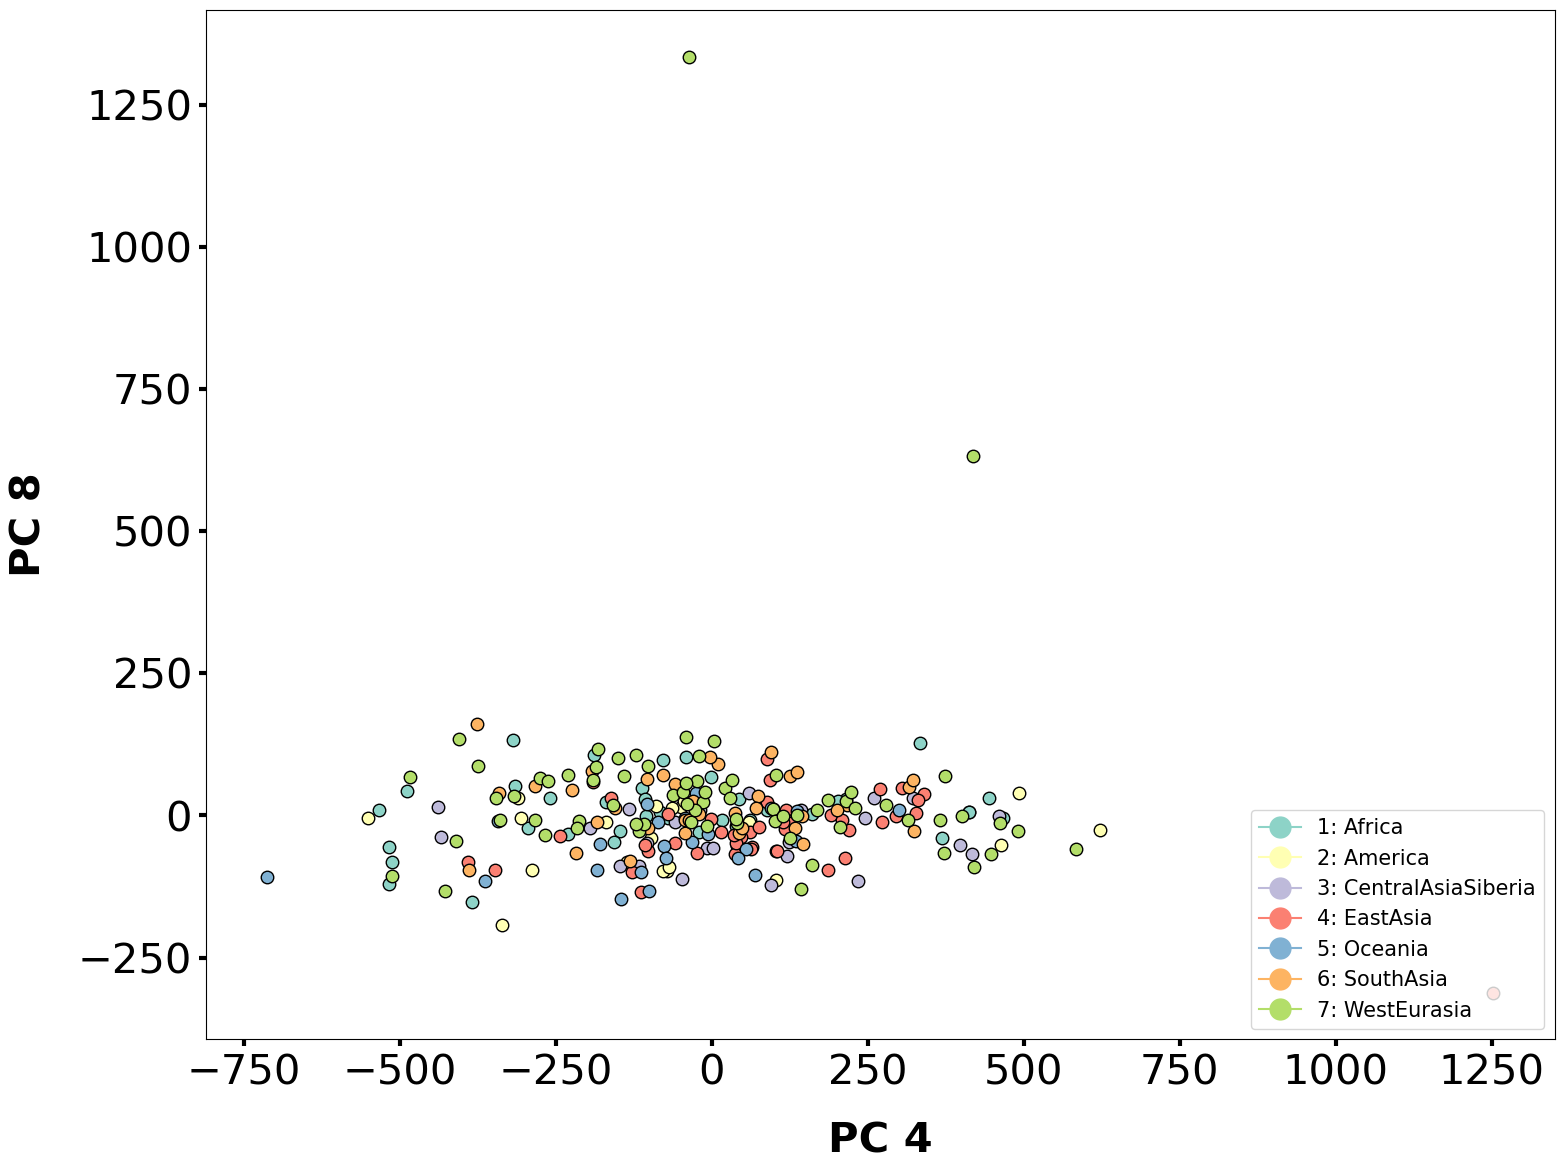

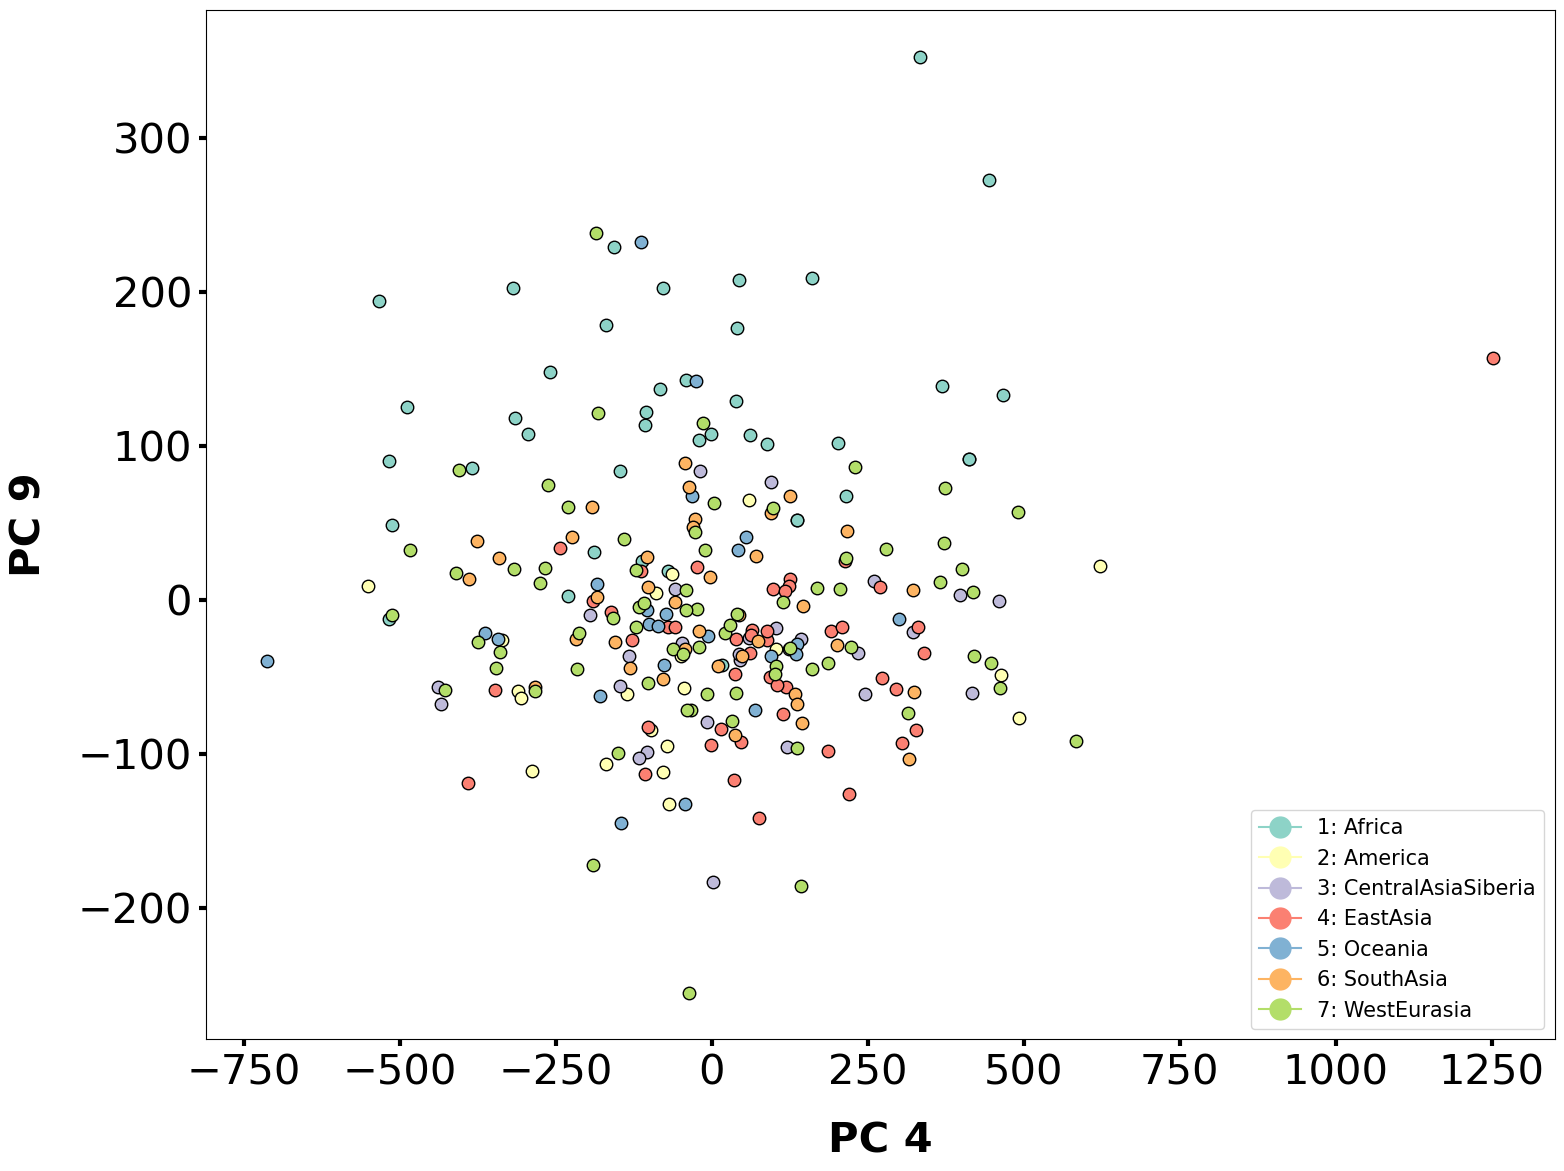

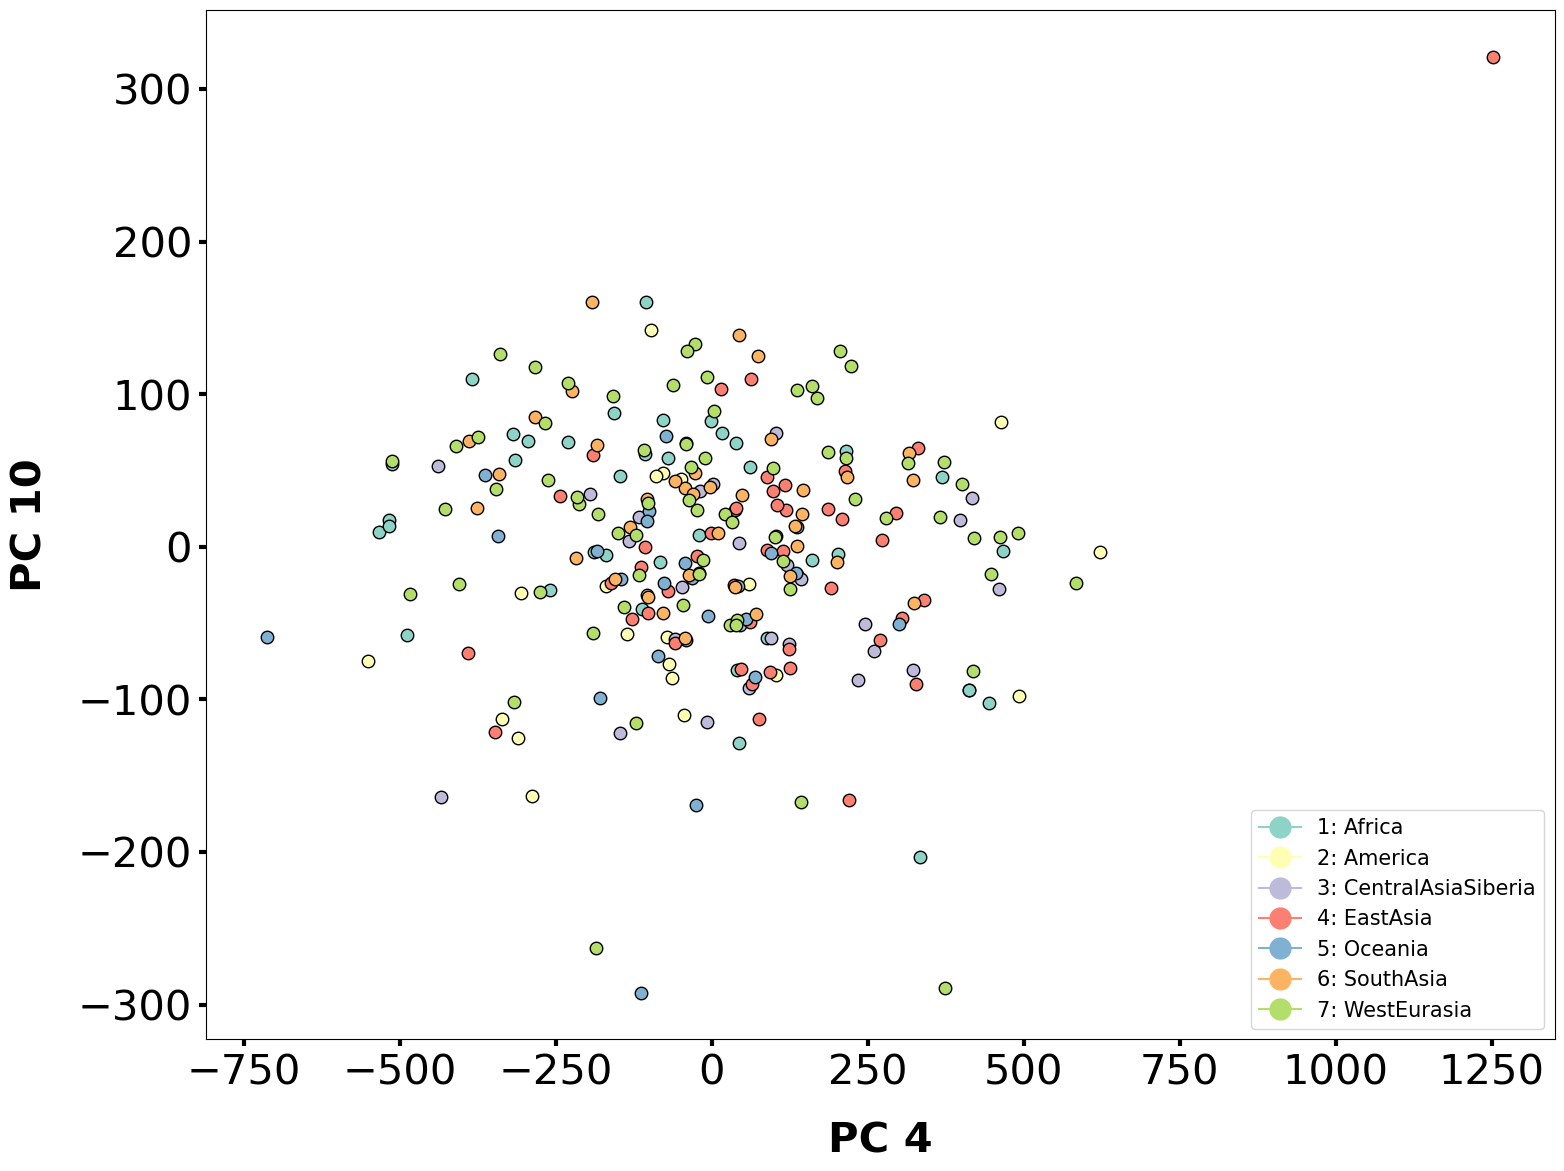

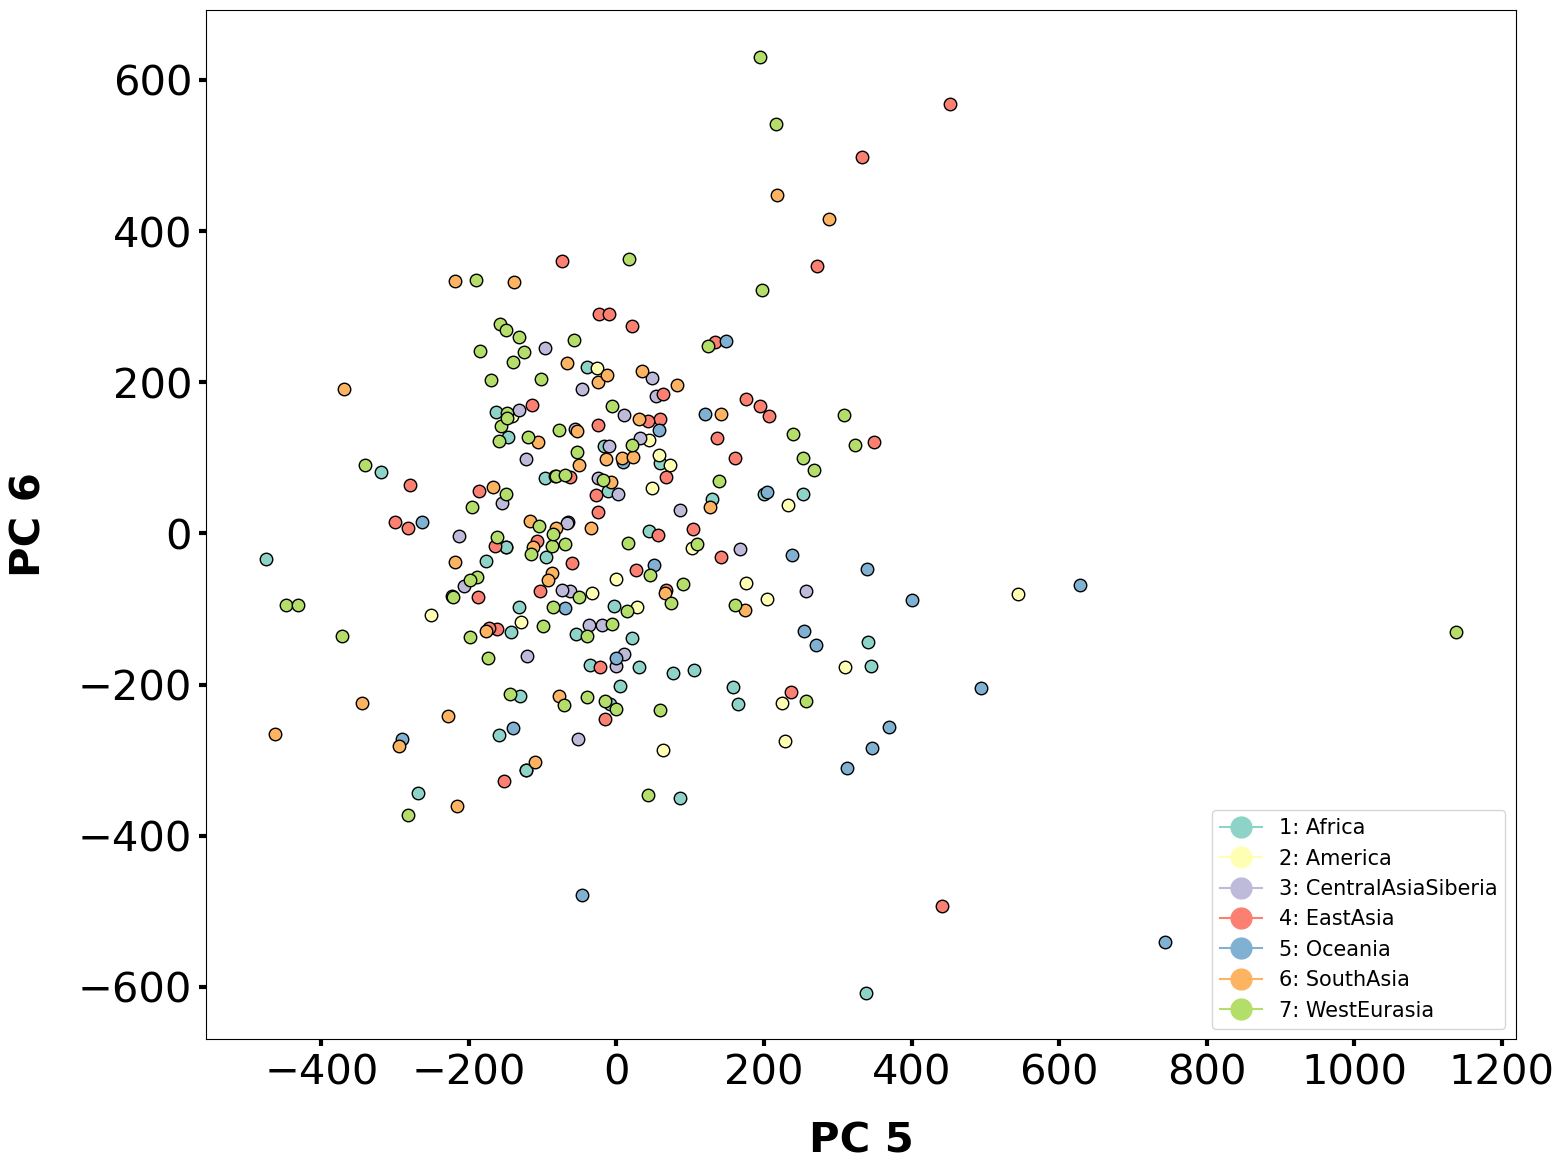

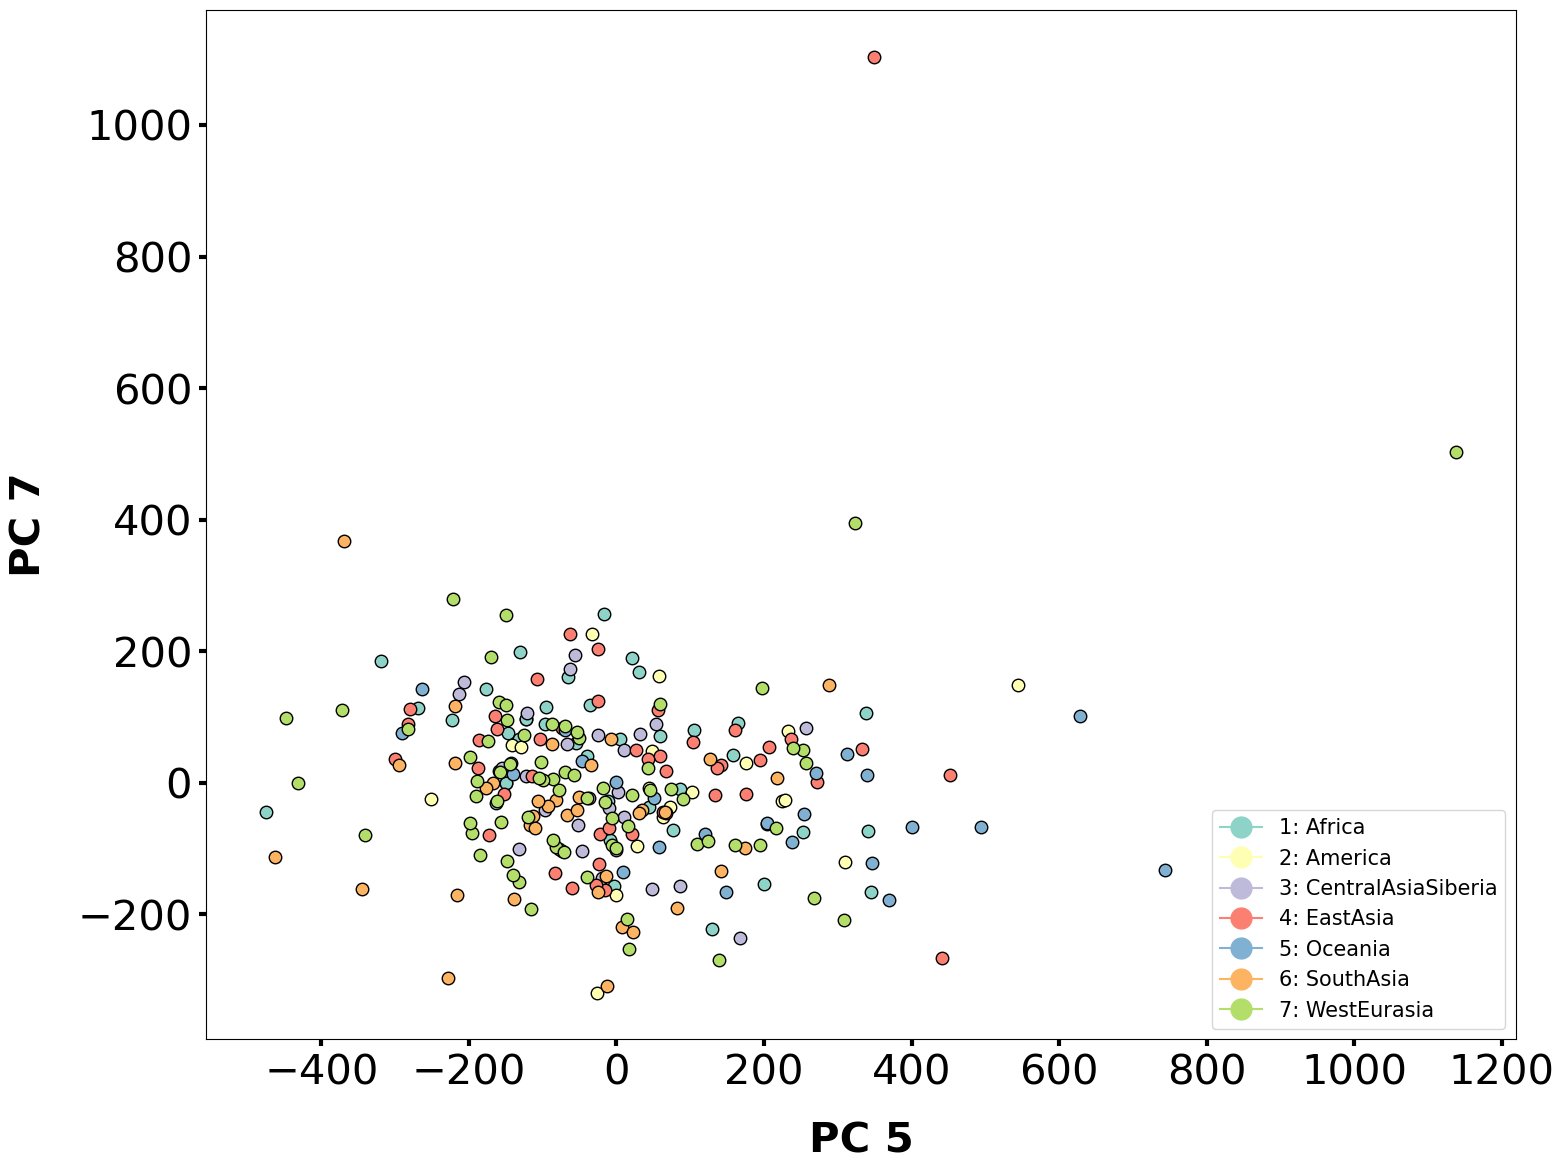

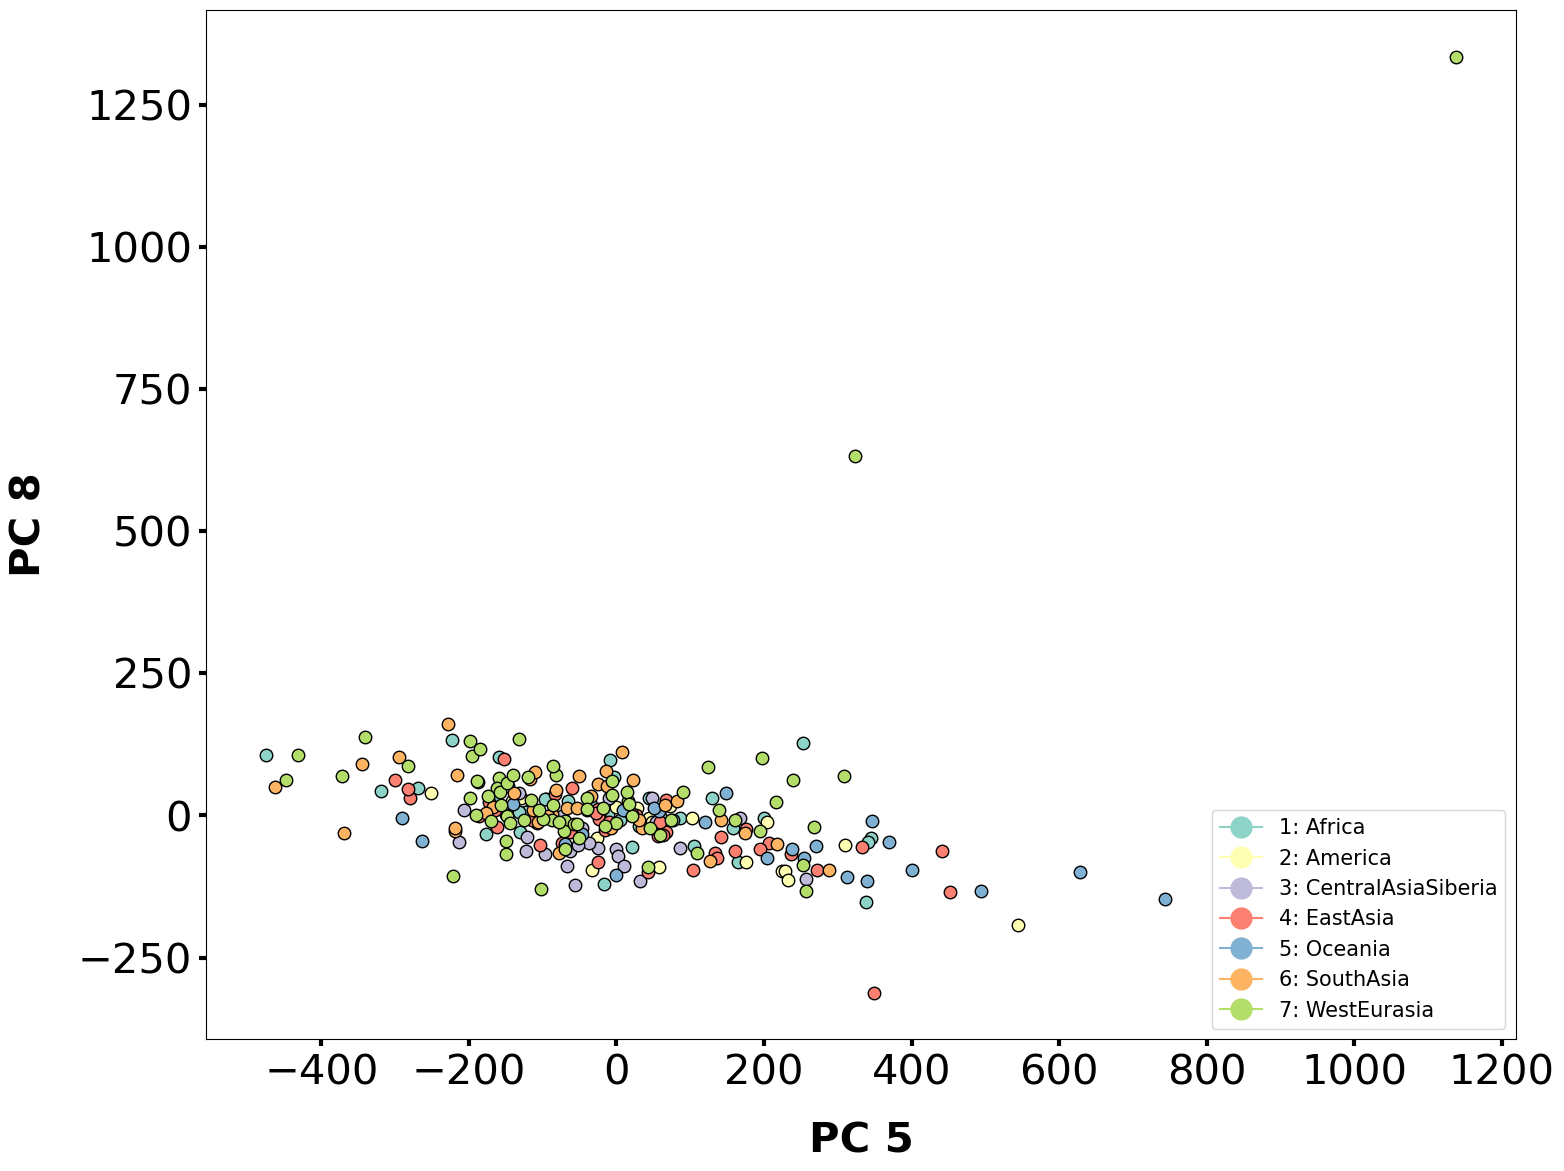

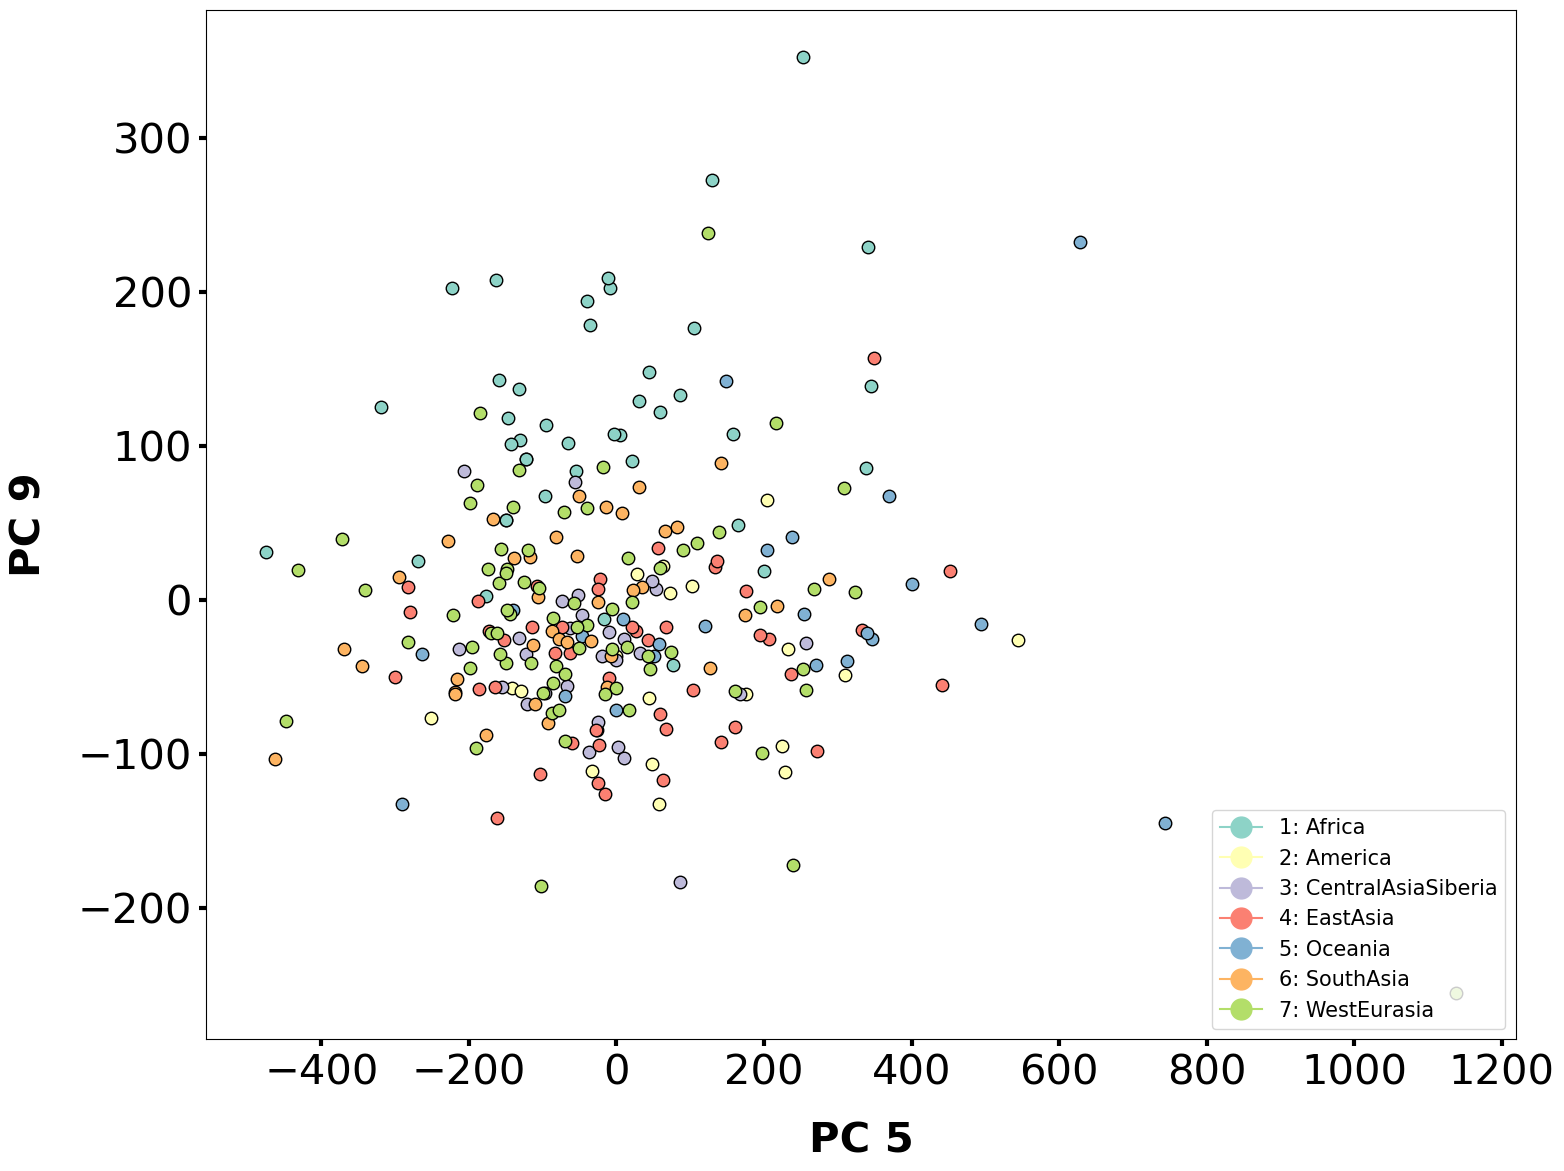

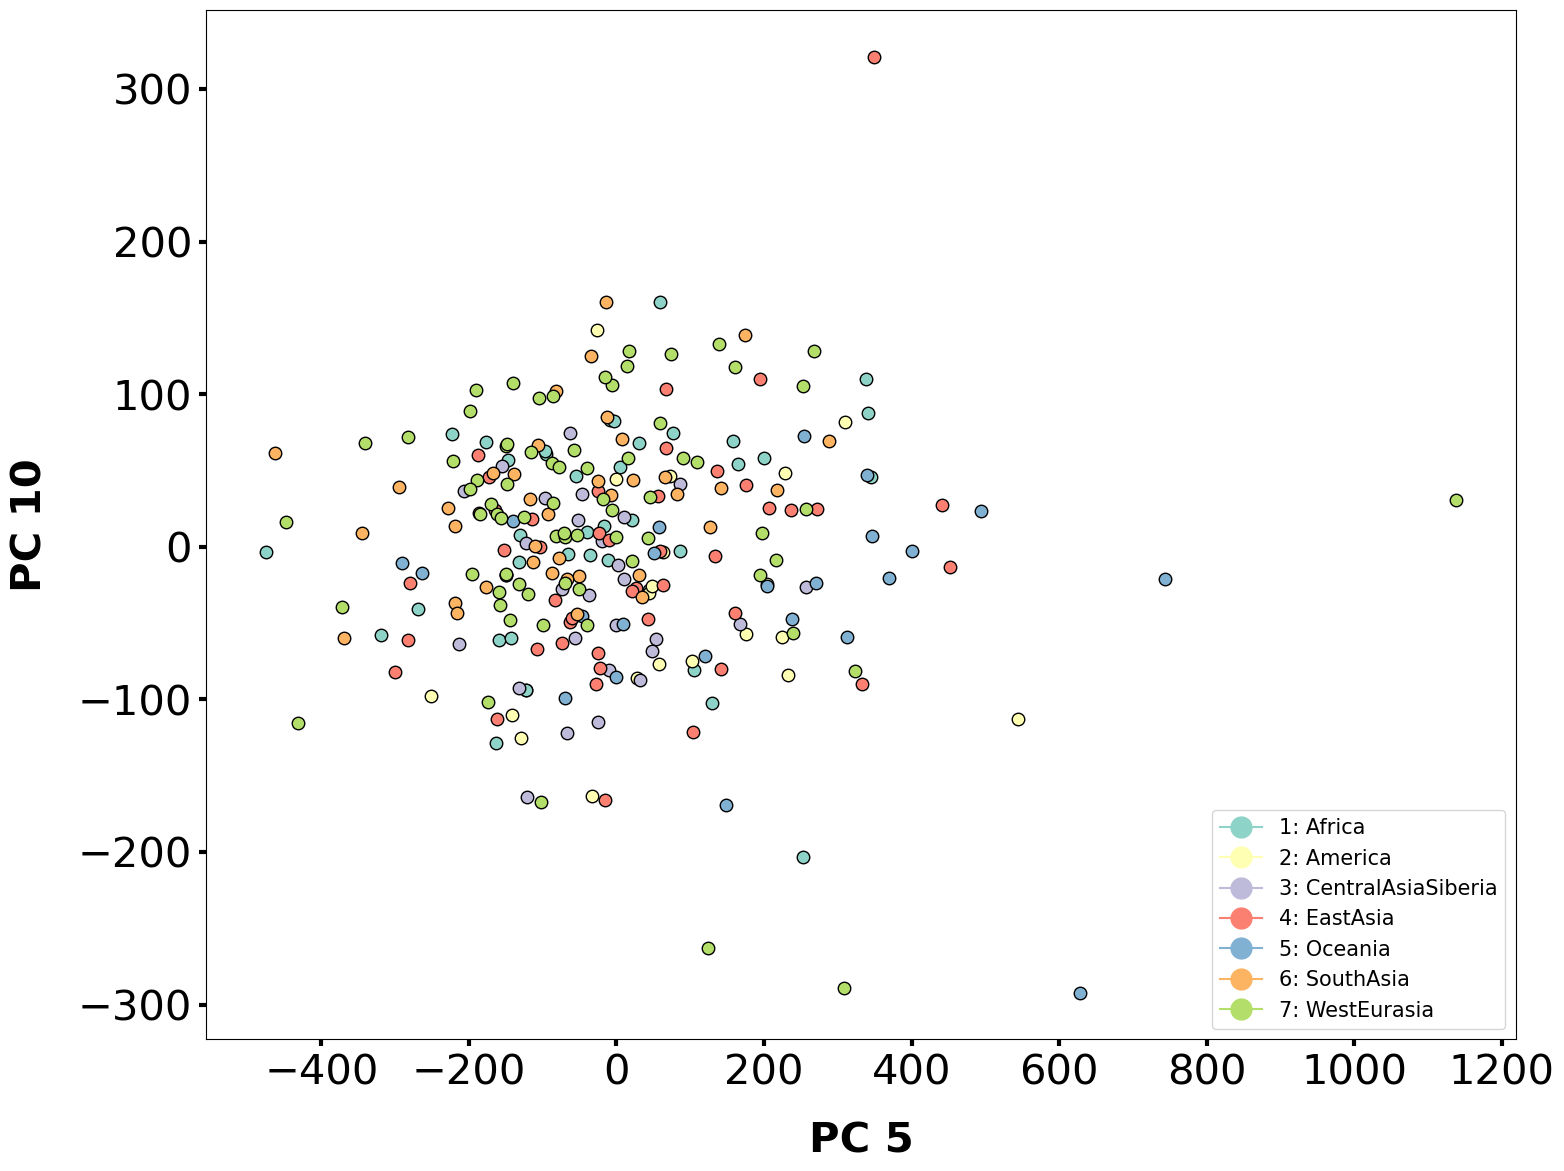

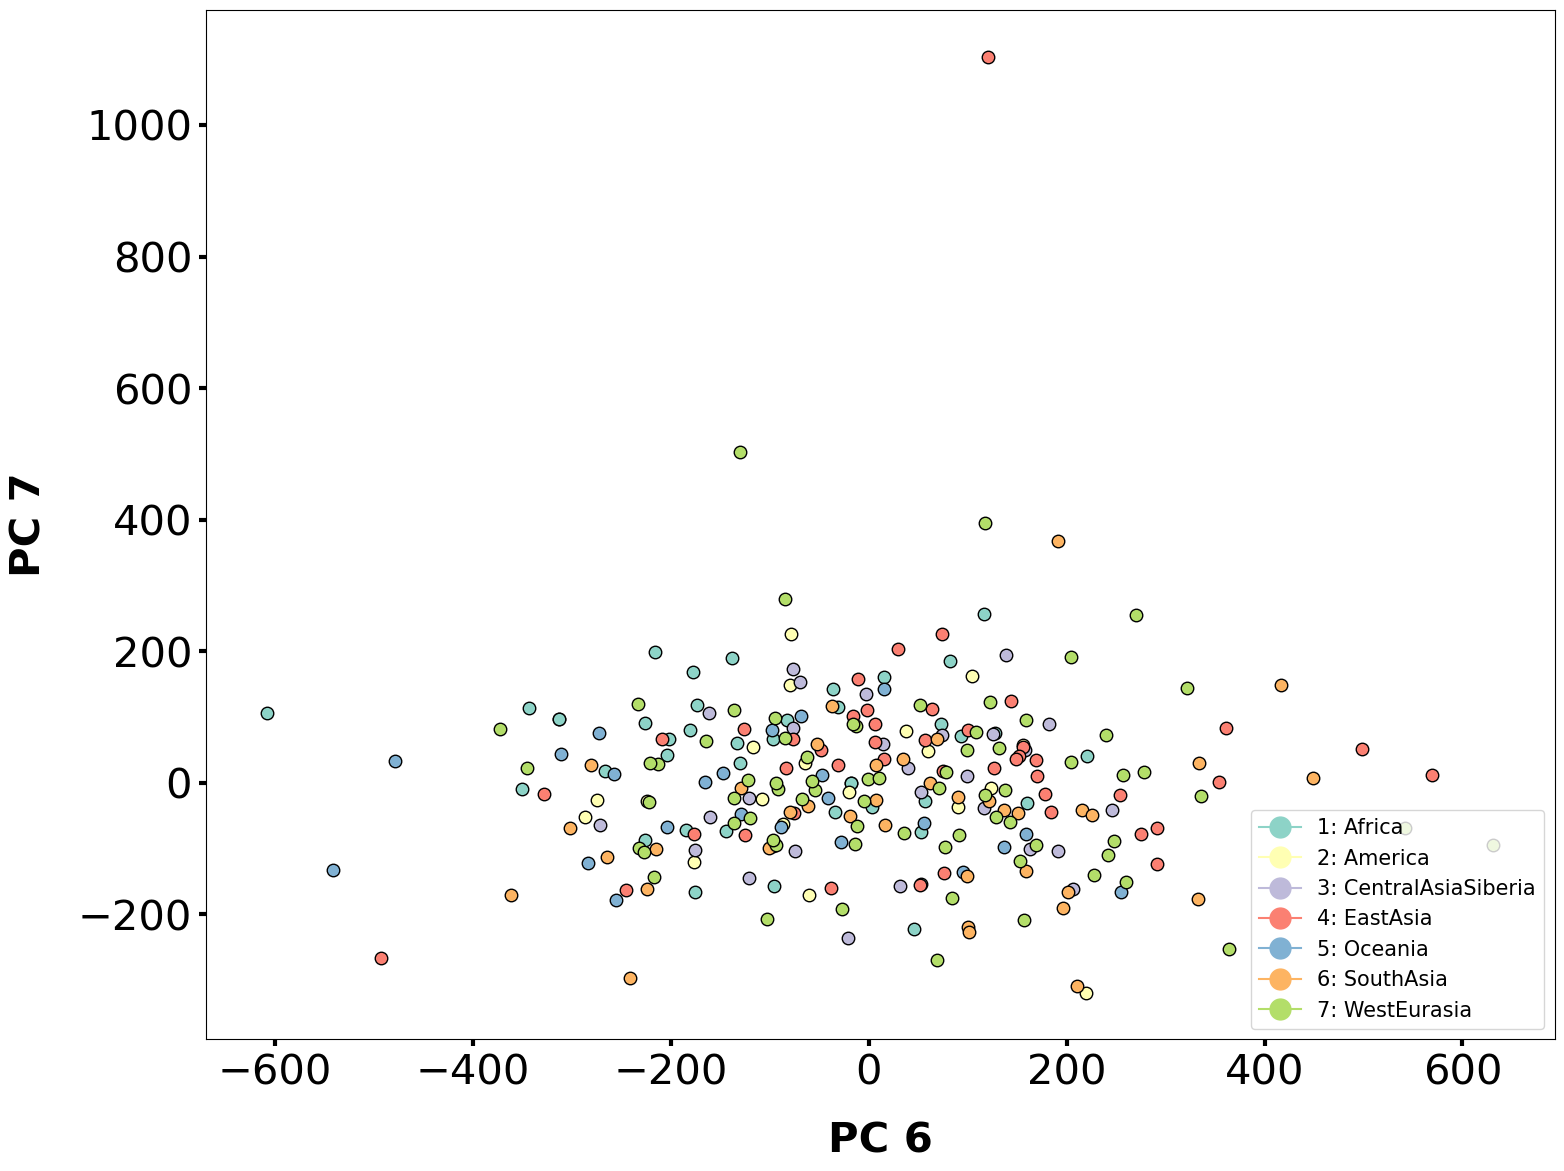

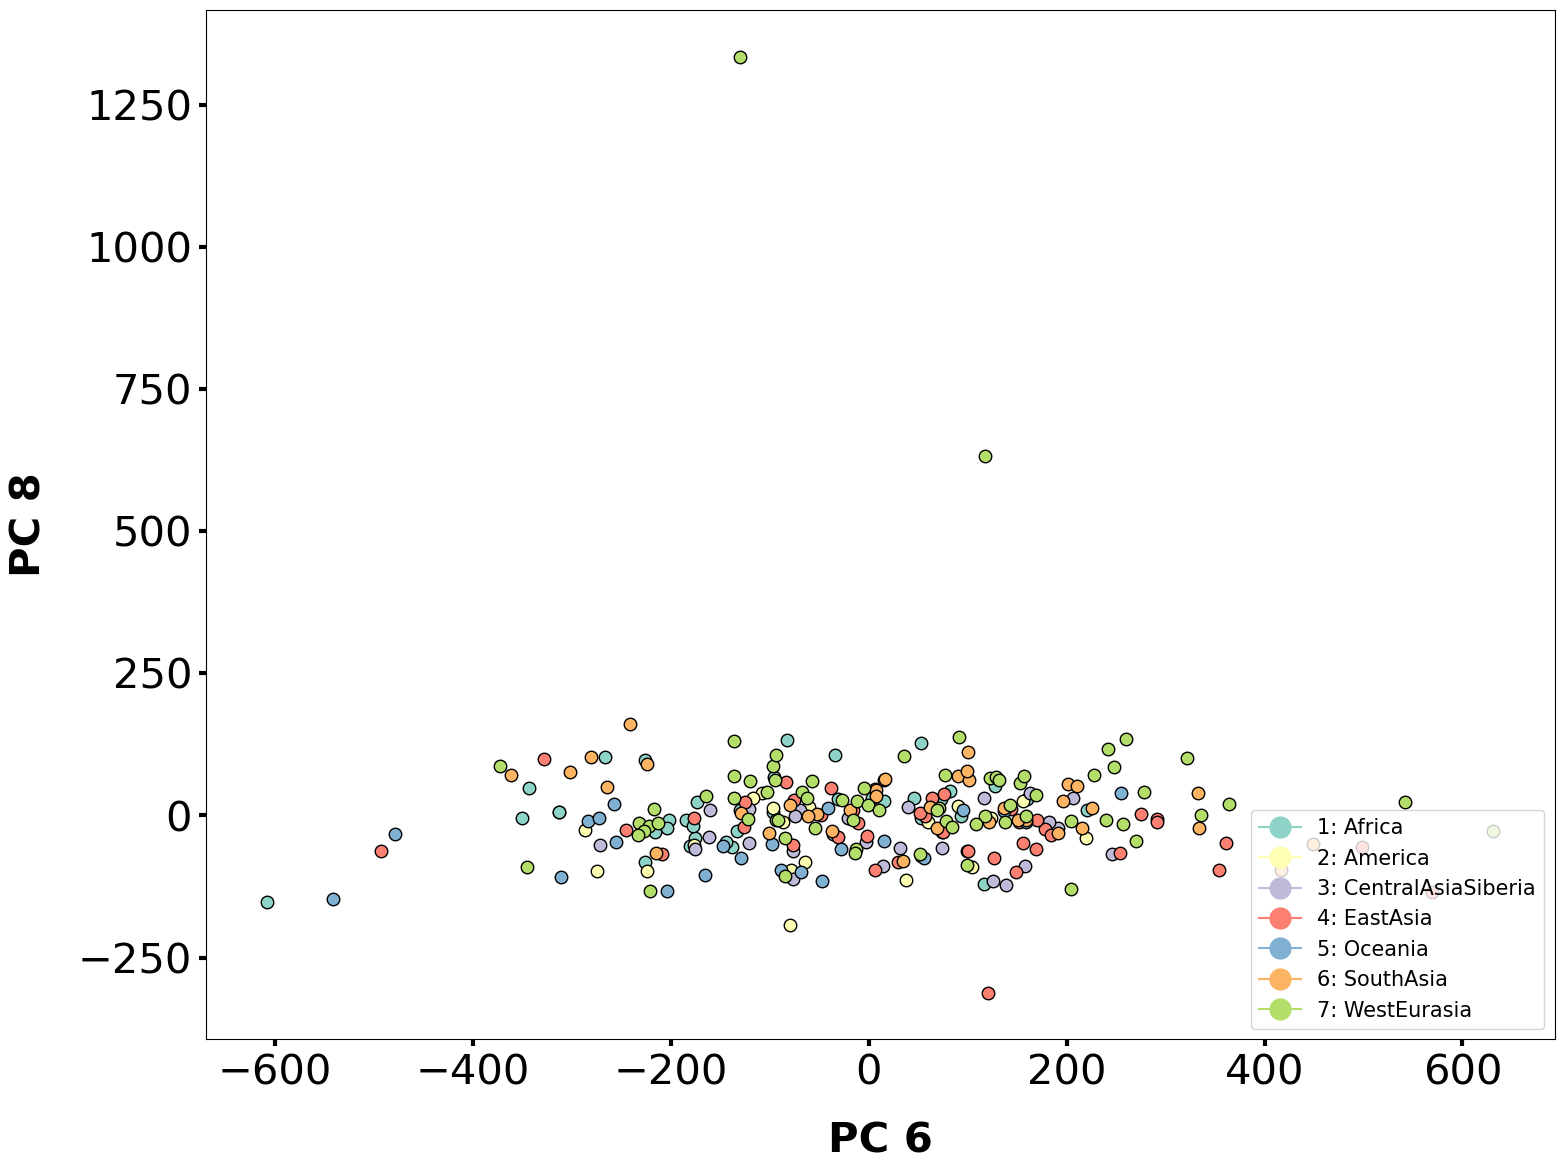

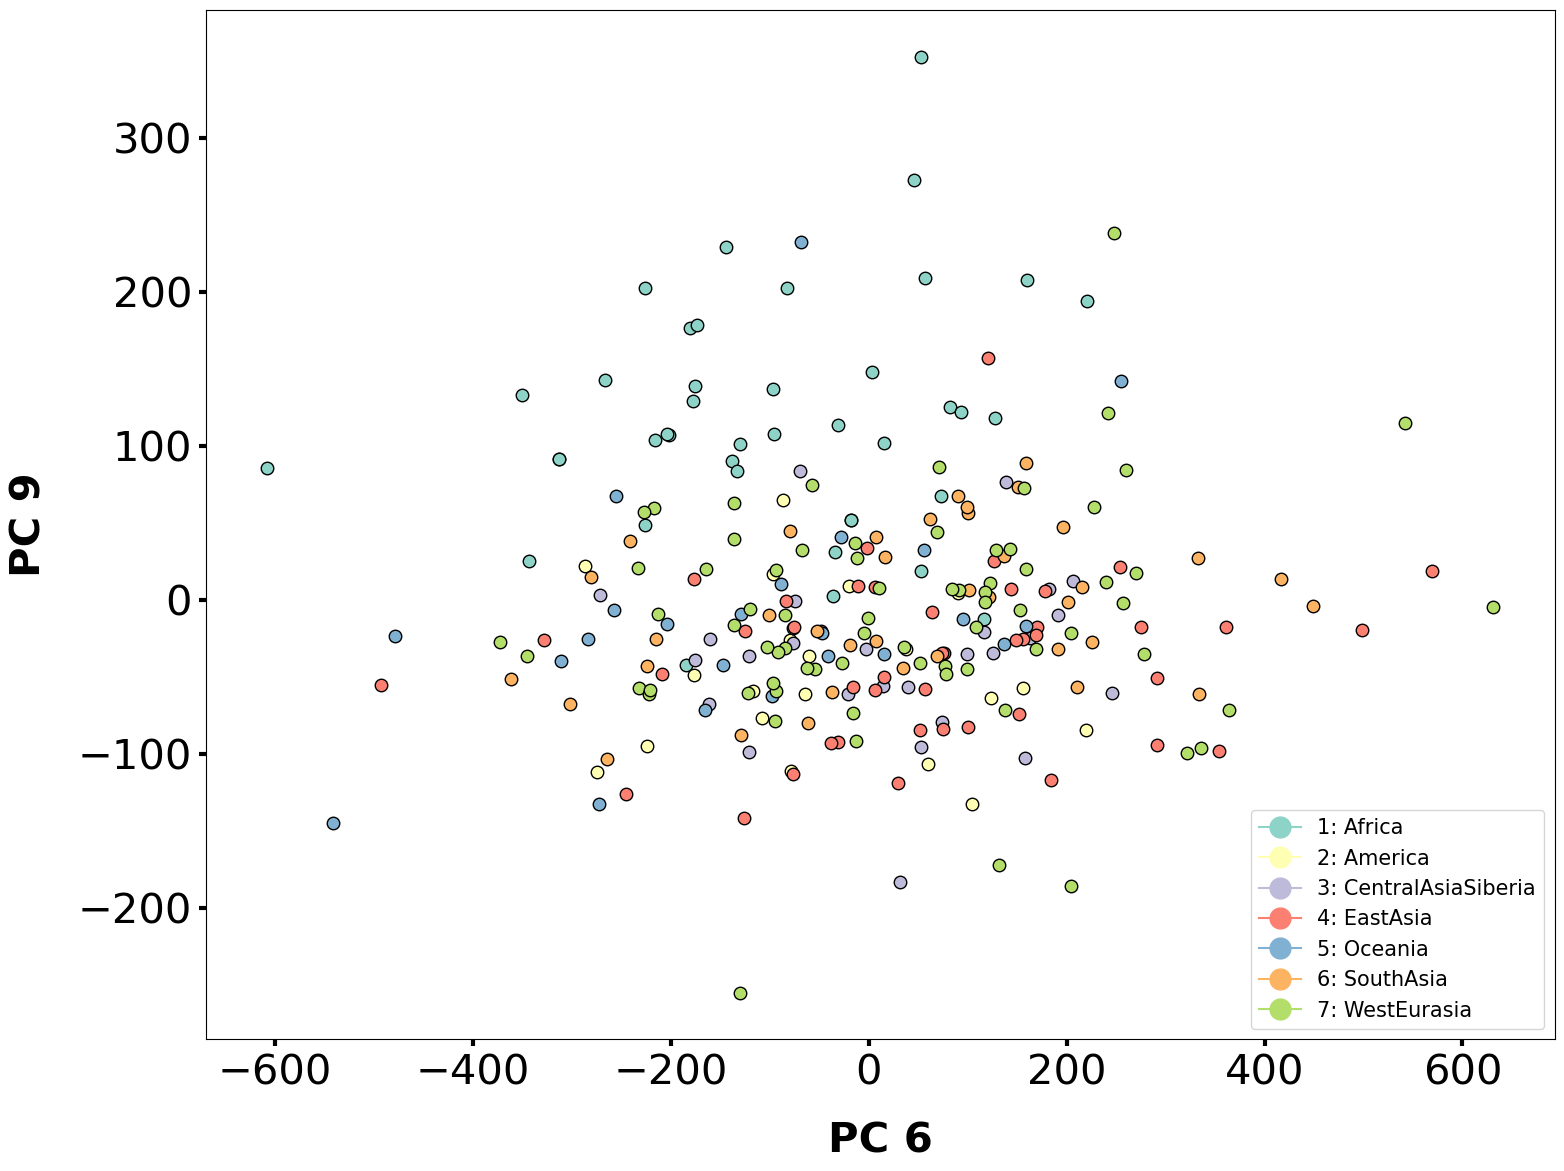

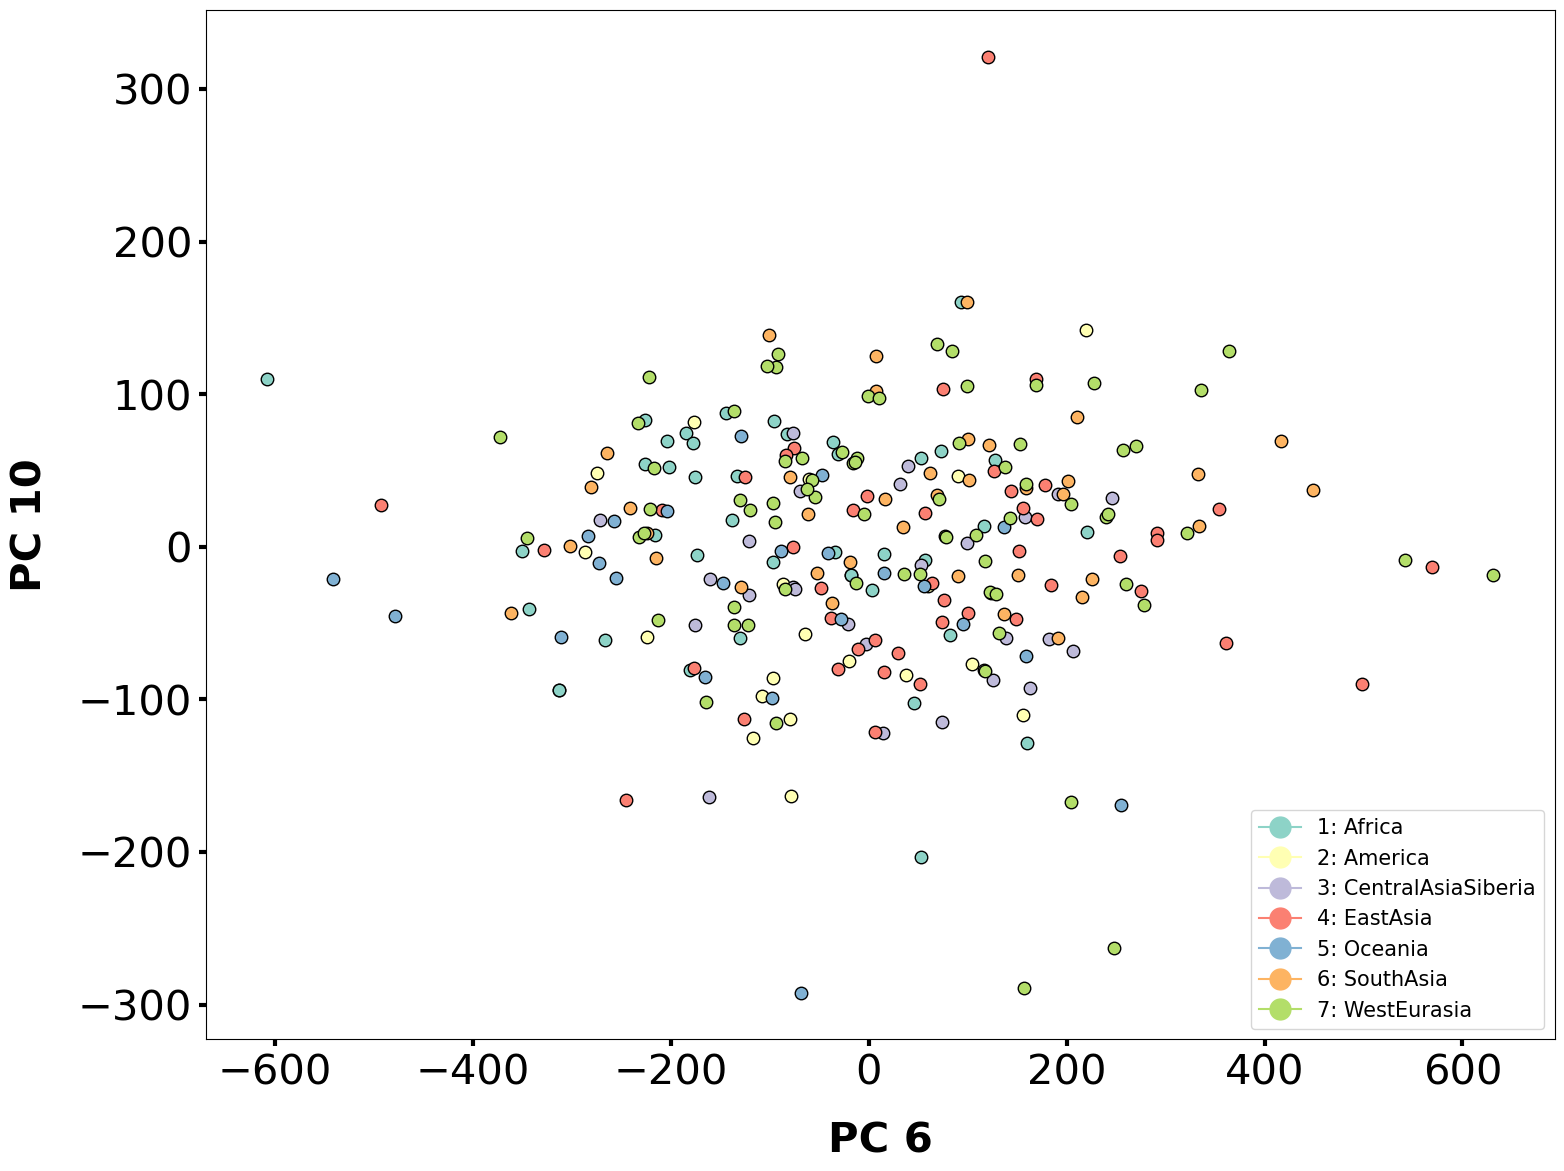

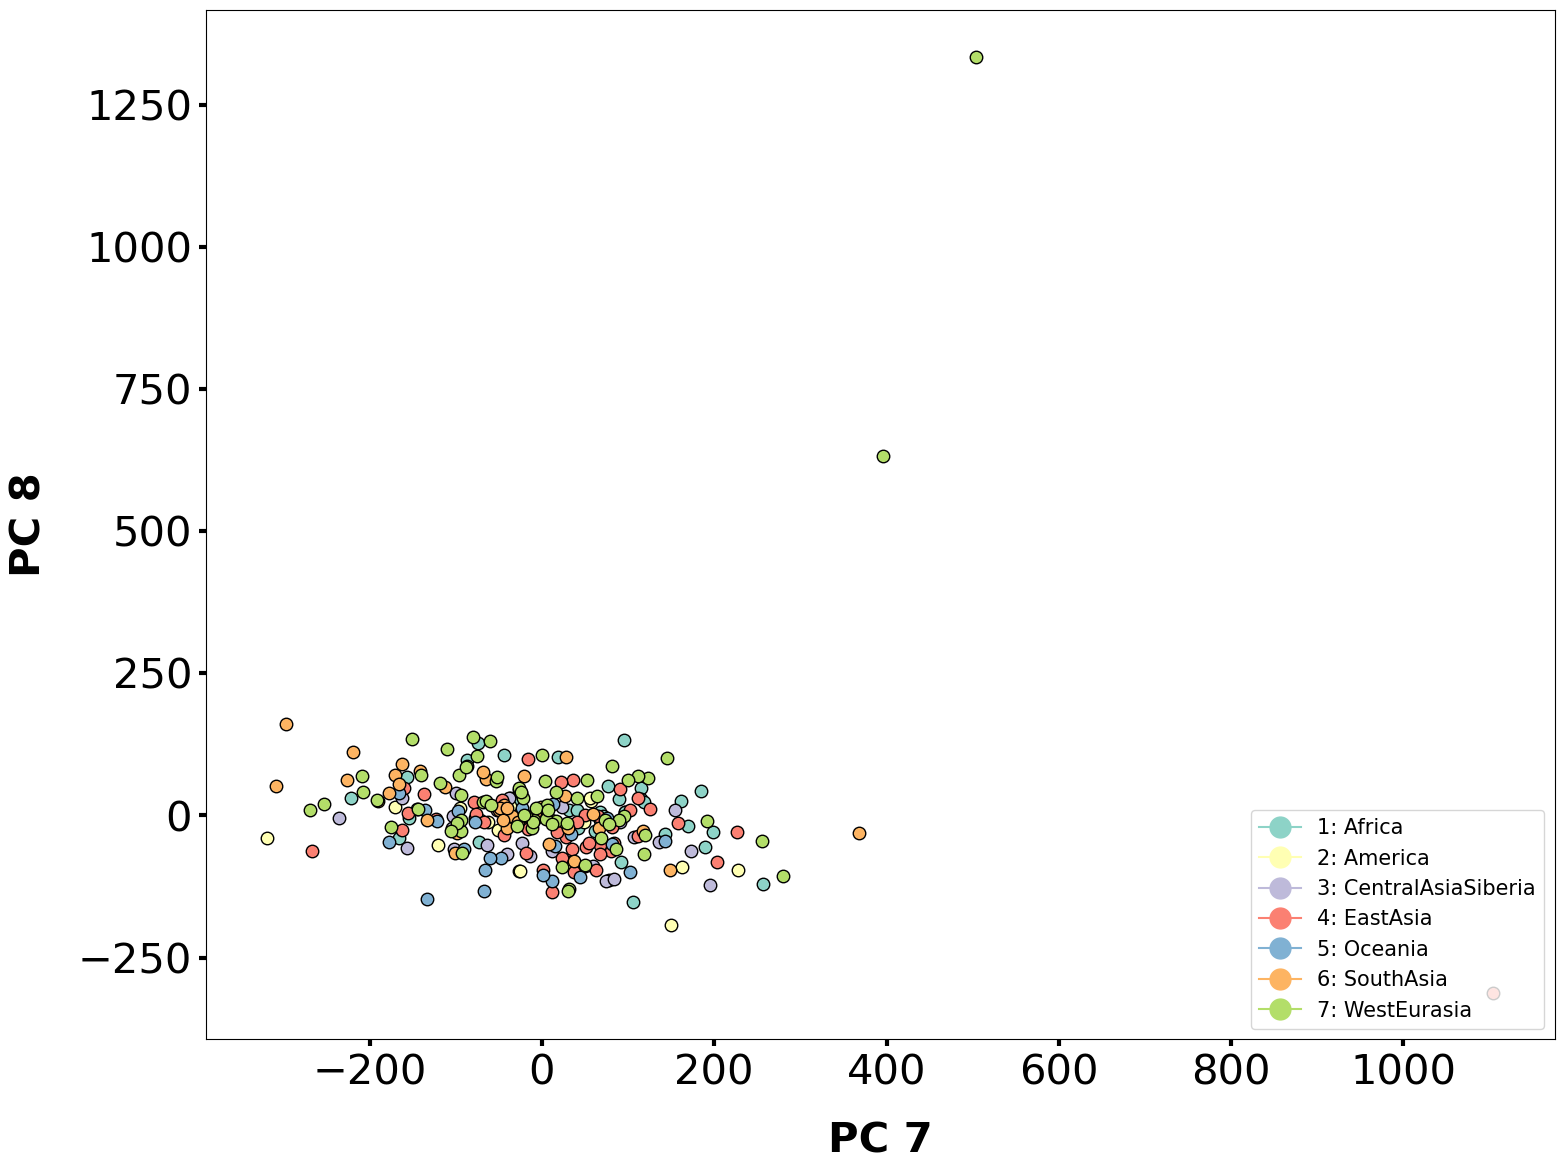

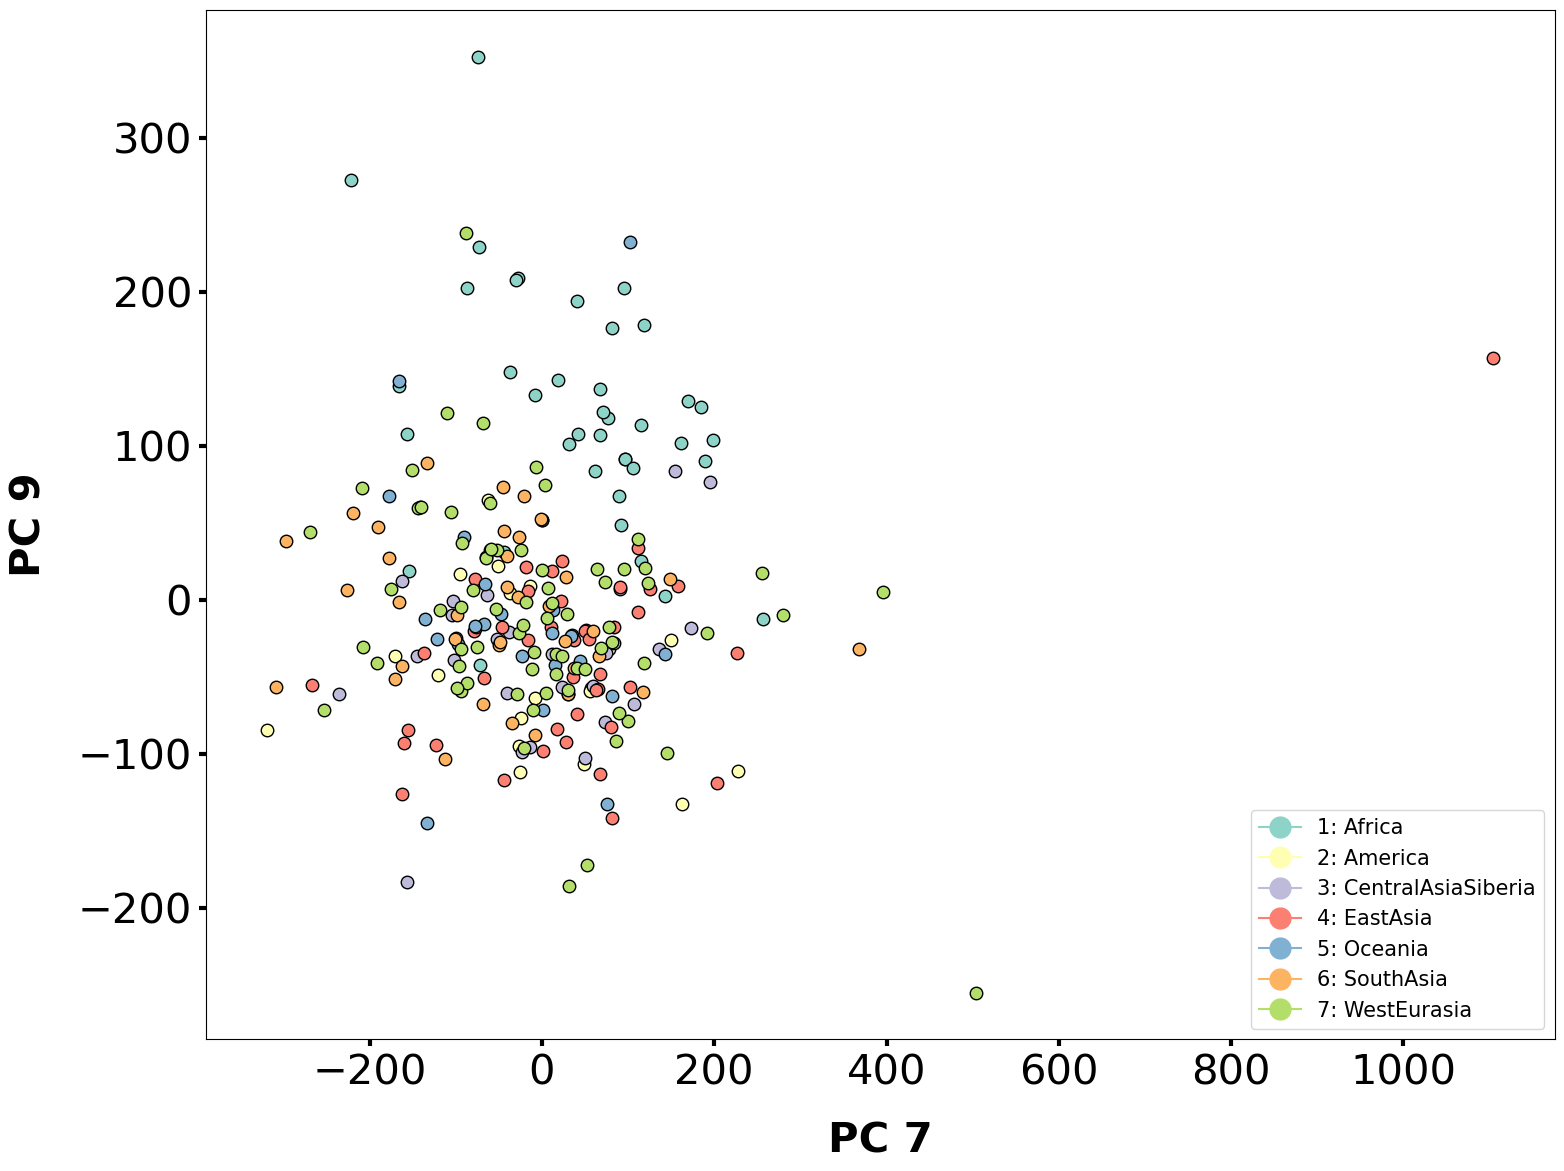

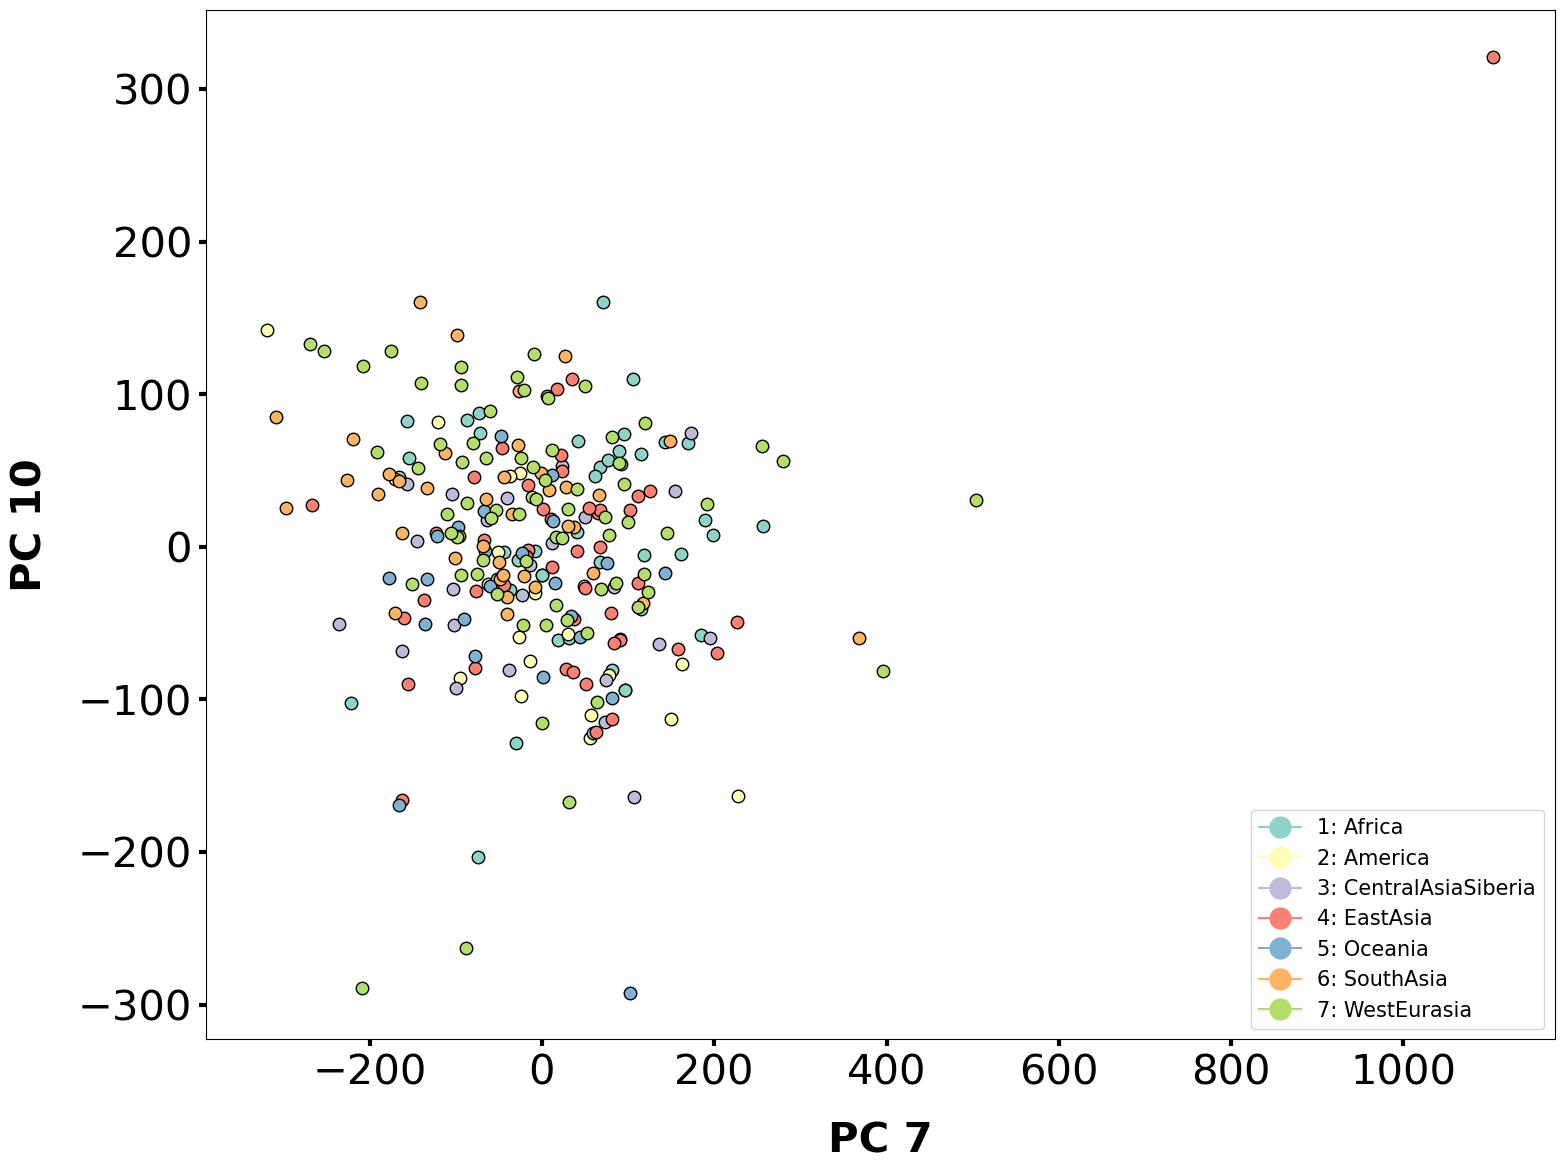

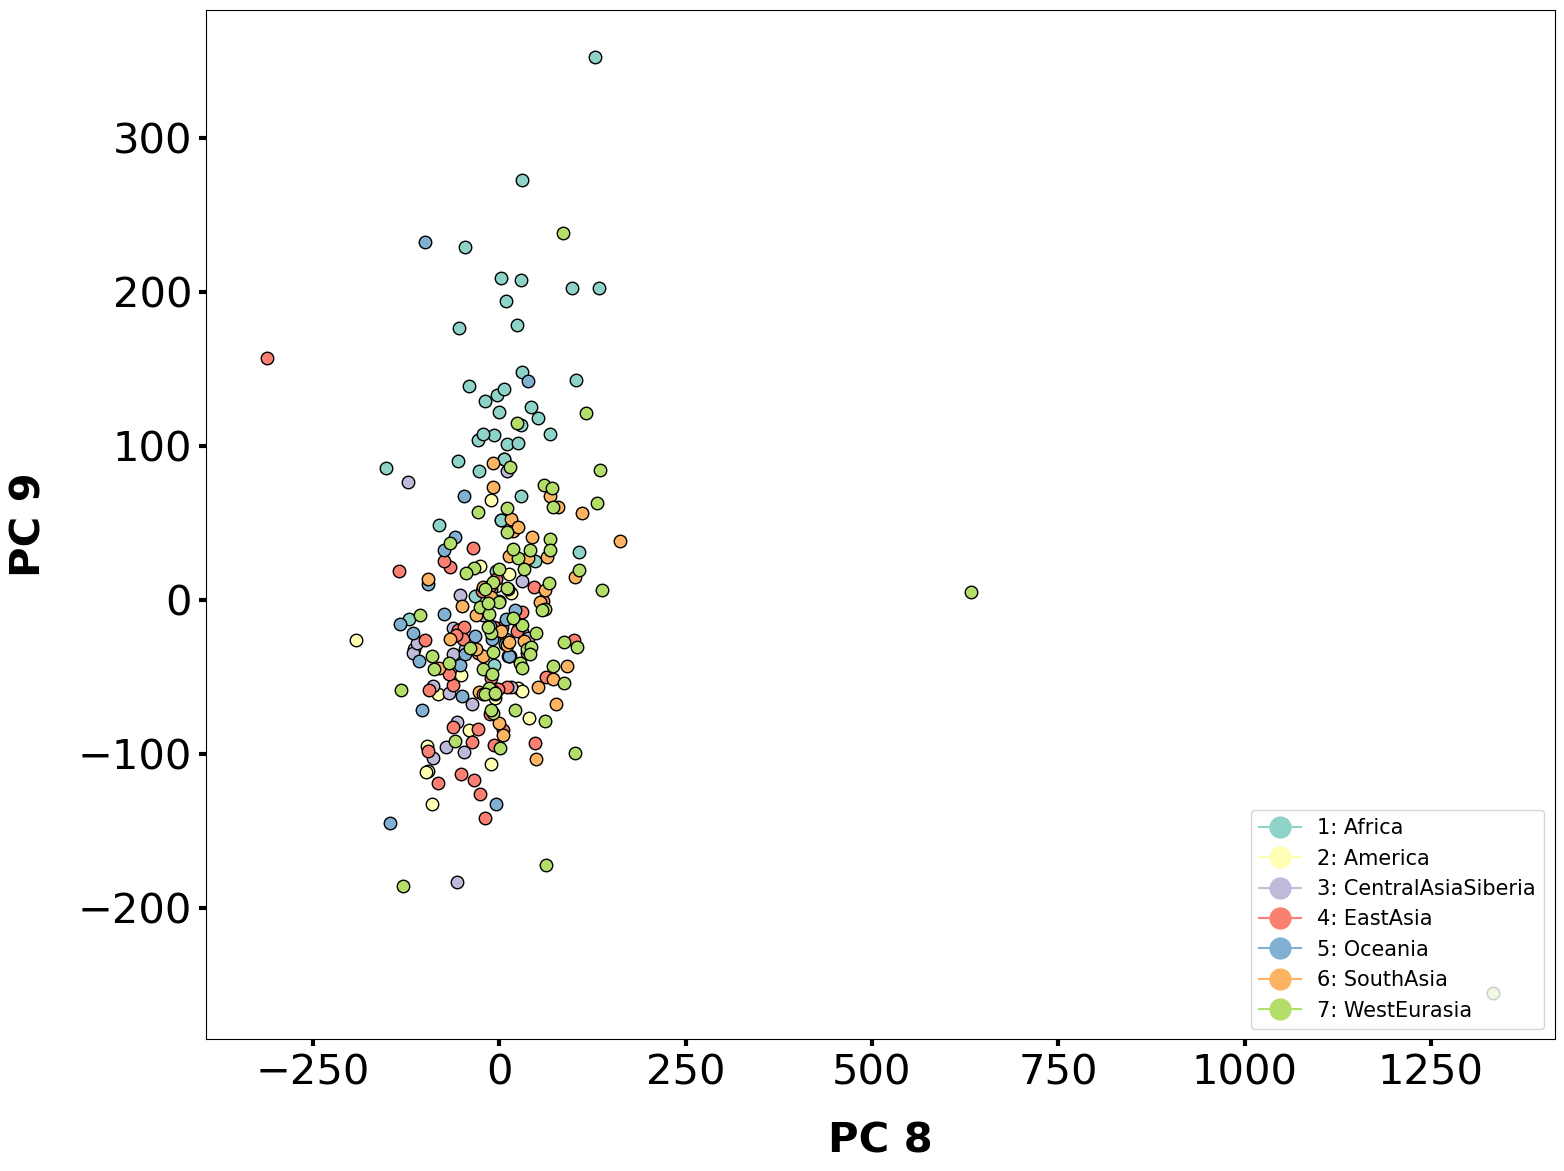

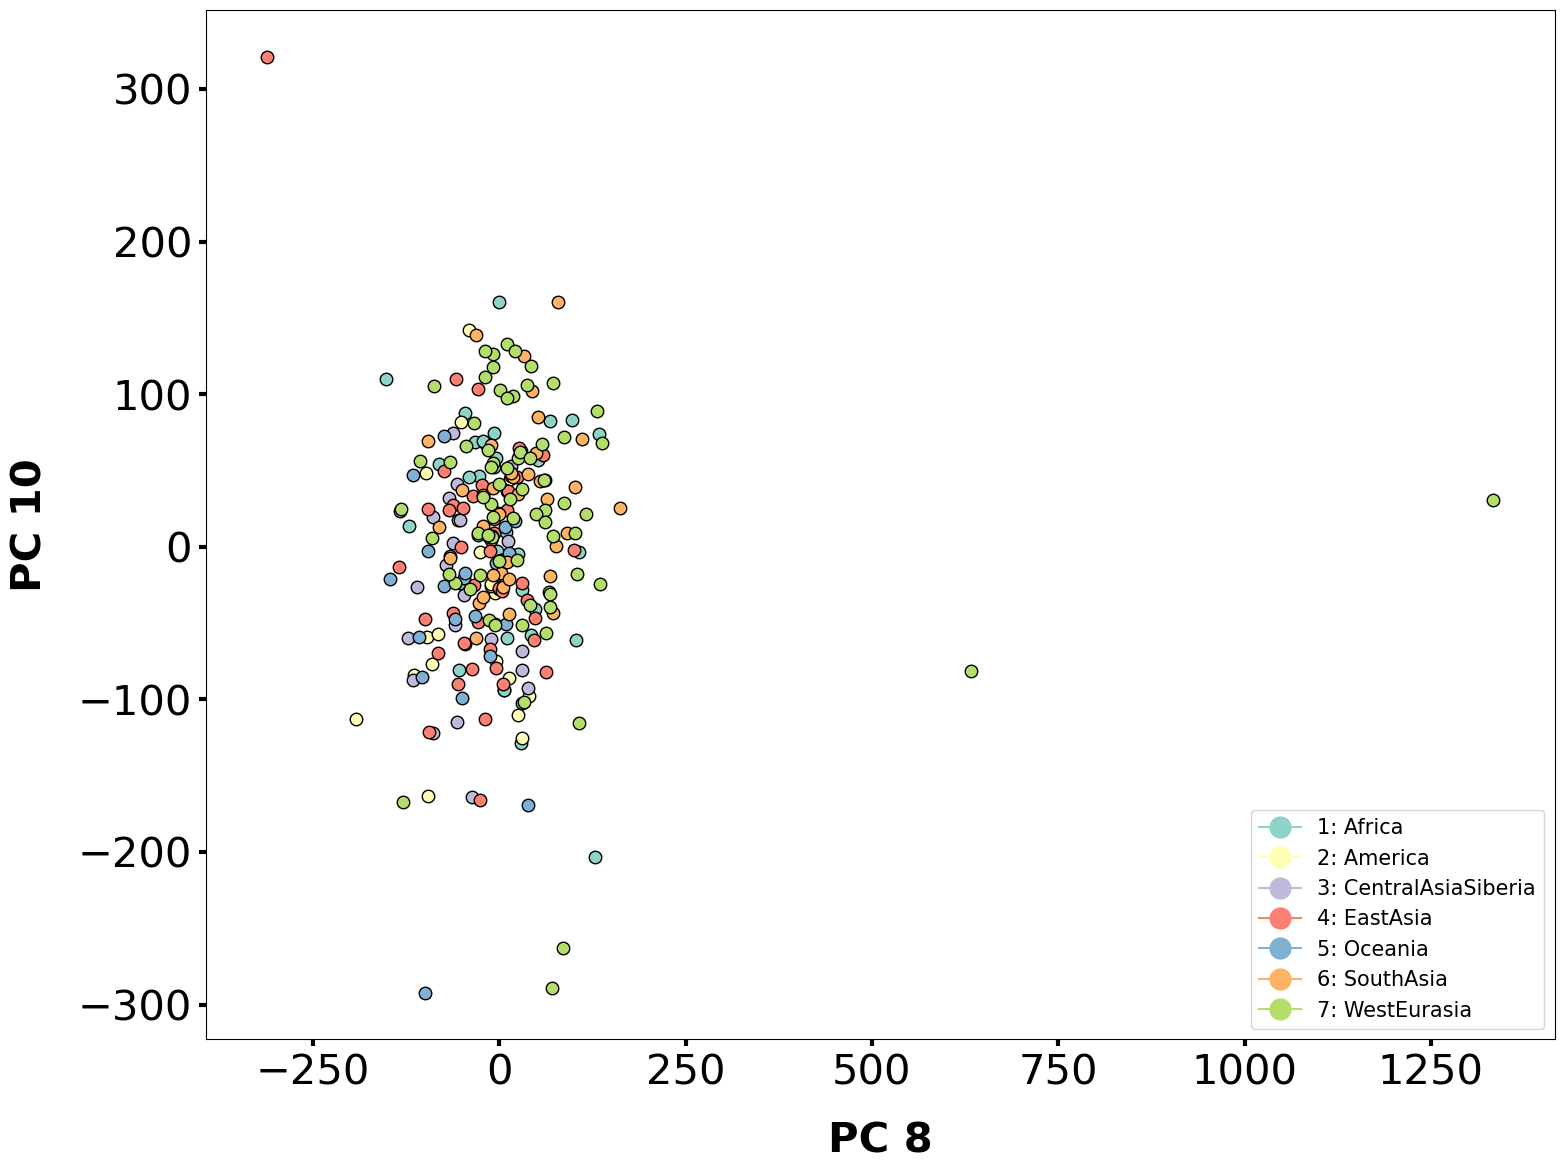

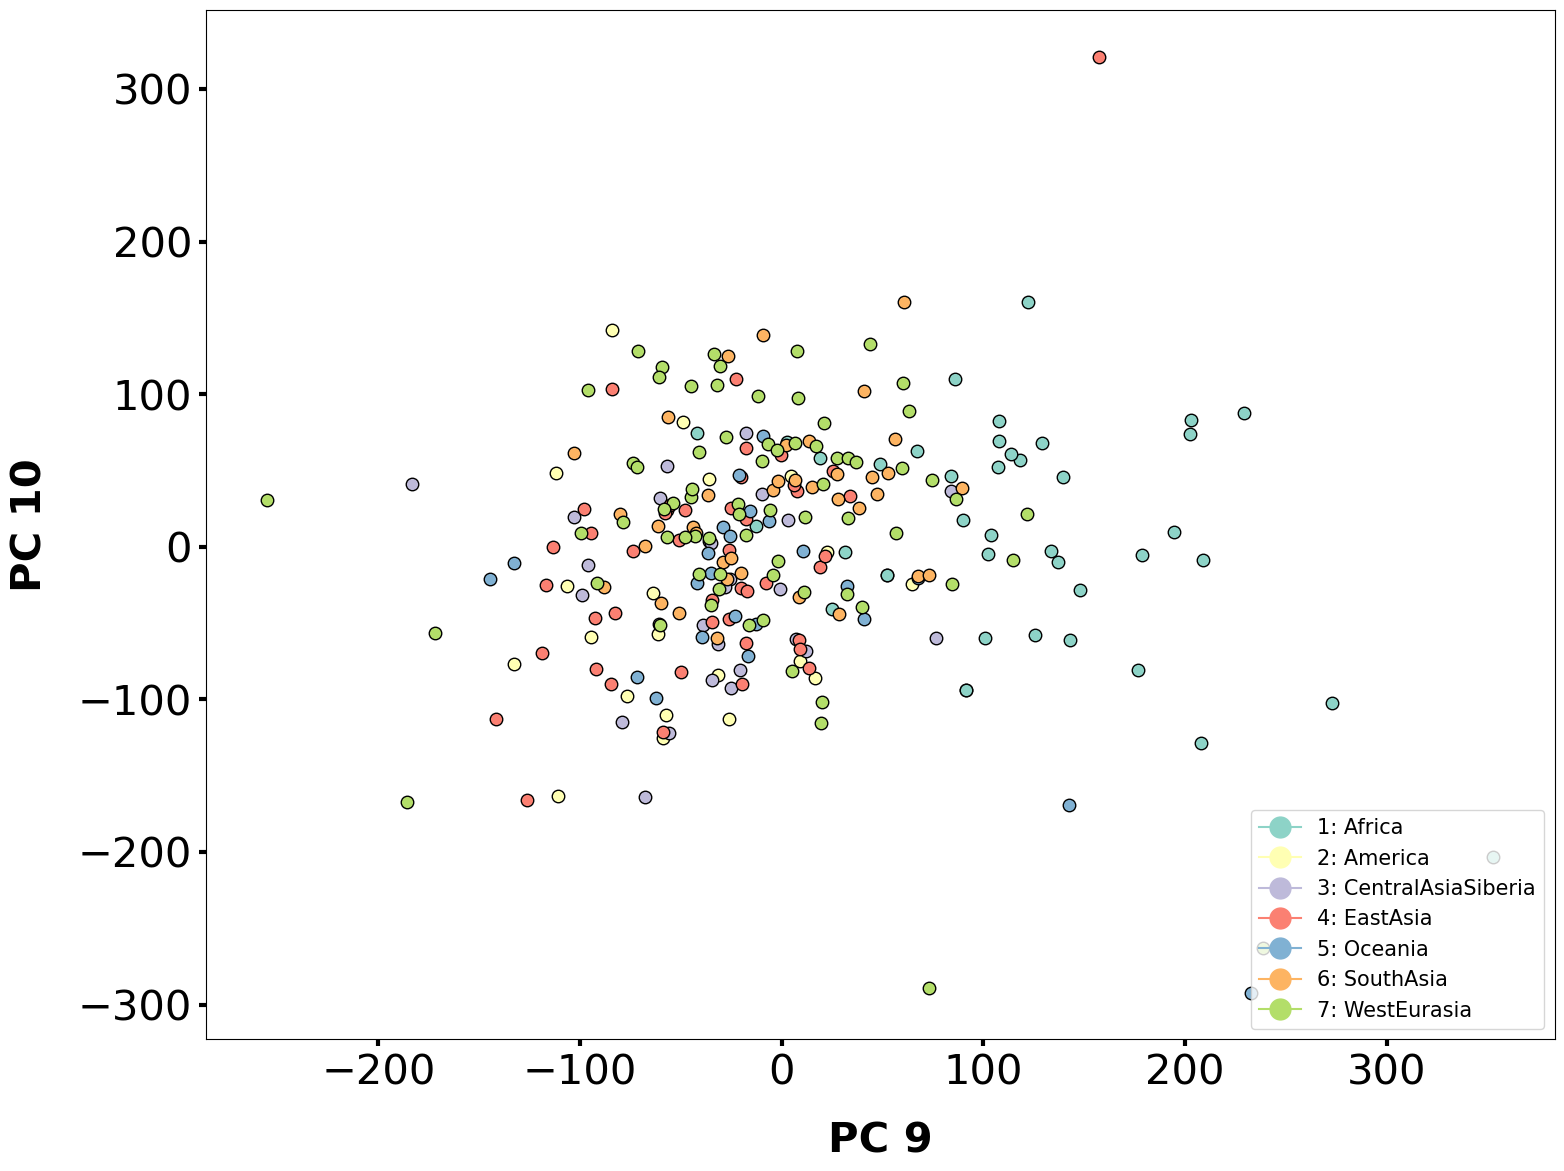

In [35]:
components = [1,2,3,4,5,6,7,8,9,10]

combinations_components = list(combinations(components,2))
for i in combinations_components:
    plot_scatter_cluster(data=df_pca, abscissa='component_'+str(i[0]), ordinate='component_'+str(i[1]), label_horizontal='PC '+ str(i[0]), label_vertical='PC '+str(i[1]), factor='Region', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
    #print(str(i[0]))
#    plot_scatter_cluster(data=df_pca, abscissa='component_8', ordinate='component_9', label_horizontal='Component 1', label_vertical='Component 3', factor='10-Region', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
    

<h1> VST

In [36]:
#coordinates = input_vst.iloc[:,0:2]
cnvs = final_cnv.iloc[:,4:287]
cnvs = cnvs.T
cnvs = cnvs.fillna(2)
cnvs

0        1        2        3        4        5        \
Sample                                                                    
LP6005441-DNA_A01        4        4        3        4        3        3   
LP6005441-DNA_A03        4        4        4        4        4        4   
LP6005441-DNA_A04        3        3        3        4        4        4   
LP6005441-DNA_A05        4        4        4        4        4        4   
LP6005441-DNA_A06        4        4        4        4        3        3   
...                    ...      ...      ...      ...      ...      ...   
LP6007069-DNA_A01        4        4        3        4        4        4   
SS6004471                3        4        3        4        3        4   
SS6004477                2        3        4        4        4        4   
SS6004478                3        3        3        4        4        4   
SS6004480                4        4        3        4        4        4   

                   6        7        8        9        ...  1116014  1116015  \
Sample                                                 ...                     
LP6005441-DNA_A01        4        4        4        4  ...        2        3   
LP6005441-DNA_A03        4        4        4        4  ...        2        4   
LP6005441-DNA_A04        4        4        4        4  ...        2        4   
LP6005441-DNA_A05        4        4        4        4  ...        2        4   
LP6005441-DNA_A06        4        4        4        4  ...        2        4   
...                    ...      ...      ...      ...  ...      ...      ...   
LP6007069-DNA_A01        4        3        4        4  ...        2        4   
SS6004471                3        4        4        4  ...        2        4   
SS6004477                4        3        4        4  ...        2        4   
SS6004478                4        3        4        4  ...        2        4   
SS6004480                3        4        4        4  ...        2        4   

                   1116016  1116017  1116018  1116019  1116020  1116021  \
Sample                                                                    
LP6005441-DNA_A01        4        3        4        4        4        4   
LP6005441-DNA_A03        4        4        4        4        4        4   
LP6005441-DNA_A04        4        4        4        4        4        4   
LP6005441-DNA_A05        4        3        4        4        4        4   
LP6005441-DNA_A06        4        4        4        4        4        4   
...                    ...      ...      ...      ...      ...      ...   
LP6007069-DNA_A01        4        4        5        4        5        4   
SS6004471                4        4        4        4        4        4   
SS6004477                4        4        5        4        4        4   
SS6004478                4        4        4        4        4        4   
SS6004480                4        4        5        4        5        4   

                   1116022  1116023  
Sample                               
LP6005441-DNA_A01        2        4  
LP6005441-DNA_A03        2        4  
LP6005441-DNA_A04        2        4  
LP6005441-DNA_A05        2        4  
LP6005441-DNA_A06        2        4  
...                    ...      ...  
LP6007069-DNA_A01        2        5  
SS6004471                2        5  
SS6004477                2        5  
SS6004478                2        4  
SS6004480                2        5  

[266 rows x 1116024 columns]

In [37]:
dt = features.merge(cnvs, left_index=True, right_index=True)
dt

Region  0  1  2  3  4  5  6  7  8  ...  1116014  \
Sample                                                     ...            
LP6005441-DNA_A01  WestEurasia  4  4  3  4  3  3  4  4  4  ...        2   
LP6005441-DNA_A03      Oceania  4  4  4  4  4  4  4  4  4  ...        2   
LP6005441-DNA_A04      America  3  3  3  4  4  4  4  4  4  ...        2   
LP6005441-DNA_A05  WestEurasia  4  4  4  4  4  4  4  4  4  ...        2   
LP6005441-DNA_A06  WestEurasia  4  4  4  4  3  3  4  4  4  ...        2   
...                        ... .. .. .. .. .. .. .. .. ..  ...      ...   
LP6007069-DNA_A01  WestEurasia  4  4  3  4  4  4  4  3  4  ...        2   
SS6004471               Africa  3  4  3  4  3  4  3  4  4  ...        2   
SS6004477              Oceania  2  3  4  4  4  4  4  3  4  ...        2   
SS6004478              Oceania  3  3  3  4  4  4  4  3  4  ...        2   
SS6004480               Africa  4  4  3  4  4  4  3  4  4  ...        2   

                   1116015  1116016  1116017  1116018  1116019  1116020  \
Sample                                                                    
LP6005441-DNA_A01        3        4        3        4        4        4   
LP6005441-DNA_A03        4        4        4        4        4        4   
LP6005441-DNA_A04        4        4        4        4        4        4   
LP6005441-DNA_A05        4        4        3        4        4        4   
LP6005441-DNA_A06        4        4        4        4        4        4   
...                    ...      ...      ...      ...      ...      ...   
LP6007069-DNA_A01        4        4        4        5        4        5   
SS6004471                4        4        4        4        4        4   
SS6004477                4        4        4        5        4        4   
SS6004478                4        4        4        4        4        4   
SS6004480                4        4        4        5        4        5   

                   1116021  1116022  1116023  
Sample                                        
LP6005441-DNA_A01        4        2        4  
LP6005441-DNA_A03        4        2        4  
LP6005441-DNA_A04        4        2        4  
LP6005441-DNA_A05        4        2        4  
LP6005441-DNA_A06        4        2        4  
...                    ...      ...      ...  
LP6007069-DNA_A01        4        2        5  
SS6004471                4        2        5  
SS6004477                4        2        5  
SS6004478                4        2        4  
SS6004480                4        2        5  

[266 rows x 1116025 columns]

<h1>just westeurasia with siberania 


In [36]:
dt_groupped[5][46387]

NameError: name 'dt_groupped' is not defined

In [ ]:
x = dt_groupped[6][46387]
y = dt_groupped[5][46387]
t =  np.concatenate((x,y))
vt = np.ndarray.var(t,axis=0)
vt

In [ ]:
vx = np.var(x, axis=0)
vy = np.var(y, axis=0)
    ########### N =  numbers of individuals sampled from population each cnv ##############    
    #nx = x.drop(columns = ['7-Gender', '10-Region', '11-Country'])

nx = len(x)
    #ny = y.drop(columns = ['7-Gender', '10-Region', '11-Country'])
ny = len(y)

In [ ]:
vs

In [ ]:
v1 = vx*nx
v2 = vy*ny
ns = nx+ny
vs = (v1+v2)/ ns
    ########## Vst #################
    #####(VT−VS)/VT
vst = (vt-vs)/vt

In [40]:
#regions.sort()

In [41]:
regions

array(['Africa', 'America', 'CentralAsiaSiberia', 'EastAsia', 'Oceania',
       'SouthAsia', 'WestEurasia'], dtype=object)

<h1> New Vst

In [78]:
####### Groupby regions #######
dt_group = dt.groupby('Region')

dt_groupped = []
regions = features['Region'].unique()
#regions.sort()
for i in regions:
    dt_groupped.append(dt_group.get_group(str(i)))
    

dt_groupped

[                        Region  0  1  2  3  4  5  6  7  8  ...  1116014  \
 Sample                                                     ...            
 LP6005441-DNA_A01  WestEurasia  4  4  3  4  3  3  4  4  4  ...        2   
 LP6005441-DNA_A05  WestEurasia  4  4  4  4  4  4  4  4  4  ...        2   
 LP6005441-DNA_A06  WestEurasia  4  4  4  4  3  3  4  4  4  ...        2   
 LP6005441-DNA_B01  WestEurasia  4  4  4  4  4  4  3  3  3  ...        2   
 LP6005441-DNA_B05  WestEurasia  4  4  4  4  4  4  4  4  4  ...        2   
 ...                        ... .. .. .. .. .. .. .. .. ..  ...      ...   
 LP6005677-DNA_A03  WestEurasia  4  3  3  4  4  4  4  3  4  ...        2   
 LP6005677-DNA_B01  WestEurasia  4  4  3  4  4  3  3  4  4  ...        2   
 LP6005677-DNA_C03  WestEurasia  4  4  4  4  4  4  4  4  4  ...        2   
 LP6007068-DNA_A01  WestEurasia  4  3  3  4  4  4  3  4  4  ...        2   
 LP6007069-DNA_A01  WestEurasia  4  4  3  4  4  4  4  3  4  ...        2   
 
          

In [79]:
#### Names to pair-population
regions = dt['Region'].unique()
#regions.sort()
combination_names = []
for i in list(combinations(regions,2)):
    combination_names.append(i[0]+str('-')+i[1])

for j in dt_groupped:
    del j['Region']


In [80]:
## Function for Vst 
def vst_function(
    x=None, 
    y=None):

    vx = np.var(x, axis=0)
    vy = np.var(y, axis=0)

    nx = len(x)
    ny = len(y)

## Vt 
    a = np.concatenate((x,y))
    vt = np.ndarray.var(a,axis=0)

### Vs = (V1*n1+V2*n2)/(n1+n2) 

    v1 = vx*nx
    v2 = vy*ny
    ns = nx+ny
    vs = (v1+v2)/ ns
    ########## Vst #################
    #####(VT−VS)/VT
    
    vst = (vt-vs)/vt
    
    return(vst) 


combination_regions = list(combinations([0,1,2,3,4,5,6],2))

vst_list = []
for region in combination_regions:
    vx = np.var(dt_groupped[region[0]])
    vy = np.var(dt_groupped[region[1]])

    nx = len(dt_groupped[region[0]])
    ny = len(dt_groupped[region[1]])

## Vt 
    a = np.concatenate((dt_groupped[region[0]], dt_groupped[region[1]]))
    vt = np.ndarray.var(a,axis=0)

### Vs = (V1*n1+V2*n2)/(n1+n2) 

    v1 = vx*nx
    v2 = vy*ny
    ns = nx+ny
    vs = (v1+v2)/ ns
    ########## Vst #################
    #####(VT−VS)/VT
    
    vst = (vt-vs)/vt
    
    vst_list.append(vst)

In [81]:
## VST for pair-population
vst_dt = []

combination_regions = list(combinations([0,1,2,3,4,5,6],2))
for region in combination_regions:
        statistic = vst_function((dt_groupped[region[0]]), (dt_groupped[region[1]]))
        vst_dt.append(statistic)

vst_dt = pd.DataFrame(vst_dt).set_axis(combination_names)
vst_dt

0         1         2         3        \
WestEurasia-Oceania             0.519862  0.397494  0.015307  0.000259   
WestEurasia-America             0.204649  0.144724  0.012571  0.001462   
WestEurasia-Africa              0.006468  0.000000  0.000325  0.000180   
WestEurasia-EastAsia            0.113541  0.054545  0.044618  0.000281   
WestEurasia-SouthAsia           0.008095  0.001326  0.017051  0.002513   
WestEurasia-CentralAsiaSiberia  0.020370  0.007718  0.027737  0.000223   
Oceania-America                 0.166597  0.117565  0.000079  0.027381   
Oceania-Africa                  0.515763  0.555743  0.026511  0.002937   
Oceania-EastAsia                0.324288  0.244979  0.005684  0.000000   
Oceania-SouthAsia               0.536866  0.495629  0.000010  0.003326   
Oceania-CentralAsiaSiberia      0.466868  0.398648  0.002689  0.000000   
America-Africa                  0.202498  0.240293  0.022848  0.002241   
America-EastAsia                0.036677  0.038055  0.006609  0.004956   
America-SouthAsia               0.227672  0.190532  0.000023  0.019079   
America-CentralAsiaSiberia      0.161123  0.123627  0.003438  0.005769   
Africa-EastAsia                 0.083757  0.071167  0.058029  0.001420   
Africa-SouthAsia                0.000019  0.002738  0.025091  0.008451   
Africa-CentralAsiaSiberia       0.008256  0.015035  0.040285  0.001386   
EastAsia-SouthAsia              0.091807  0.048573  0.006301  0.001587   
EastAsia-CentralAsiaSiberia     0.047141  0.020090  0.000385  0.000000   
SouthAsia-CentralAsiaSiberia    0.012581  0.005247  0.002815  0.001565   

                                 4         5         6         7        \
WestEurasia-Oceania             0.000510  0.000001  0.048196  0.035047   
WestEurasia-America             0.000616  0.007699  0.015411  0.010646   
WestEurasia-Africa              0.009698  0.001181  0.026217  0.000560   
WestEurasia-EastAsia            0.016785  0.001390  0.005020  0.001528   
WestEurasia-SouthAsia           0.039223  0.013456  0.002822  0.002513   
WestEurasia-CentralAsiaSiberia  0.018807  0.011098  0.018961  0.004244   
Oceania-America                 0.005236  0.014229  0.011288  0.011320   
Oceania-Africa                  0.005774  0.001439  0.006977  0.118841   
Oceania-EastAsia                0.025973  0.001377  0.091009  0.022242   
Oceania-SouthAsia               0.056470  0.012992  0.079580  0.052931   
Oceania-CentralAsiaSiberia      0.038343  0.015860  0.140169  0.081039   
America-Africa                  0.015222  0.021201  0.000381  0.069492   
America-EastAsia                0.012037  0.004376  0.042249  0.004381   
America-SouthAsia               0.036735  0.037474  0.035185  0.023275   
America-CentralAsiaSiberia      0.021759  0.000272  0.084799  0.043336   
Africa-EastAsia                 0.047963  0.005960  0.055477  0.005328   
Africa-SouthAsia                0.077678  0.008243  0.045560  0.001955   
Africa-CentralAsiaSiberia       0.051488  0.025338  0.088635  0.007480   
EastAsia-SouthAsia              0.006760  0.023304  0.000229  0.006883   
EastAsia-CentralAsiaSiberia     0.000466  0.006596  0.006897  0.010198   
SouthAsia-CentralAsiaSiberia    0.003576  0.044190  0.009058  0.000183   

                                 8         9        ...   1116014   1116015  \
WestEurasia-Oceania             0.001542  0.005399  ...       NaN  0.000049   
WestEurasia-America             0.011219  0.003751  ...       NaN  0.001010   
WestEurasia-Africa              0.021060  0.001360  ...       NaN  0.003978   
WestEurasia-EastAsia            0.032883  0.002664  ...  0.013793  0.000327   
WestEurasia-SouthAsia           0.016463  0.002313  ...       NaN  0.000088   
WestEurasia-CentralAsiaSiberia  0.022630  0.001033  ...       NaN  0.000932   
Oceania-America                 0.020704  0.000239  ...       NaN  0.002243   
Oceania-Africa                  0.034086  0.003464  ...       NaN  0.002836   
Oceania-EastAsia                0.023602  0.019570  ...  0.00762

In [82]:
filtering_vst = pd.DataFrame(vst_dt)>=0.2
filtering_vst = filtering_vst.loc[:, filtering_vst.any()]
#filtering_vst = filtering_vst.set_axis(combination_names)
filtering_vst


0        1        21       28       29       \
WestEurasia-Oceania                True     True    False    False    False   
WestEurasia-America                True    False    False    False    False   
WestEurasia-Africa                False    False    False    False    False   
WestEurasia-EastAsia              False    False    False    False    False   
WestEurasia-SouthAsia             False    False    False    False    False   
WestEurasia-CentralAsiaSiberia    False    False    False    False    False   
Oceania-America                   False    False    False    False    False   
Oceania-Africa                     True     True    False     True     True   
Oceania-EastAsia                   True     True    False    False    False   
Oceania-SouthAsia                  True     True    False    False    False   
Oceania-CentralAsiaSiberia         True     True    False    False    False   
America-Africa                     True     True    False    False    False   
America-EastAsia                  False    False    False    False    False   
America-SouthAsia                  True    False    False    False    False   
America-CentralAsiaSiberia        False    False    False    False    False   
Africa-EastAsia                   False    False    False    False    False   
Africa-SouthAsia                  False    False    False    False    False   
Africa-CentralAsiaSiberia         False    False     True    False    False   
EastAsia-SouthAsia                False    False    False    False    False   
EastAsia-CentralAsiaSiberia       False    False    False    False    False   
SouthAsia-CentralAsiaSiberia      False    False    False    False    False   

                                30       31       32       84       85       \
WestEurasia-Oceania               False    False     True    False    False   
WestEurasia-America               False    False    False    False    False   
WestEurasia-Africa                False    False    False    False    False   
WestEurasia-EastAsia              False     True    False    False    False   
WestEurasia-SouthAsia             False    False    False    False    False   
WestEurasia-CentralAsiaSiberia    False    False    False    False    False   
Oceania-America                   False    False    False     True    False   
Oceania-Africa                     True     True    False    False    False   
Oceania-EastAsia                  False    False    False    False    False   
Oceania-SouthAsia                  True     True     True    False    False   
Oceania-CentralAsiaSiberia        False     True     True    False    False   
America-Africa                    False    False    False    False    False   
America-EastAsia                  False    False    False    False    False   
America-SouthAsia                 False    False    False    False    False   
America-CentralAsiaSiberia        False    False    False    False    False   
Africa-EastAsia                    True     True    False    False    False   
Africa-SouthAsia                  False    False    False    False    False   
Africa-CentralAsiaSiberia         False    False    False    False     True   
EastAsia-SouthAsia                 True     True    False    False    False   
EastAsia-CentralAsiaSiberia       False    False    False    False    False   
SouthAsia-CentralAsiaSiberia      False    False    False    False    False   

                                ...  1112296  1112326  1112733  1112833  \
WestEurasia-Oceania             ...    False    False    False    False   
WestEurasia-America             ...    False    False    False    False   
WestEurasia-Africa              ...    False    False    False    False   
WestEurasia-EastAsia            ...    False    False    False    False   
WestEurasia-SouthAsia           ...    False    False    False    False   
WestEurasia-CentralAsiaSiberia  ...    False    False    False    False   
Oceania-America              

In [83]:
## Coordinates anotation 
vst_dt = vst_dt.T
vst_dt.insert (0, 'Chromosome', final_cnv['Chromosome'])
vst_dt.insert (1, 'Start', final_cnv['Start'])
vst_dt.insert (2, 'End', final_cnv['End'])
vst_dt.insert (3, 'Type', final_cnv['Type'])
vst_dt = vst_dt.round(5)
vst_dt = vst_dt.replace(np.NaN, 0)
vst_dt

Chromosome     Start       End         Type  WestEurasia-Oceania  \
0                1    260453    261566  duplication              0.51986   
1                1    261566    263205  duplication              0.39749   
2                1    263205    264505  duplication              0.01531   
3                1    264505    269912  duplication              0.00026   
4                1    269912    271404  duplication              0.00051   
...            ...       ...       ...          ...                  ...   
1116019         22  51289688  51291273  duplication              0.00340   
1116020         22  51291273  51292827  duplication              0.00067   
1116021         22  51292827  51295018  duplication              0.00226   
1116022         22  51295018  51296018     deletion              0.00000   
1116023         22  51295018  51296018  duplication              0.00786   

         WestEurasia-America  WestEurasia-Africa  WestEurasia-EastAsia  \
0                    0.20465             0.00647               0.11354   
1                    0.14472             0.00000               0.05455   
2                    0.01257             0.00032               0.04462   
3                    0.00146             0.00018               0.00028   
4                    0.00062             0.00970               0.01678   
...                      ...                 ...                   ...   
1116019              0.03194             0.01914               0.00602   
1116020              0.00343             0.00048               0.00361   
1116021              0.00112             0.00338               0.00008   
1116022              0.00000             0.00000               0.01379   
1116023              0.00018             0.00038               0.00718   

         WestEurasia-SouthAsia  WestEurasia-CentralAsiaSiberia  ...  \
0                      0.00809                         0.02037  ...   
1                      0.00133                         0.00772  ...   
2                      0.01705                         0.02774  ...   
3                      0.00251                         0.00022  ...   
4                      0.03922                         0.01881  ...   
...                        ...                             ...  ...   
1116019                0.00484                         0.00383  ...   
1116020                0.00096                         0.01029  ...   
1116021                0.00001                         0.00537  ...   
1116022                0.00000                         0.00000  ...   
1116023                0.00007                         0.01058  ...   

         America-Africa  America-EastAsia  America-SouthAsia  \
0               0.20250           0.03668            0.22767   
1               0.24029           0.03805            0.19053   
2               0.02285           0.00661            0.00002   
3               0.00224           0.00496            0.01908   
4               0.01522           0.01204            0.03674   
...                 ...               ...                ...   
1116019         0.00456           0.00180            0.03333   
1116020         0.00456           0.01204            0.03333   
1116021         0.03417           0.00180            0.00381   
1116022         0.00000           0.00694            0.00000   
1116023         0.00001           0.00438            0.00007   

         America-CentralAsiaSiberia  Africa-EastAsia  Africa-SouthAsia  \
0                           0.16112          0.08376           0.00002   
1                           0.12363          0.07117           0.00274   
2                           0.00344          0.05803           0.02509   
3                           0.00577          0.00142           0.00845   
4                           0.02176          0.04796           0.07768   
...                             ...              ...               ...   
1116019                     0.02935          0.00002           0.0

In [84]:
vst_dt['Chromosome'] = 'chr' + vst_dt['Chromosome'].astype(str)
vst_dt

Chromosome     Start       End         Type  WestEurasia-Oceania  \
0             chr1    260453    261566  duplication              0.51986   
1             chr1    261566    263205  duplication              0.39749   
2             chr1    263205    264505  duplication              0.01531   
3             chr1    264505    269912  duplication              0.00026   
4             chr1    269912    271404  duplication              0.00051   
...            ...       ...       ...          ...                  ...   
1116019      chr22  51289688  51291273  duplication              0.00340   
1116020      chr22  51291273  51292827  duplication              0.00067   
1116021      chr22  51292827  51295018  duplication              0.00226   
1116022      chr22  51295018  51296018     deletion              0.00000   
1116023      chr22  51295018  51296018  duplication              0.00786   

         WestEurasia-America  WestEurasia-Africa  WestEurasia-EastAsia  \
0                    0.20465             0.00647               0.11354   
1                    0.14472             0.00000               0.05455   
2                    0.01257             0.00032               0.04462   
3                    0.00146             0.00018               0.00028   
4                    0.00062             0.00970               0.01678   
...                      ...                 ...                   ...   
1116019              0.03194             0.01914               0.00602   
1116020              0.00343             0.00048               0.00361   
1116021              0.00112             0.00338               0.00008   
1116022              0.00000             0.00000               0.01379   
1116023              0.00018             0.00038               0.00718   

         WestEurasia-SouthAsia  WestEurasia-CentralAsiaSiberia  ...  \
0                      0.00809                         0.02037  ...   
1                      0.00133                         0.00772  ...   
2                      0.01705                         0.02774  ...   
3                      0.00251                         0.00022  ...   
4                      0.03922                         0.01881  ...   
...                        ...                             ...  ...   
1116019                0.00484                         0.00383  ...   
1116020                0.00096                         0.01029  ...   
1116021                0.00001                         0.00537  ...   
1116022                0.00000                         0.00000  ...   
1116023                0.00007                         0.01058  ...   

         America-Africa  America-EastAsia  America-SouthAsia  \
0               0.20250           0.03668            0.22767   
1               0.24029           0.03805            0.19053   
2               0.02285           0.00661            0.00002   
3               0.00224           0.00496            0.01908   
4               0.01522           0.01204            0.03674   
...                 ...               ...                ...   
1116019         0.00456           0.00180            0.03333   
1116020         0.00456           0.01204            0.03333   
1116021         0.03417           0.00180            0.00381   
1116022         0.00000           0.00694            0.00000   
1116023         0.00001           0.00438            0.00007   

         America-CentralAsiaSiberia  Africa-EastAsia  Africa-SouthAsia  \
0                           0.16112          0.08376           0.00002   
1                           0.12363          0.07117           0.00274   
2                           0.00344          0.05803           0.02509   
3                           0.00577          0.00142           0.00845   
4                           0.02176          0.04796           0.07768   
...                             ...              ...               ...   
1116019                     0.02935          0.00002           0.0

In [85]:
vst_dt = vst_dt.drop([46387])
vst_dt.sort_values(by=['CentralAsiaSiberia-SouthAsia'], ascending=True).head(50)

KeyError: 'CentralAsiaSiberia-SouthAsia'

In [ ]:
vst_dt.to_csv('../data/vst_results_t2tchm13.csv', index=False)

In [ ]:
#sns.set_palette("bright")
for i in vst_dt.iloc[:,4:25].columns:
    plt.hist(vst_dt[i], bins=100, alpha=0.2, log=True,color="blue")
    plt.title('T2T-CHM13')

In [ ]:
for col in vst_dt.iloc[:,3:25].columns: 
    try:      
        vst_dt.iloc[:,3:25][col] = pd.to_numeric(vst_dt.iloc[:,3:25][col]) 
        vst_dt.iloc[:,3:25].hist(column=col, bins=100, alpha=0.2, color="blue", log=True)
    except ValueError:
        print('This column can not be represented as a histogram')

In [ ]:
vst_dt.iloc[:,3:25].max(axis=1).hist(bins=100, alpha=0.8, log=True, color="blue")

In [ ]:
vst_dt[vst_dt['Type']=='duplication'].sort_values(by='Oceania-WestEurasia', ascending=False).head(200)

In [ ]:
# Simulate DataFrame
#vst_dt['i']= vst_dt.index
vst_dt["i"] = pd.to_numeric(vst_dt.index, downcast="float")

#vst_dt['log_West_Oceania'] = np.log2(vst_dt['WestEurasia-Oceania'])

# Generate Manhattan plot: (#optional tweaks for relplot: linewidth=0, s=9)
plot = sns.relplot(data=vst_dt, x='i', y='Oceania-WestEurasia', aspect=3.7, 
                  hue='Chromosome', palette = 'bright', legend=None) 
chrom_df=vst_dt.groupby('Chromosome')['i'].median()
plot.ax.set_xlabel('Chromosome'); plot.ax.set_xticks(chrom_df);
plot.ax.set_xticklabels(chrom_df.index)
plot.fig.suptitle('T2T-CHM13 WestEurasia-Oceania Vst values');

In [ ]:
vst_dt_filtered = vst_dt.iloc[filtering_vst.T.index]
vst_dt_filtered#.sort_values(by=['WestEurasia-Oceania'], ascending=False).head(50)

In [ ]:
## Saving Vst coordinates as bed file to liftover

vst_dt_filtered.iloc[:,0:4].to_csv('vst_coordinates_chm13t2t.bed', header=False, index=False,sep='\t')

In [ ]:
vst_dt_filtered.sort_values(by=['CentralAsiaSiberia-SouthAsia'], ascending=True).head(50)

<h1> Deletions 

In [ ]:
cnv_passed_vst = cnvs.T.iloc[filtering_vst.T.index]
cnv_passed_vst

In [ ]:
cnv_passed_vst = cnv_passed_vst[(cnv_passed_vst[cnv_passed_vst.columns[1:]]<3).all(axis=1)]
counts = cnv_passed_vst.T
counts = counts.sort_index()
counts

In [ ]:
#PCA

x = StandardScaler().fit_transform(counts)
pca = PCA(n_components=10)
pca_results = pca.fit_transform(x)

df_pca= pd.DataFrame(pca_results,
                          columns=['component_1','component_2', 'component_3', 'component_4',
                                  'component_5',
                                  'component_6',
                                  'component_7',
                                  'component_8',
                                  'component_9',
                                   'component_10'
                                  ],
                          index=features.index)




df_pca = features.merge(df_pca, left_index=True, right_index=True)
pca.explained_variance_ratio_

In [ ]:
components = [1,2,3,4,5,6,7,8,9,10]

combinations_components = list(combinations(components,2))
for i in combinations_components:
    plot_scatter_cluster(data=df_pca, abscissa='component_'+str(i[0]), ordinate='component_'+str(i[1]), label_horizontal='PC '+ str(i[0]), label_vertical='PC '+str(i[1]), factor='Region', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
    #print(str(i[0]))

In [ ]:
plot_scatter_cluster(data=df_pca, abscissa='component_1', ordinate='component_2', label_horizontal='PC1 (8.56%)', label_vertical='PC2 (4.18%)', factor='Region', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
plt.title("T2T-CHM13 PCA deletions")

plt.savefig('../plots/t2t_chm13_pca_deletions_pc12.png', transparent=True)

In [ ]:
plot_scatter_cluster(data=df_pca, abscissa='component_2', ordinate='component_3', label_horizontal='PC2 (4.18%)', label_vertical='PC3 (3.45%)', factor='Region', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
plt.title("T2T-CHM13 PCA deletions ")

plt.savefig('../plots/t2t_chm13_pca_deletions_pc23.png', transparent=True)

<h1> Duplications

In [ ]:
cnv_passed_vst = cnvs.T.iloc[filtering_vst.T.index]
cnv_passed_vst = cnv_passed_vst[(cnv_passed_vst[cnv_passed_vst.columns[1:]]<5).all(axis=1)]
cnv_passed_vst = cnv_passed_vst[(cnv_passed_vst[cnv_passed_vst.columns[1:]]>1).all(axis=1)]
counts = cnv_passed_vst.T
counts = counts.sort_index()
counts

In [ ]:
#PCA

x = StandardScaler().fit_transform(counts)
pca = PCA(n_components=10)
pca_results = pca.fit_transform(x)

df_pca= pd.DataFrame(pca_results,
                          columns=['component_1','component_2', 'component_3', 'component_4',
                                  'component_5',
                                  'component_6',
                                  'component_7',
                                  'component_8',
                                  'component_9',
                                   'component_10'
                                  ],
                          index=features.index)




df_pca = features.merge(df_pca, left_index=True, right_index=True)
pca.explained_variance_ratio_

In [ ]:
plot_scatter_cluster(data=df_pca, abscissa='component_1', ordinate='component_2', label_horizontal='PC1 (7.19%)', label_vertical='PC2 (5.10%)', factor='Region', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
plt.title("T2T-CHM13 PCA duplications")

plt.savefig('../plots/t2t_chm13_pca_duplications_pc12.png', transparent=True)

In [ ]:
plot_scatter_cluster(data=df_pca, abscissa='component_2', ordinate='component_3', label_horizontal='PC2 (5.10%)', label_vertical='PC3 (2.30%)', factor='Region', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
plt.title("T2T-CHM13 PCA duplications")

plt.savefig('../plots/t2t_chm13_pca_duplications_pc23.png', transparent=True)

In [ ]:
components = [1,2,3,4,5,6,7,8,9,10]

combinations_components = list(combinations(components,2))
for i in combinations_components:
    plot_scatter_cluster(data=df_pca, abscissa='component_'+str(i[0]), ordinate='component_'+str(i[1]), label_horizontal='PC '+ str(i[0]), label_vertical='PC '+str(i[1]), factor='Region', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
    #print(str(i[0]))

In [ ]:
vst_dt_filtered_duplications = vst_dt.iloc[cnv_passed_vst.index]
vst_dt_filtered_duplications.sort_values(by=['WestEurasia-Oceania'], ascending=False).head(50)

<h1> Permutation

In [ ]:
print("Starting permutation")
### Grouping again 
cnvs_passed_vst = cnvs.T.iloc[filtering_vst.T.index]
cnvs_passed_vst = cnvs_passed_vst.T

dt_cnvs_passed_vst = features.merge(cnvs_passed_vst, left_index=True, right_index=True)
dt_cnvs_passed_vst.head()


In [ ]:
cnvs_passed_vst.columns

In [ ]:
####### Groupby regions #######
dt_group = dt_cnvs_passed_vst.groupby('Region')

dt_groupped = []
regions = features['Region'].unique()
for i in regions:
    dt_groupped.append(dt_group.get_group(str(i)))
    

#### Names to pair-population
regions = dt['Region'].unique()
combination_names = []
for i in list(combinations(regions,2)):
    combination_names.append(i[0]+str('-')+i[1])
    
dt_groupped[region[0]]

In [ ]:
p_value_permutation = []

combination_regions = list(combinations([0,1,2,3,4,5,6],2)) 
for region in combination_regions:
    p_value= []
    p_value_permutation.append(p_value)
    
    for i in cnvs_passed_vst.columns:
        permutation = PermutationTest(dt_groupped[region[0]][i], dt_groupped[region[1]][i], stat=vst_function, n_perm=9999)#mean_gt
        p_value.append(permutation.p_value())

In [ ]:
pd.DataFrame(p_value_permutation)

In [ ]:
permutation_pased__vst_chm13 = pd.DataFrame(p_value_permutation).set_axis(combination_names)
# create a process pool that uses all cpus
permutation_pased__vst_chm13.to_csv('../data/permutation_passed_vst_chm13.csv')
permutation_pased__vst_chm13

In [ ]:
permutation_pased__vst_chm13  = pd.read_csv('../data/permutation_passed_vst_chm13.csv', index_col=0)
permutation_pased__vst_chm13 = permutation_pased__vst_chm13.fillna(0)

<h1> Just vst values that passed permutation

In [ ]:
vst_dt_filtered = vst_dt.iloc[filtering_vst.T.index]
vst_dt_filtered = vst_dt_filtered.reset_index()
vst_dt_sb = vst_dt_filtered.drop(columns=['chr', 'start','end', 'index'])
vst_dt_sb.describe()

In [ ]:
passed_permut = (permutation_pased__vst_chm13 <0.05)
## Deleting columns where none of the regions passed the imputation
passed_permut =  passed_permut.loc[:, passed_permut.any()]


passed_permut = passed_permut.T
passed_permut = passed_permut.replace(False, np.NaN)
passed_permut = passed_permut.reset_index()
passed_permut = passed_permut.drop(columns=['index'])
passed_permut#.describe()

In [ ]:
passed_permut[passed_permut.notnull()] = vst_dt_sb

In [ ]:
passed_permut

In [ ]:
#sns.set_palette("bright")
for i in passed_permut.columns:
    plt.hist(passed_permut[i], bins=100, alpha=0.2,log=True, color="blue")
    plt.title('T2T-CHM13')

In [ ]:
final_candidates  = pd.DataFrame(passed_permut.T)>=0.2
final_candidates = final_candidates.loc[:, final_candidates.any()]
final_candidates

<h1> Gene regions

In [ ]:
gene_coordinates_ranges = PyRanges(gene_coordinates)
gene_coordinates_ranges

In [ ]:
final_cnv_ranges = PyRanges(final_cnv)
final_cnv_df = final_cnv_ranges.overlap(gene_coordinates_ranges, invert=False)
final_cnv_df = final_cnv_df.as_df()
#final_cnv_df = final_cnv_df[final_cnv_df['Chromosome'] =='8'] #487805
final_cnv_df.to_csv('../data/T2TCHM13_cnvs_genes.csv.zip', compression="zip")

In [ ]:
final_cnv_df

In [ ]:
#final_cnv = final_cnv.iloc[new]
final = final_cnv_df.iloc[:,3:284]
counts = final

counts = counts.fillna(2)
counts = counts[counts.lt(5).all(axis=1)]

counts = counts.T
counts = counts.sort_index()
counts

In [ ]:
features = ids_hg19.set_index('Sample').merge(counts, left_index=True, right_index=True)
features = features.loc[:,['Region']]
features = features.sort_index()

In [ ]:
#PCA

pca = PCA(n_components=10)
pca_results = pca.fit_transform(counts)

df_pca= pd.DataFrame(pca_results,
                          columns=['component_1','component_2', 'component_3', 'component_4',
                                  'component_5',
                                  'component_6',
                                  'component_7',
                                  'component_8',
                                  'component_9',
                                   'component_10'
                                  ],
                          index=features.index)




df_pca = features.merge(df_pca, left_index=True, right_index=True)
df_pca

In [ ]:
pca.explained_variance_ratio_

In [ ]:
components = [1,2,3,4,5,6,7,8,9,10]

combinations_components = list(combinations(components,2))
for i in combinations_components:
    plot_scatter_cluster(data=df_pca, abscissa='component_'+str(i[0]), ordinate='component_'+str(i[1]), label_horizontal='PC '+ str(i[0]), label_vertical='PC '+str(i[1]), factor='Region', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
    #print(str(i[0]))
#    plot_scatter_cluster(data=df_pca, abscissa='component_8', ordinate='component_9', label_horizontal='Component 1', label_vertical='Component 3', factor='10-Region', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
    
    

In [ ]:
<h1> Testing permutation 